<br>

<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=3>
<p align="center">
  <strong>Sharif University of Technology</strong><br>
  Faculty of Industrial Engineering
</p>

<font color=2565AE size=5>
<p align="center">Project Report</p>
</br>
<p align="center"><strong>Implementation with Pyomo</strong></p>
</br>
<p align="center">
  <strong>Course:</strong> Operations Research II<br>
  <strong>Instructor:</strong> Dr. Maryam Radman
</p>


<font color=3C99D size=3>
<p align="center">Group Members</p>

<div align="center">

| No. | Full Name                        | Student ID |
|-----|----------------------------------|------------|
| 1   | Sonia Dabagh Tafreshi           | 401104102  |
| 2   | Ghazal Zolfi Moselo            | 401104146  |
| 3   | MohammadMahdi Montazeri Hedesh   | 401104479  |

</div>

<p align="center"><strong>Term:</strong> Second Semester, 1403–1404</p>


# Table of Contents
- [Table of Contents](#table-of-contents)
- [Install and Import Necessary Libraries and Packages](#install-and-import-necessary-libraries-and-packages)
- [Load and Prepare Data](#load-and-prepare-data)
- [Q2 - Model Implementation with Pyomo](#q2---model-implementation-with-pyomo)
  - [Create a concrete model](#create-a-concrete-model)
  - [Define Sets](#define-sets)
  - [Define Parameters from Input Data](#define-parameters-from-input-data)
  - [Define Decision Variables](#define-decision-variables)
  - [Define Objective Function](#define-objective-function)
  - [Define Constraints](#define-constraints)
    - [Constraints Related to Ship-Berth Assignment](#constraints-related-to-ship-berth-assignment)
    - [Time and Waiting Constraints](#time-and-waiting-constraints)
    - [Order and Consistency Constraints](#order-and-consistency-constraints)
    - [Cost Calculation and Waiting Time Breakdown](#cost-calculation-and-waiting-time-breakdown)
    - [Constraints for Waiting Time Cost Segmentation](#constraints-for-waiting-time-cost-segmentation)
  - [Solve Model](#solve-model)
  - [Show Results](#show-results)

- [Q3 - Storing Model Results in a DataFrame and Visualizing Ship-to-Berth Assignments](#q3---storing-model-results-in-a-dataframe-and-visualizing-ship-to-berth-assignments)
- [Q4 - Impact of Relaxing the Assignment Constraint on Berth 3](#q4---impact-of-relaxing-the-assignment-constraint-on-berth-3)
- [Q6 - Sensitivity Analysis](#q6---sensitivity-analysis)
  - [Modular Implementation](#modular-implementation)
  - [Part 1 - Time lag at Berth 2:](#part-1---time-lag-at-berth-2)
  - [Part 2 - Unload time of Ship 7 at Berth 3:](#part-2---unload-time-of-ship-7-at-berth-3)
  - [Part 3 - Capacity of Berth 2:](#part-3---capacity-of-berth-2)
  - [Part 4 - Capacity of Berth 3:](#part-4---capacity-of-berth-3)
  - [Part 5 - Arrival Time of Ship 6:](#part-5---arrival-time-of-ship-6)

# Install and Import Necessary Libraries and Packages

In [1]:
!apt-get install -y glpk-utils
!apt-get install -y python-glpk
!apt-get install -y glpk-doc
!pip install pyomo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-glpk
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-doc is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
import pyomo.environ as pyo
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Load and Prepare Data

In [3]:
arrival_data = pd.DataFrame({
    'Ship': [1, 2, 3, 4, 5, 6, 7, 8],
    'Arrival_Time': [4.765526987, 1.004592503, 3.65299865, 6.054178125,
                     1.86918948, 2.117990219, 4.622951825, 6.601178383]
})

container_data = pd.DataFrame({
    'Ship': [1, 2, 3, 4, 5, 6, 7, 8],
    'Containers': [6, 18, 20, 5, 11, 19, 20, 13]
})

length_data = pd.DataFrame({
    'Ship': [1, 2, 3, 4, 5, 6, 7, 8],
    'Length': [114, 126, 115, 102, 102, 131, 119, 138]
})

priority_data = pd.DataFrame({
    'Ship': [1, 2, 3, 4, 5, 6, 7, 8],
    'Priority': [0.963796539, 0.773138121, 0.441550822, 0.981939255,
                 0.190926112, 0.348681095, 0.970486629, 0.445607269]
})

capacity_data = pd.DataFrame({
    'Berth': [1, 2, 3, 4],
    'Capacity': [57, 40, 52, 30]
})

max_extra_capacity_data = pd.DataFrame({
    'Berth': [1, 2, 3, 4],
    'Max_Extra_Allowable_Capacity': [29, 15, 49, 17]
})

cost_extra_capacity_data = pd.DataFrame({
    'Berth': [1, 2, 3, 4],
    'Cost_for_Extra_Capacity': [5.87153989, 5.880447197, 8.864246732, 6.640319654]
})

max_length_data = pd.DataFrame({
    'Berth': [1, 2, 3, 4],
    'Max_Length': [118, 236, 120, 138]
})

lag_data = pd.DataFrame({
    'Berth': [1, 2, 3, 4],
    'Lag': [6.922094322, 9.72782535, 9.564812914, 5.748308268]
})

anchorage_data = pd.DataFrame({
    'Berth': [1, 2, 3, 4],
    'Anchorage': [2, 2, 3, 2]
})


unload_time_raw = [
    {'Ship_Berth': "['1', '1']", 'Unload_Time': 9.306945068},
    {'Ship_Berth': "['1', '2']", 'Unload_Time': 8.320459113},
    {'Ship_Berth': "['1', '3']", 'Unload_Time': 9.041338719},
    {'Ship_Berth': "['1', '4']", 'Unload_Time': 8.655545623},
    {'Ship_Berth': "['2', '1']", 'Unload_Time': 8.499993353},
    {'Ship_Berth': "['2', '2']", 'Unload_Time': 9.905633818},
    {'Ship_Berth': "['2', '3']", 'Unload_Time': 9.993113985},
    {'Ship_Berth': "['2', '4']", 'Unload_Time': 8.089112765},
    {'Ship_Berth': "['3', '1']", 'Unload_Time': 9.720322075},
    {'Ship_Berth': "['3', '2']", 'Unload_Time': 9.206381222},
    {'Ship_Berth': "['3', '3']", 'Unload_Time': 8.763211972},
    {'Ship_Berth': "['3', '4']", 'Unload_Time': 8.567236436},
    {'Ship_Berth': "['4', '1']", 'Unload_Time': 9.349929694},
    {'Ship_Berth': "['4', '2']", 'Unload_Time': 8.913662302},
    {'Ship_Berth': "['4', '3']", 'Unload_Time': 9.371722971},
    {'Ship_Berth': "['4', '4']", 'Unload_Time': 9.32369264},
    {'Ship_Berth': "['5', '1']", 'Unload_Time': 8.265956289},
    {'Ship_Berth': "['5', '2']", 'Unload_Time': 9.535675628},
    {'Ship_Berth': "['5', '3']", 'Unload_Time': 9.964826498},
    {'Ship_Berth': "['5', '4']", 'Unload_Time': 9.938776321},
    {'Ship_Berth': "['6', '1']", 'Unload_Time': 9.226653641},
    {'Ship_Berth': "['6', '2']", 'Unload_Time': 8.088521266},
    {'Ship_Berth': "['6', '3']", 'Unload_Time': 8.008110288},
    {'Ship_Berth': "['6', '4']", 'Unload_Time': 8.267945054},
    {'Ship_Berth': "['7', '1']", 'Unload_Time': 9.882004543},
    {'Ship_Berth': "['7', '2']", 'Unload_Time': 8.605721124},
    {'Ship_Berth': "['7', '3']", 'Unload_Time': 8.732291203},
    {'Ship_Berth': "['7', '4']", 'Unload_Time': 9.796392489},
    {'Ship_Berth': "['8', '1']", 'Unload_Time': 8.62872761},
    {'Ship_Berth': "['8', '2']", 'Unload_Time': 9.097964368},
    {'Ship_Berth': "['8', '3']", 'Unload_Time': 8.872061915},
    {'Ship_Berth': "['8', '4']", 'Unload_Time': 8.129988352}
]

unload_time_list = []
for item in unload_time_raw:
    ship_berth = ast.literal_eval(item['Ship_Berth'])
    ship = int(ship_berth[0])
    berth = int(ship_berth[1])
    unload_time = item['Unload_Time']
    unload_time_list.append({'Ship': ship, 'Berth': berth, 'Unload_Time': unload_time})

unload_time_data = pd.DataFrame(unload_time_list)

# Q2 - Model Implementation with Pyomo

## Create a concrete model

In [4]:
model = pyo.ConcreteModel()

## Define Sets

In [5]:
I = range(1, 9)  # Ships {1, 2, ..., 8}
J = range(1, 5)  # Berths {1, 2, 3, 4}
R = range(1, 4)  # Cost ranges {1, 2, 3}

model.I = pyo.Set(initialize=I)
model.J = pyo.Set(initialize=J)
model.R = pyo.Set(initialize=R)

## Define Parameters from Input Data

In [6]:
# Ship parameters:
A = {i: arrival_data[arrival_data['Ship'] == i]['Arrival_Time'].values[0] for i in I}
Q = {i: container_data[container_data['Ship'] == i]['Containers'].values[0] for i in I}
L = {i: length_data[length_data['Ship'] == i]['Length'].values[0] for i in I}
P = {i: priority_data[priority_data['Ship'] == i]['Priority'].values[0] for i in I}
T = {}
for index, row in unload_time_data.iterrows():
    i = row['Ship']
    j = row['Berth']
    T[(i, j)] = row['Unload_Time']

W_max = {i: 80 * (1 - P[i]) for i in I}
m = {}
for i in I:
    for k in I:
        if P[i] >= P[k]:
            m[(i, k)] = 1
        else:
            m[(i, k)] = 0

model.A = pyo.Param(model.I, initialize=A)
model.Q = pyo.Param(model.I, initialize=Q)
model.L = pyo.Param(model.I, initialize=L)
model.P = pyo.Param(model.I, initialize=P)
model.T = pyo.Param(model.I, model.J, initialize=T)
model.W_max = pyo.Param(model.I, initialize=W_max)
model.m = pyo.Param(model.I, model.I, initialize=m)


# Berth parameters:
N = {j: anchorage_data[anchorage_data['Berth'] == j]['Anchorage'].values[0] for j in J}
D = {j: capacity_data[capacity_data['Berth'] == j]['Capacity'].values[0] for j in J}
D_bar = {j: max_extra_capacity_data[max_extra_capacity_data['Berth'] == j]['Max_Extra_Allowable_Capacity'].values[0] for j in J}
h = {j: cost_extra_capacity_data[cost_extra_capacity_data['Berth'] == j]['Cost_for_Extra_Capacity'].values[0] for j in J}
K = {j: max_length_data[max_length_data['Berth'] == j]['Max_Length'].values[0] for j in J}
delta = {j: lag_data[lag_data['Berth'] == j]['Lag'].values[0] for j in J}

model.N = pyo.Param(model.J, initialize=N)
model.D = pyo.Param(model.J, initialize=D)
model.D_bar = pyo.Param(model.J, initialize=D_bar)
model.h = pyo.Param(model.J, initialize=h)
model.K = pyo.Param(model.J, initialize=K)
model.delta = pyo.Param(model.J, initialize=delta)

# Define big M
M = 1000000

## Define Decision Variables

In [7]:
model.x = pyo.Var(model.I, model.J, domain=pyo.Binary)
model.S = pyo.Var(model.I, domain=pyo.NonNegativeReals)
model.W = pyo.Var(model.I, domain=pyo.NonNegativeReals)
model.u = pyo.Var(model.J, domain=pyo.NonNegativeReals)
model.y = pyo.Var(model.I, model.I, model.J, domain=pyo.Binary)
model.b = pyo.Var(model.I, model.R, domain=pyo.NonNegativeReals)
model.g = pyo.Var(model.I, model.R, domain=pyo.Binary)
model.C = pyo.Var(model.I, domain=pyo.NonNegativeReals)

## Define Objective Function

In [8]:
def obj_rule(model):
    term1 = sum(model.T[i,j] * model.x[i,j] for i in model.I for j in model.J)
    term2 = sum(model.h[j] * model.u[j] for j in model.J)
    term3 = sum(model.C[i] for i in model.I)
    return 5*term1 + term2 + term3

model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

## Define Constraints

### Constraints Related to Ship-Berth Assignment

In [9]:
def ship_assignment_rule(model, i):
    return sum(model.x[i,j] for j in model.J) == 1

def berth_capacity_124_rule(model, j):
    if j in [1, 2, 4]:
        return sum(model.x[i,j] for i in model.I) <= 2
    else:
        return pyo.Constraint.Skip

def berth_capacity_3_rule(model):
    return sum(model.x[i,3] for i in model.I) == 3

def container_capacity_rule(model, j):
    return sum(model.x[i,j] * model.Q[i] for i in model.I) <= model.D[j] + model.u[j]

def extra_capacity_rule(model, j):
    return model.u[j] <= model.D_bar[j]

def ship_length_rule(model, i, j):
    return model.x[i,j] * model.L[i] <= model.K[j]


model.ship_assignment = pyo.Constraint(model.I, rule=ship_assignment_rule)
model.berth_capacity_124 = pyo.Constraint(model.J, rule=berth_capacity_124_rule)
model.berth_capacity_3 = pyo.Constraint(rule=berth_capacity_3_rule)
model.container_capacity = pyo.Constraint(model.J, rule=container_capacity_rule)
model.extra_capacity = pyo.Constraint(model.J, rule=extra_capacity_rule)
model.ship_length = pyo.Constraint(model.I, model.J, rule=ship_length_rule)

### Time and Waiting Constraints

In [10]:
def arrival_time_rule(model, i):
    return model.A[i] + model.W[i] == model.S[i]

def max_waiting_time_rule(model, i):
    return model.W[i] <= model.W_max[i]

def time_sequence_rule(model, i, k, j):
    if i != k:
        return model.S[i] + model.T[i,j] + model.delta[j] <= model.S[k] + M * (1 - model.y[i,k,j])
    else:
        return pyo.Constraint.Skip

model.arrival_time = pyo.Constraint(model.I, rule=arrival_time_rule)
model.max_waiting_time = pyo.Constraint(model.I, rule=max_waiting_time_rule)
model.time_sequence = pyo.Constraint(model.I, model.I, model.J, rule=time_sequence_rule)

### Order and Consistency Constraints

In [11]:
def activation_constraint_rule(model, i, k, j):
    if i == k:
        return pyo.Constraint.Skip
    return model.y[i, k, j] + model.y[k, i, j] <= model.x[i, j] + model.x[k, j]

def ordering_constraint_rule(model, i, k, j):
    if i == k:
        return pyo.Constraint.Skip
    return model.y[i, k, j] + model.y[k, i, j] >= model.x[i, j] + model.x[k, j] - 1

def priority_enforcement_rule(model, i, k, j):
    if i == k:
        return pyo.Constraint.Skip
    return model.y[i, k, j] >= model.m[i, k] + model.x[i, j] + model.x[k, j] - 2

model.ActivationConstraint = pyo.Constraint(model.I, model.I, model.J, rule=activation_constraint_rule)
model.OrderingConstraint = pyo.Constraint(model.I, model.I, model.J, rule=ordering_constraint_rule)
model.PriorityConstraint = pyo.Constraint(model.I, model.I, model.J, rule=priority_enforcement_rule)

### Cost Calculation and Waiting Time Breakdown

In [12]:
def cost_calculation_rule(model, i):
    return model.C[i] == 25 * model.b[i,1] + 10 * model.b[i,2] + 5 * model.b[i,3]

def waiting_time_calculation_rule(model, i):
    return model.W[i] == model.b[i,1] + model.b[i,2] + model.b[i,3]

model.cost_calculation = pyo.Constraint(model.I, rule=cost_calculation_rule)
model.waiting_time_calculation = pyo.Constraint(model.I, rule=waiting_time_calculation_rule)

### Constraints for Waiting Time Cost Segmentation

In [13]:
def range1_lower_rule(model, i):
    return 10 * model.g[i,1] <= model.b[i,1]

def range1_upper_rule(model, i):
    return model.b[i,1] <= 10

def range2_lower_rule(model, i):
    return 30 * model.g[i,2] <= model.b[i,2]

def range2_upper_rule(model, i):
    return model.b[i,2] <= 30 * model.g[i,1]

def range3_lower_rule(model, i):
    return 0 <= model.b[i,3]

def range3_upper_rule(model, i):
    return model.b[i,3] <= 30 * model.g[i,2]

model.range1_lower = pyo.Constraint(model.I, rule=range1_lower_rule)
model.range1_upper = pyo.Constraint(model.I, rule=range1_upper_rule)
model.range2_lower = pyo.Constraint(model.I, rule=range2_lower_rule)
model.range2_upper = pyo.Constraint(model.I, rule=range2_upper_rule)
model.range3_lower = pyo.Constraint(model.I, rule=range3_lower_rule)
model.range3_upper = pyo.Constraint(model.I, rule=range3_upper_rule)

## Solve Model

In [14]:
solver = pyo.SolverFactory('glpk')
print(f"GLPK is available: {solver.available()}")

GLPK is available: True


In [15]:
solver = pyo.SolverFactory('glpk')
solver.solve(model, tee=False)

{'Problem': [{'Name': 'unknown', 'Lower bound': 1803.27060150232, 'Upper bound': 1803.27060150232, 'Number of objectives': 1, 'Number of constraints': 1028, 'Number of variables': 324, 'Number of nonzeros': 3440, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '395', 'Number of created subproblems': '395'}}, 'Error rc': 0, 'Time': 0.4657862186431885}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Show Results

In [16]:
print("\nResults:")
print("Objective value:", pyo.value(model.objective))

print("\nShip assignments:")
for i in model.I:
    for j in model.J:
        if pyo.value(model.x[i,j]) > 0.5:  # Binary variable with value close to 1
            print(f"Ship {i} assigned to Berth {j}")
            print(f"  Start time: {pyo.value(model.S[i]):.2f}")
            print(f"  Waiting time: {pyo.value(model.W[i]):.2f}")
            print(f"  Unloading time: {pyo.value(model.T[i,j]):.2f}")

print("\nBerth utilization:")
for j in model.J:
    print(f"Berth {j}:")
    print(f"  Base capacity: {model.D[j]}")
    print(f"  Extra capacity used: {pyo.value(model.u[j]):.2f}")
    print(f"  Total ships: {sum(pyo.value(model.x[i,j]) for i in model.I)}")


Results:
Objective value: 1803.270601502319

Ship assignments:
Ship 1 assigned to Berth 2
  Start time: 4.77
  Waiting time: 0.00
  Unloading time: 8.32
Ship 2 assigned to Berth 4
  Start time: 1.00
  Waiting time: 0.00
  Unloading time: 8.09
Ship 3 assigned to Berth 3
  Start time: 22.92
  Waiting time: 19.27
  Unloading time: 8.76
Ship 4 assigned to Berth 1
  Start time: 6.05
  Waiting time: 0.00
  Unloading time: 9.35
Ship 5 assigned to Berth 3
  Start time: 41.25
  Waiting time: 39.38
  Unloading time: 9.96
Ship 6 assigned to Berth 2
  Start time: 22.81
  Waiting time: 20.70
  Unloading time: 8.09
Ship 7 assigned to Berth 3
  Start time: 4.62
  Waiting time: 0.00
  Unloading time: 8.73
Ship 8 assigned to Berth 4
  Start time: 14.84
  Waiting time: 8.24
  Unloading time: 8.13

Berth utilization:
Berth 1:
  Base capacity: 57
  Extra capacity used: 0.00
  Total ships: 1.0
Berth 2:
  Base capacity: 40
  Extra capacity used: 0.00
  Total ships: 2.0
Berth 3:
  Base capacity: 52
  Extra 

# Q3 - Storing Model Results in a DataFrame and Visualizing Ship-to-Berth Assignments

In [17]:
results = []

for i in model.I:
    for j in model.J:
        if pyo.value(model.x[i, j]) > 0.5:
            start = pyo.value(model.S[i])
            unload = pyo.value(model.T[i,j])
            stop = start + unload
            wait = pyo.value(model.W[i])
            results.append({
                'Ship': i,
                'Berth': j,
                'Start Time': start,
                'Unload Time': unload,
                'Stop Time': stop,
                'Waiting Time': wait
            })

df = pd.DataFrame(results)
df

,Ship,Berth,Start Time,Unload Time,Stop Time,Waiting Time
0,1,2,4.765527,8.320459,13.085986,0.000000
1,2,4,1.004593,8.089113,9.093705,0.000000
2,3,3,22.920056,8.763212,31.683268,19.267057
3,4,1,6.054178,9.349930,15.404108,0.000000
4,5,3,41.248081,9.964826,51.212907,39.378891
5,6,2,22.813811,8.088521,30.902333,20.695821
6,7,3,4.622952,8.732291,13.355243,0.000000
7,8,4,14.842014,8.129988,22.972002,8.240835


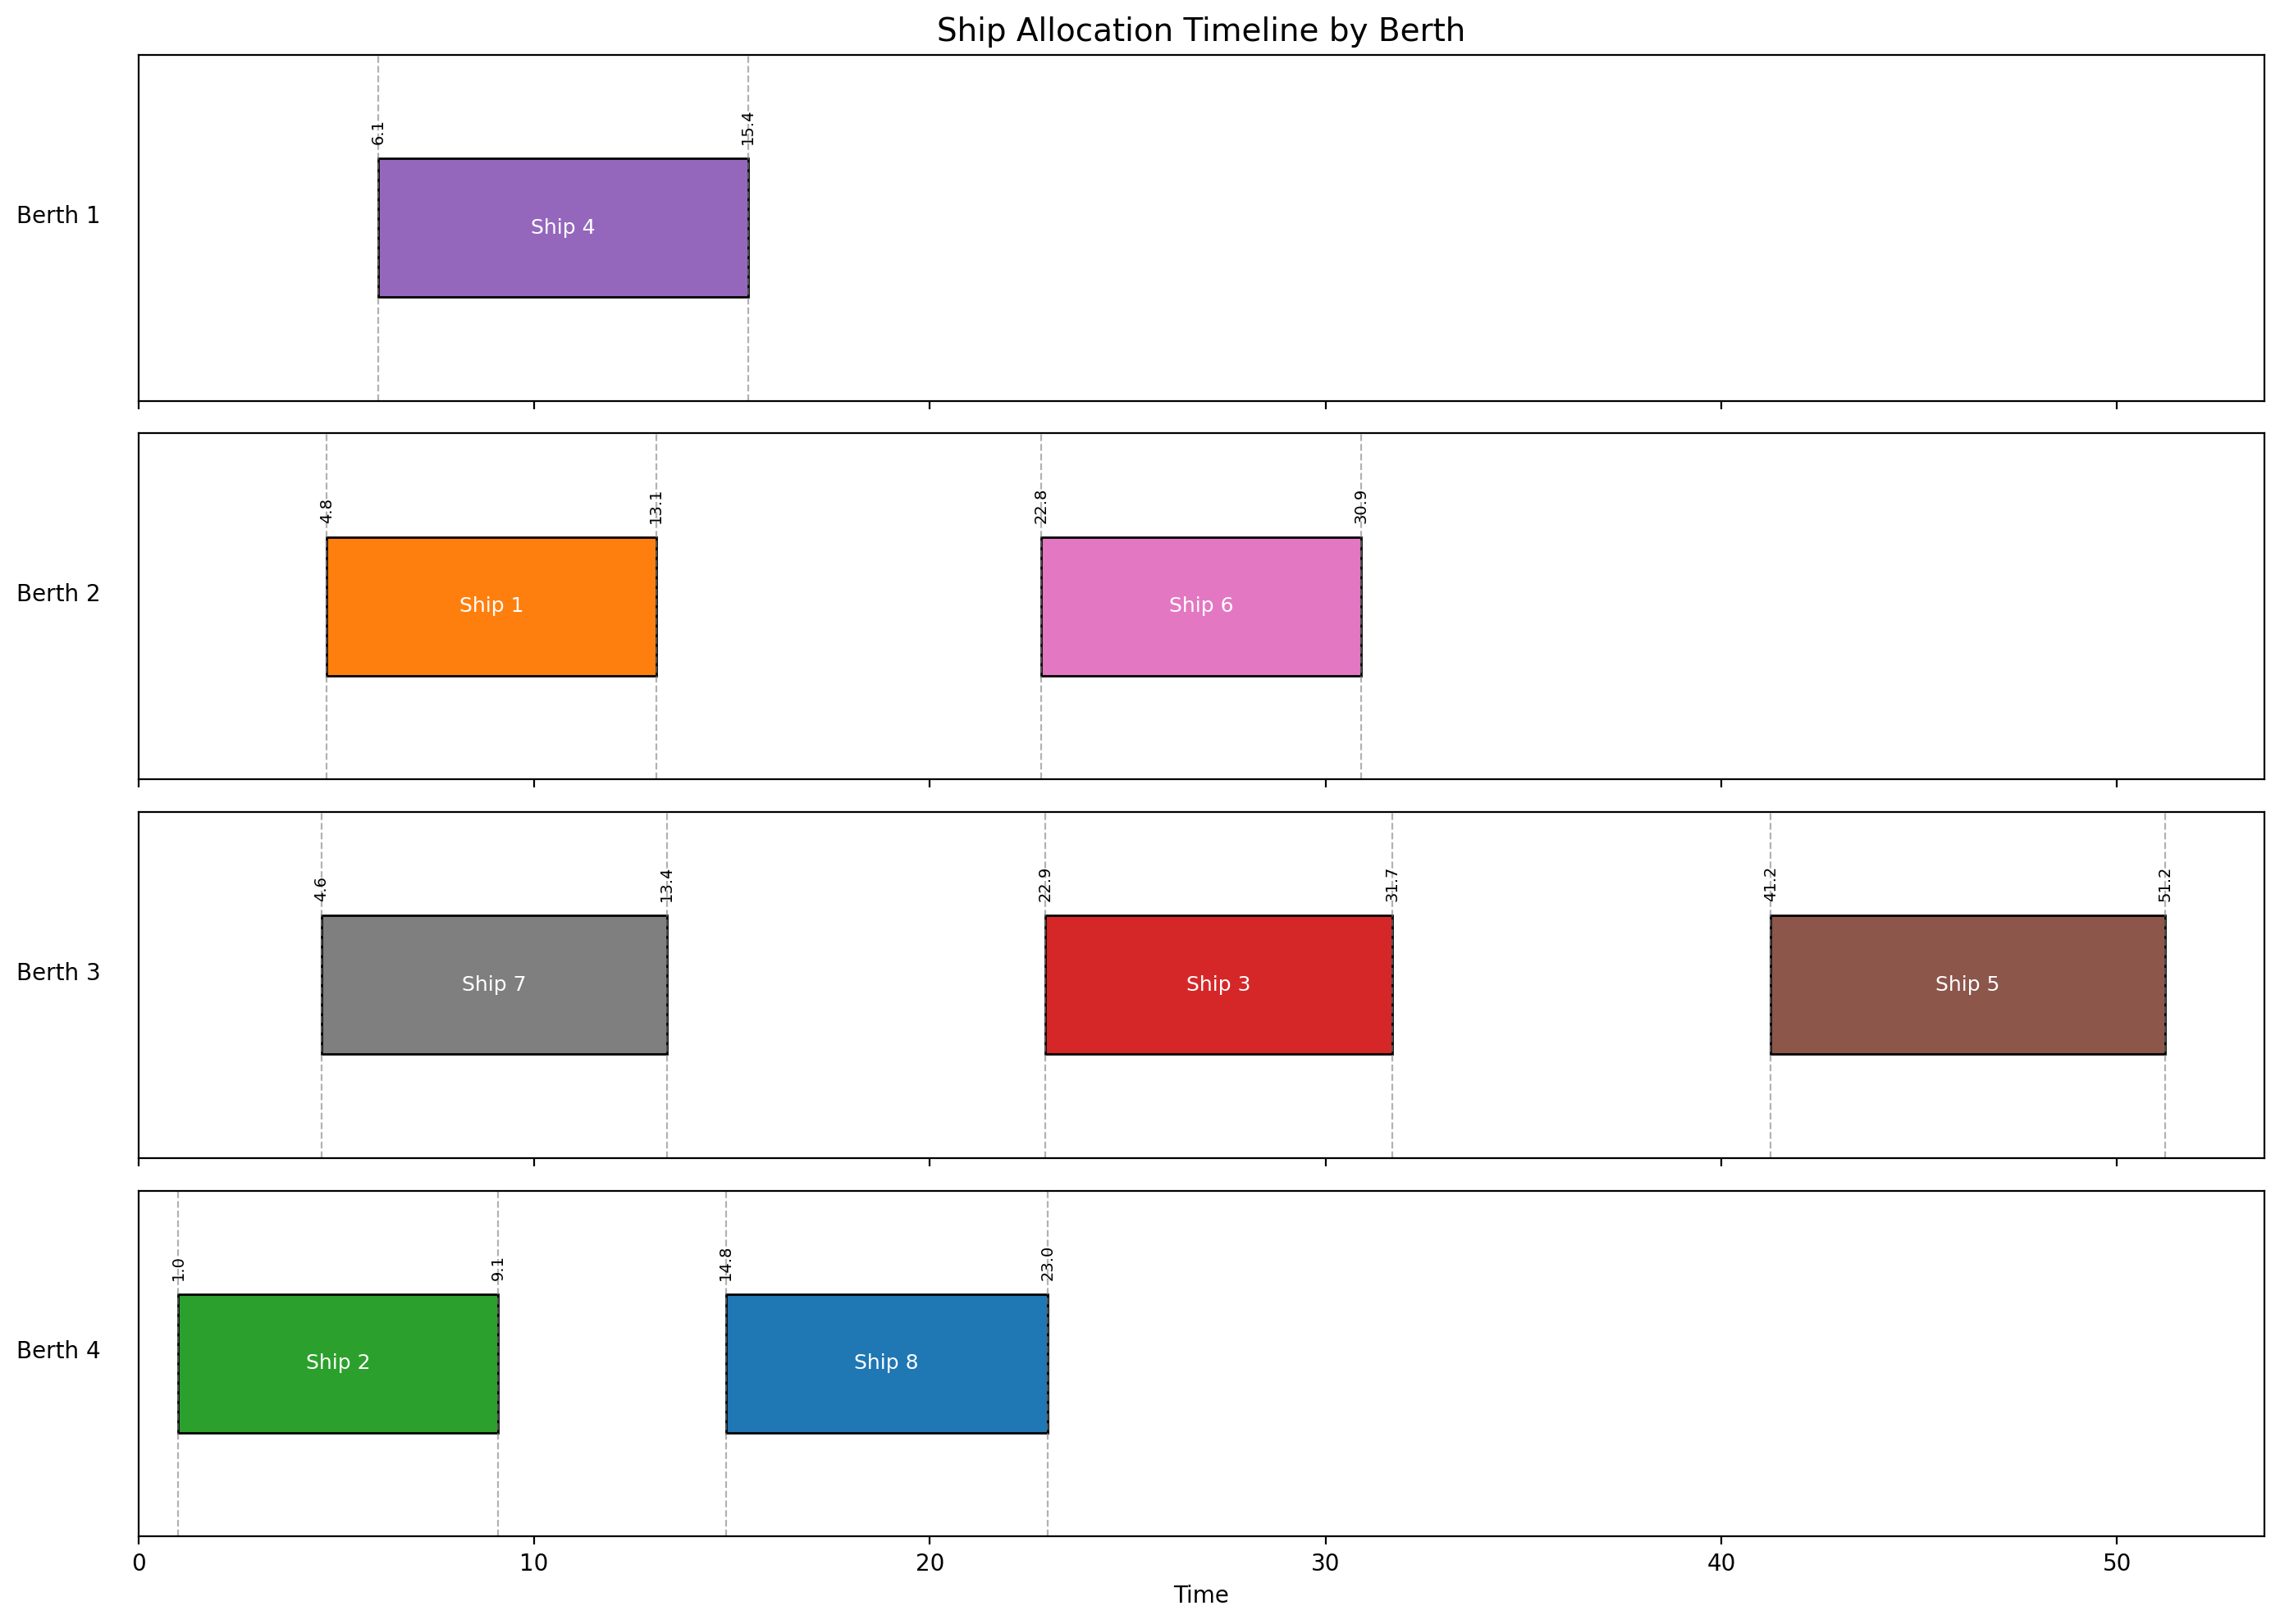

In [18]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                 '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

berth_labels = sorted(df['Berth'].unique())

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True, dpi=200)

for i, berth in enumerate(berth_labels):
    ax = axes[i]
    df_berth = df[df['Berth'] == berth]

    for idx, row in df_berth.iterrows():
        ship_id = int(row['Ship'])
        start = row['Start Time']
        duration = row['Unload Time']
        end = start + duration
        color = custom_colors[ship_id % len(custom_colors)]

        y_center = 0.5
        bar_height = 0.4
        ax.barh(y=y_center, width=duration, left=start, height=bar_height,
                color=color, edgecolor='black')

        ax.text(start + duration / 2, y_center,
                f"Ship {ship_id}",
                va='center', ha='center',
                fontsize=9, color='white' if duration > 1.5 else 'black')

        ax.axvline(x=start, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
        ax.axvline(x=end, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

        ax.text(start, y_center + 0.25, f"{start:.1f}", rotation=90, fontsize=7, ha='center')
        ax.text(end, y_center + 0.25, f"{end:.1f}", rotation=90, fontsize=7, ha='center')

    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_ylabel(f"Berth {berth}", rotation=0, labelpad=35, fontsize=10)

axes[0].set_title("Ship Allocation Timeline by Berth", fontsize=14)
axes[-1].set_xlabel("Time")
axes[-1].set_xlim(left=0)

plt.tight_layout()
plt.show()

# Q4 - Impact of Relaxing the Assignment Constraint on Berth 3

In [19]:
def berth_capacity_3_rule(model):
    return sum(model.x[i,3] for i in model.I) <= 3

model.berth_capacity_3 = pyo.Constraint(rule=berth_capacity_3_rule)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


In [20]:
solver = pyo.SolverFactory('glpk')
solver.solve(model, tee=False)

{'Problem': [{'Name': 'unknown', 'Lower bound': 1605.55746358783, 'Upper bound': 1605.55746358783, 'Number of objectives': 1, 'Number of constraints': 1028, 'Number of variables': 324, 'Number of nonzeros': 3440, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '4125', 'Number of created subproblems': '4125'}}, 'Error rc': 0, 'Time': 7.096062183380127}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [21]:
print("\nResults:")
print("Objective value:", pyo.value(model.objective))

print("\nShip assignments:")
for i in model.I:
    for j in model.J:
        if pyo.value(model.x[i,j]) > 0.5:  # Binary variable with value close to 1
            print(f"Ship {i} assigned to Berth {j}")
            print(f"  Start time: {pyo.value(model.S[i]):.2f}")
            print(f"  Waiting time: {pyo.value(model.W[i]):.2f}")
            print(f"  Unloading time: {pyo.value(model.T[i,j]):.2f}")

print("\nBerth utilization:")
for j in model.J:
    print(f"Berth {j}:")
    print(f"  Base capacity: {model.D[j]}")
    print(f"  Extra capacity used: {pyo.value(model.u[j]):.2f}")
    print(f"  Total ships: {sum(pyo.value(model.x[i,j]) for i in model.I)}")


Results:
Objective value: 1605.5574635878302

Ship assignments:
Ship 1 assigned to Berth 2
  Start time: 4.77
  Waiting time: 0.00
  Unloading time: 8.32
Ship 2 assigned to Berth 4
  Start time: 1.00
  Waiting time: 0.00
  Unloading time: 8.09
Ship 3 assigned to Berth 3
  Start time: 22.92
  Waiting time: 19.27
  Unloading time: 8.76
Ship 4 assigned to Berth 1
  Start time: 6.05
  Waiting time: 0.00
  Unloading time: 9.35
Ship 5 assigned to Berth 1
  Start time: 22.33
  Waiting time: 20.46
  Unloading time: 8.27
Ship 6 assigned to Berth 2
  Start time: 22.81
  Waiting time: 20.70
  Unloading time: 8.09
Ship 7 assigned to Berth 3
  Start time: 4.62
  Waiting time: 0.00
  Unloading time: 8.73
Ship 8 assigned to Berth 4
  Start time: 14.84
  Waiting time: 8.24
  Unloading time: 8.13

Berth utilization:
Berth 1:
  Base capacity: 57
  Extra capacity used: 0.00
  Total ships: 2.0
Berth 2:
  Base capacity: 40
  Extra capacity used: 0.00
  Total ships: 2.0
Berth 3:
  Base capacity: 52
  Extra

In [22]:
results2 = []

for i in model.I:
    for j in model.J:
        if pyo.value(model.x[i, j]) > 0.5:
            start = pyo.value(model.S[i])
            unload = pyo.value(model.T[i,j])
            stop = start + unload
            wait = pyo.value(model.W[i])
            results2.append({
                'Ship': i,
                'Berth': j,
                'Start Time': start,
                'Unload Time': unload,
                'Stop Time': stop,
                'Waiting Time': wait
            })

df = pd.DataFrame(results2)
df

,Ship,Berth,Start Time,Unload Time,Stop Time,Waiting Time
0,1,2,4.765527,8.320459,13.085986,0.000000
1,2,4,1.004593,8.089113,9.093705,0.000000
2,3,3,22.920056,8.763212,31.683268,19.267057
3,4,1,6.054178,9.349930,15.404108,0.000000
4,5,1,22.326202,8.265956,30.592158,20.457013
5,6,2,22.813811,8.088521,30.902333,20.695821
6,7,3,4.622952,8.732291,13.355243,0.000000
7,8,4,14.842014,8.129988,22.972002,8.240835


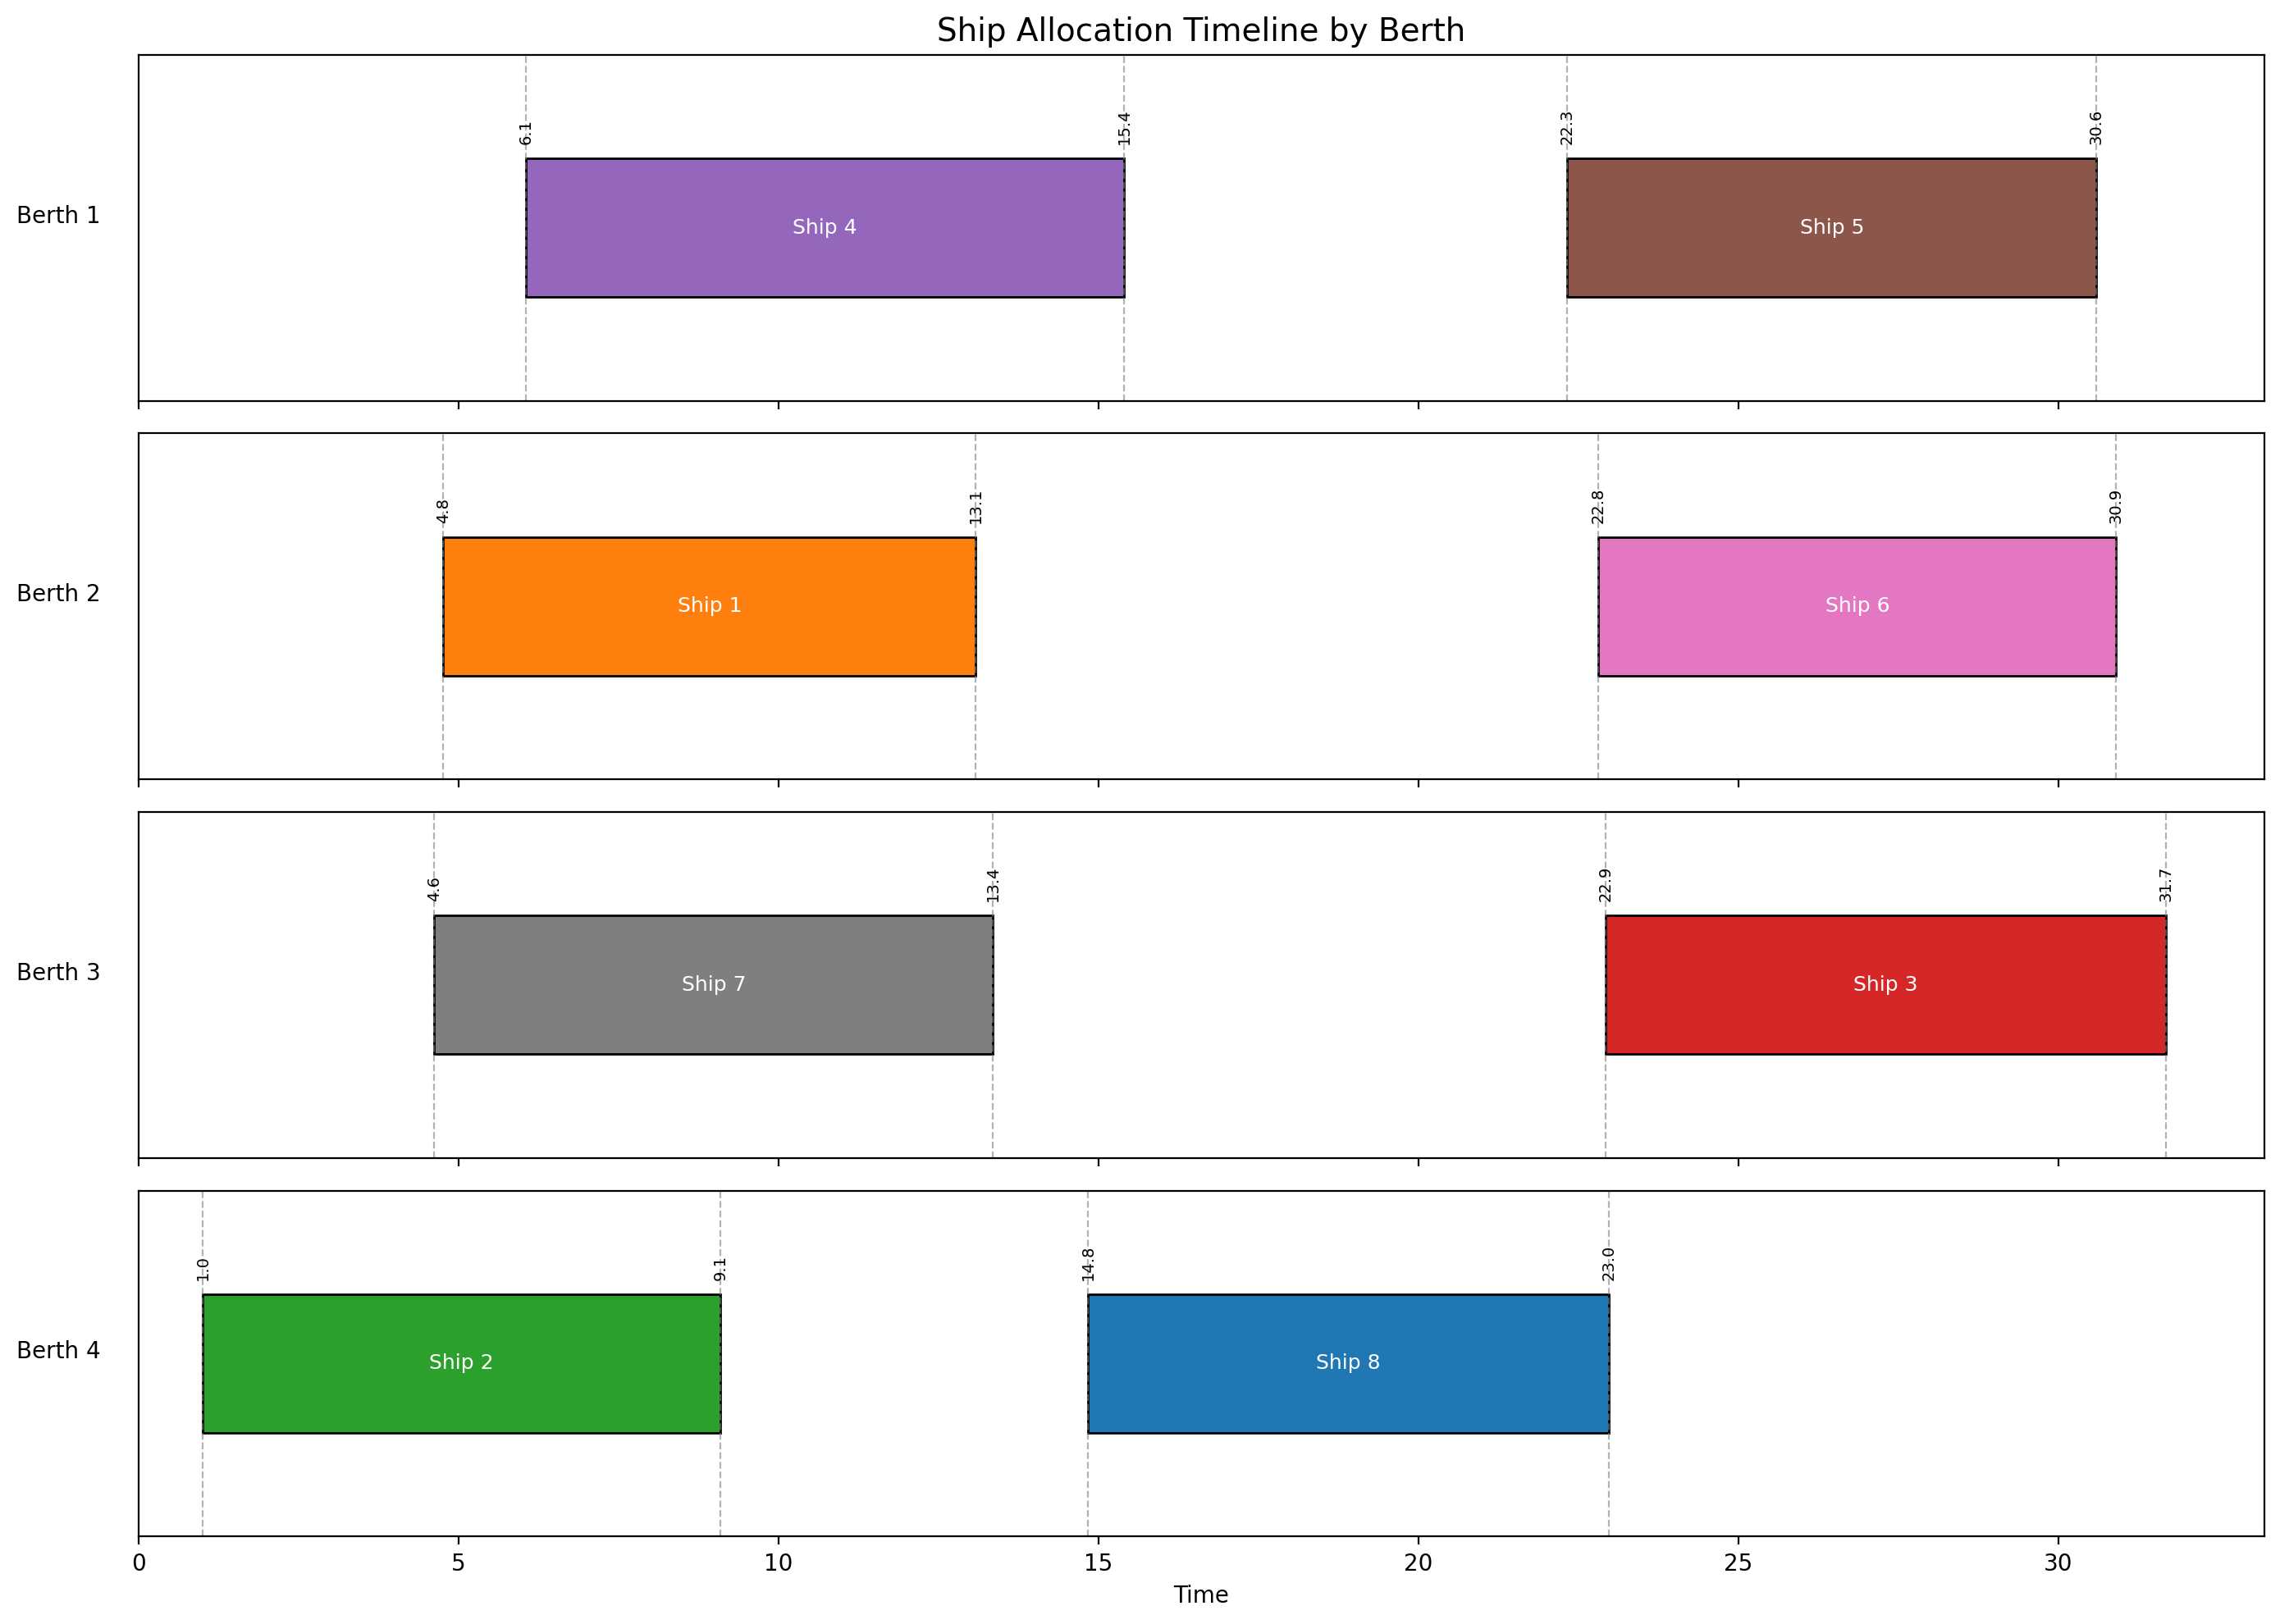

In [23]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                 '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

berth_labels = sorted(df['Berth'].unique())

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True ,dpi=200)

for i, berth in enumerate(berth_labels):
    ax = axes[i]
    df_berth = df[df['Berth'] == berth]

    for idx, row in df_berth.iterrows():
        ship_id = int(row['Ship'])
        start = row['Start Time']
        duration = row['Unload Time']
        end = start + duration
        color = custom_colors[ship_id % len(custom_colors)]

        y_center = 0.5
        bar_height = 0.4
        ax.barh(y=y_center, width=duration, left=start, height=bar_height,
                color=color, edgecolor='black')

        ax.text(start + duration / 2, y_center,
                f"Ship {ship_id}",
                va='center', ha='center',
                fontsize=9, color='white' if duration > 1.5 else 'black')

        ax.axvline(x=start, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
        ax.axvline(x=end, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

        ax.text(start, y_center + 0.25, f"{start:.1f}", rotation=90, fontsize=7, ha='center')
        ax.text(end, y_center + 0.25, f"{end:.1f}", rotation=90, fontsize=7, ha='center')

    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_ylabel(f"Berth {berth}", rotation=0, labelpad=35, fontsize=10)

axes[0].set_title("Ship Allocation Timeline by Berth", fontsize=14)
axes[-1].set_xlabel("Time")
axes[-1].set_xlim(left=0)

plt.tight_layout()
plt.show()

# Q6 - Sensitivity Analysis

### Modular Implementation

To conduct the sensitivity analysis, we structured our implementation by separating the model construction and solving processes into two distinct functions: `build_model()` and `solve_model()`. This modular approach enables us to apply controlled changes to the initial input parameters—such as berth capacities, unloading times, or ship arrival times—without duplicating code or altering the original model structure manually each time. By rebuilding the model for each parameter setting and resolving it accordingly, we can consistently analyze the impact of specific changes on the objective function, ship allocations, and total waiting times.

To evaluate the base-case performance of our allocation strategy, we utilize the function `get_base_assignments()`, which extracts the ship-to-berth assignments from the original scenario without any parameter perturbations. This serves as a reference point for all subsequent comparisons.

The function `compare_assignments()` enables a systematic comparison between the base allocation and alternative scenarios resulting from changes in model parameters. It identifies variations in ship assignments, which is crucial for understanding the robustness of the allocation decisions under uncertainty or new operational conditions.

To support interpretability and facilitate communication of results, two visualization functions are employed. `visualize_assignment_change()` generates intuitive plots that highlight changes in ship-to-berth allocations across scenarios, helping decision-makers quickly grasp the implications of parameter adjustments. Meanwhile, `create_assignment_matrix_plot()` visualizes the complete assignment matrix, offering a holistic view of ship scheduling outcomes in a matrix form that reflects the interactions between ships and berths.

Finally, the function `create_sensitivity_plot()` summarizes the results of the sensitivity analysis through informative plots. These plots provide insights into how key metrics such as total waiting time, berth utilization, or the number of reassigned ships vary with respect to changes in individual input parameters. This visual feedback is instrumental in identifying critical parameters and potential operational bottlenecks.

Together, these functions form a cohesive framework for modeling, solving, and analyzing ship allocation problems using Pyomo. The modular and visual structure supports both detailed analysis and efficient experimentation across different operational settings.


In [24]:
def build_model():
    """Build and return the complete Pyomo model"""
    model = pyo.ConcreteModel()

    # Sets
    I = range(1, 9)  # Ships {1, 2, ..., 8}
    J = range(1, 5)  # Berths {1, 2, 3, 4}
    R = range(1, 4)  # Cost ranges {1, 2, 3}

    model.I = pyo.Set(initialize=I)
    model.J = pyo.Set(initialize=J)
    model.R = pyo.Set(initialize=R)

    # Ship parameters
    A = {i: arrival_data[arrival_data['Ship'] == i]['Arrival_Time'].values[0] for i in I}
    Q = {i: container_data[container_data['Ship'] == i]['Containers'].values[0] for i in I}
    L = {i: length_data[length_data['Ship'] == i]['Length'].values[0] for i in I}
    P = {i: priority_data[priority_data['Ship'] == i]['Priority'].values[0] for i in I}
    T = {}
    for index, row in unload_time_data.iterrows():
        i = row['Ship']
        j = row['Berth']
        T[(i, j)] = row['Unload_Time']

    W_max = {i: 80 * (1 - P[i]) for i in I}
    m = {}
    for i in I:
        for k in I:
            if P[i] >= P[k]:
                m[(i, k)] = 1
            else:
                m[(i, k)] = 0

    model.A = pyo.Param(model.I, initialize=A, mutable=True)
    model.Q = pyo.Param(model.I, initialize=Q)
    model.L = pyo.Param(model.I, initialize=L)
    model.P = pyo.Param(model.I, initialize=P)
    model.T = pyo.Param(model.I, model.J, initialize=T, mutable=True)
    model.W_max = pyo.Param(model.I, initialize=W_max)
    model.m = pyo.Param(model.I, model.I, initialize=m)

    # Berth parameters
    N = {j: anchorage_data[anchorage_data['Berth'] == j]['Anchorage'].values[0] for j in J}
    D = {j: capacity_data[capacity_data['Berth'] == j]['Capacity'].values[0] for j in J}
    D_bar = {j: max_extra_capacity_data[max_extra_capacity_data['Berth'] == j]['Max_Extra_Allowable_Capacity'].values[0] for j in J}
    h = {j: cost_extra_capacity_data[cost_extra_capacity_data['Berth'] == j]['Cost_for_Extra_Capacity'].values[0] for j in J}
    K = {j: max_length_data[max_length_data['Berth'] == j]['Max_Length'].values[0] for j in J}
    delta = {j: lag_data[lag_data['Berth'] == j]['Lag'].values[0] for j in J}

    model.N = pyo.Param(model.J, initialize=N)
    model.D = pyo.Param(model.J, initialize=D, mutable=True)
    model.D_bar = pyo.Param(model.J, initialize=D_bar)
    model.h = pyo.Param(model.J, initialize=h)
    model.K = pyo.Param(model.J, initialize=K)
    model.delta = pyo.Param(model.J, initialize=delta, mutable=True)

    M = 1000000

    # Decision Variables
    model.x = pyo.Var(model.I, model.J, domain=pyo.Binary)
    model.S = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.W = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.u = pyo.Var(model.J, domain=pyo.NonNegativeReals)
    model.y = pyo.Var(model.I, model.I, model.J, domain=pyo.Binary)
    model.b = pyo.Var(model.I, model.R, domain=pyo.NonNegativeReals)
    model.g = pyo.Var(model.I, model.R, domain=pyo.Binary)
    model.C = pyo.Var(model.I, domain=pyo.NonNegativeReals)

    # Objective Function
    def obj_rule(model):
        term1 = sum(model.T[i,j] * model.x[i,j] for i in model.I for j in model.J)
        term2 = sum(model.h[j] * model.u[j] for j in model.J)
        term3 = sum(model.C[i] for i in model.I)
        return 5*term1 + term2 + term3

    model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Constraints
    def ship_assignment_rule(model, i):
        return sum(model.x[i,j] for j in model.J) == 1

    def berth_capacity_124_rule(model, j):
        if j in [1, 2, 4]:
            return sum(model.x[i,j] for i in model.I) <= 2
        else:
            return pyo.Constraint.Skip

    def berth_capacity_3_rule(model):
        return sum(model.x[i,3] for i in model.I) == 3

    def container_capacity_rule(model, j):
        return sum(model.x[i,j] * model.Q[i] for i in model.I) <= model.D[j] + model.u[j]

    def extra_capacity_rule(model, j):
        return model.u[j] <= model.D_bar[j]

    def ship_length_rule(model, i, j):
        return model.x[i,j] * model.L[i] <= model.K[j]

    def arrival_time_rule(model, i):
        return model.A[i] + model.W[i] == model.S[i]

    def max_waiting_time_rule(model, i):
        return model.W[i] <= model.W_max[i]

    def time_sequence_rule(model, i, k, j):
        if i != k:
            return model.S[i] + model.T[i,j] + model.delta[j] <= model.S[k] + M * (1 - model.y[i,k,j])
        else:
            return pyo.Constraint.Skip

    def activation_constraint_rule(model, i, k, j):
        if i == k:
            return pyo.Constraint.Skip
        return model.y[i, k, j] + model.y[k, i, j] <= model.x[i, j] + model.x[k, j]

    def ordering_constraint_rule(model, i, k, j):
        if i == k:
            return pyo.Constraint.Skip
        return model.y[i, k, j] + model.y[k, i, j] >= model.x[i, j] + model.x[k, j] - 1

    def priority_enforcement_rule(model, i, k, j):
        if i == k:
            return pyo.Constraint.Skip
        return model.y[i, k, j] >= model.m[i, k] + model.x[i, j] + model.x[k, j] - 2

    def cost_calculation_rule(model, i):
        return model.C[i] == 25 * model.b[i,1] + 10 * model.b[i,2] + 5 * model.b[i,3]

    def waiting_time_calculation_rule(model, i):
        return model.W[i] == model.b[i,1] + model.b[i,2] + model.b[i,3]

    def range1_lower_rule(model, i):
        return 10 * model.g[i,1] <= model.b[i,1]

    def range1_upper_rule(model, i):
        return model.b[i,1] <= 10

    def range2_lower_rule(model, i):
        return 30 * model.g[i,2] <= model.b[i,2]

    def range2_upper_rule(model, i):
        return model.b[i,2] <= 30 * model.g[i,1]

    def range3_lower_rule(model, i):
        return 0 <= model.b[i,3]

    def range3_upper_rule(model, i):
        return model.b[i,3] <= 30 * model.g[i,2]

    # Add all constraints
    model.ship_assignment = pyo.Constraint(model.I, rule=ship_assignment_rule)
    model.berth_capacity_124 = pyo.Constraint(model.J, rule=berth_capacity_124_rule)
    model.berth_capacity_3 = pyo.Constraint(rule=berth_capacity_3_rule)
    model.container_capacity = pyo.Constraint(model.J, rule=container_capacity_rule)
    model.extra_capacity = pyo.Constraint(model.J, rule=extra_capacity_rule)
    model.ship_length = pyo.Constraint(model.I, model.J, rule=ship_length_rule)
    model.arrival_time = pyo.Constraint(model.I, rule=arrival_time_rule)
    model.max_waiting_time = pyo.Constraint(model.I, rule=max_waiting_time_rule)
    model.time_sequence = pyo.Constraint(model.I, model.I, model.J, rule=time_sequence_rule)
    model.ActivationConstraint = pyo.Constraint(model.I, model.I, model.J, rule=activation_constraint_rule)
    model.OrderingConstraint = pyo.Constraint(model.I, model.I, model.J, rule=ordering_constraint_rule)
    model.PriorityConstraint = pyo.Constraint(model.I, model.I, model.J, rule=priority_enforcement_rule)
    model.cost_calculation = pyo.Constraint(model.I, rule=cost_calculation_rule)
    model.waiting_time_calculation = pyo.Constraint(model.I, rule=waiting_time_calculation_rule)
    model.range1_lower = pyo.Constraint(model.I, rule=range1_lower_rule)
    model.range1_upper = pyo.Constraint(model.I, rule=range1_upper_rule)
    model.range2_lower = pyo.Constraint(model.I, rule=range2_lower_rule)
    model.range2_upper = pyo.Constraint(model.I, rule=range2_upper_rule)
    model.range3_lower = pyo.Constraint(model.I, rule=range3_lower_rule)
    model.range3_upper = pyo.Constraint(model.I, rule=range3_upper_rule)

    return model

In [25]:
def solve_model(model):
    """Solve the model and return results"""
    solver = pyo.SolverFactory('glpk')
    result = solver.solve(model, tee=False)

    if result.solver.termination_condition == pyo.TerminationCondition.optimal:
        objective_value = pyo.value(model.objective)
        total_waiting_time = sum(pyo.value(model.W[i]) for i in model.I)

        assignments = {}
        for i in model.I:
            for j in model.J:
                if pyo.value(model.x[i,j]) > 0.5:
                    assignments[i] = j

        return {
            'objective': objective_value,
            'total_waiting_time': total_waiting_time,
            'assignments': assignments,
            'status': 'optimal'
        }
    else:
        return {
            'objective': None,
            'total_waiting_time': None,
            'assignments': None,
            'status': 'infeasible'
        }

In [26]:
def get_base_assignments():
    """Get base model assignments for comparison"""
    base_model = build_model()
    base_result = solve_model(base_model)
    return base_result['assignments']

In [27]:
def compare_assignments(assignments1, assignments2):
    """Compare two assignment dictionaries and return detailed changes"""
    if assignments1 is None or assignments2 is None:
        return True, {}

    changes = {}
    for ship in assignments1:
        if ship in assignments2:
            if assignments1[ship] != assignments2[ship]:
                changes[ship] = {
                    'from': assignments1[ship] if assignments1 else None,
                    'to': assignments2[ship] if assignments2 else None
                }

    return len(changes) > 0, changes

In [28]:
def visualize_assignment_change(base_assignments, new_assignments, param_value, title_suffix=""):
    """Create visual representation of assignment changes"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=200)

    berth_colors = {1: 'lightblue', 2: 'lightgreen', 3: 'lightyellow', 4: 'lightcoral'}

    ax1.set_title(f'Base Assignments{title_suffix}')
    for berth in range(1, 5):
        ships_in_berth = [ship for ship, b in base_assignments.items() if b == berth]
        ax1.bar(berth, len(ships_in_berth), color=berth_colors[berth], alpha=0.7, width=0.6)

        for i, ship in enumerate(ships_in_berth):
            ax1.text(berth, i + 0.3, f'Ship {ship}', ha='center', va='bottom', fontweight='bold')

    ax1.set_xlabel('Berth')
    ax1.set_ylabel('Number of Ships')
    ax1.set_xlim(0.5, 4.5)
    ax1.set_ylim(0, 4)
    ax1.set_xticks(range(1, 5))
    ax1.grid(True, alpha=0.3)

    ax2.set_title(f'New Assignments (Param = {param_value}){title_suffix}')
    for berth in range(1, 5):
        ships_in_berth = [ship for ship, b in new_assignments.items() if b == berth]
        ax2.bar(berth, len(ships_in_berth), color=berth_colors[berth], alpha=0.7, width=0.6)

        for i, ship in enumerate(ships_in_berth):
            color = 'red' if base_assignments.get(ship) != berth else 'black'
            weight = 'bold' if base_assignments.get(ship) != berth else 'normal'
            ax2.text(berth, i + 0.3, f'Ship {ship}', ha='center', va='bottom',
                    color=color, fontweight=weight)

    ax2.set_xlabel('Berth')
    ax2.set_ylabel('Number of Ships')
    ax2.set_xlim(0.5, 4.5)
    ax2.set_ylim(0, 4)
    ax2.set_xticks(range(1, 5))
    ax2.grid(True, alpha=0.3)

    ax2.text(0.02, 0.98, 'Red text: Ships that changed berth',
            transform=ax2.transAxes, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

In [29]:
def create_assignment_matrix_plot(all_assignments, param_values, param_name):
    """Create a matrix showing how assignments change across parameter values"""
    ships = list(range(1, 9))

    assignment_matrix = np.zeros((len(ships), len(param_values)))

    for j, assignments in enumerate(all_assignments):
        if assignments is not None:
            for ship in ships:
                if ship in assignments:
                    assignment_matrix[ship-1, j] = assignments[ship]
                else:
                    assignment_matrix[ship-1, j] = 0

    fig, ax = plt.subplots(figsize=(14, 8),dpi = 200)

    colors = ['white', 'lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(colors)

    im = ax.imshow(assignment_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=4)

    ax.set_xticks(np.arange(0, len(param_values), max(1, len(param_values)//10)))
    ax.set_xticklabels([f'{param_values[i]:.1f}' for i in range(0, len(param_values), max(1, len(param_values)//10))], rotation=45)
    ax.set_yticks(range(len(ships)))
    ax.set_yticklabels([f'Ship {i+1}' for i in range(len(ships))])

    ax.set_xlabel(param_name)
    ax.set_ylabel('Ships')
    ax.set_title(f'Ship-to-Berth Assignments vs {param_name}')

    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3, 4])
    cbar.set_label('Berth Assignment')
    cbar.set_ticklabels(['No Solution', 'Berth 1', 'Berth 2', 'Berth 3', 'Berth 4'])

    ax.set_xticks(np.arange(-0.5, len(param_values), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(ships), 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [30]:
def create_sensitivity_plot(df, title, xlabel, analysis_num, color, all_assignments, param_values, param_name):
    """Create standardized sensitivity plot with assignment visualization"""
    fig, ax1 = plt.subplots(figsize=(12, 6) , dpi=120)

    feasible_df = df[df['Status'] == 'optimal'].copy()

    if len(feasible_df) > 0:
        line1 = ax1.plot(feasible_df['Parameter_Value'], feasible_df['Objective_Value'],
                        'o-', color=color, markersize=4, linewidth=2, label='Objective Value')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel('Objective Value', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        line2 = ax2.plot(feasible_df['Parameter_Value'], feasible_df['Total_Waiting_Time'],
                        's--', color='gray', markersize=3, alpha=0.7, label='Total Waiting Time')
        ax2.set_ylabel('Total Waiting Time', color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')

        changed_df = feasible_df[feasible_df['Assignment_Changed'] == True]
        if len(changed_df) > 0:
            for param_val in changed_df['Parameter_Value']:
                ax1.axvline(x=param_val, color='red', linestyle=':', alpha=0.5, linewidth=1)

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best')

        if len(changed_df) > 0:
            ax1.text(0.02, 0.98, 'Red dotted lines: Assignment changes',
                    ha='left', va='top', transform=ax1.transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        ax1.text(0.5, 0.5, 'No feasible solutions', ha='center', va='center',
                transform=ax1.transAxes, fontsize=14)

    ax1.set_title(title)
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nAssignment Matrix for {title}:")
    create_assignment_matrix_plot(all_assignments, param_values, param_name)

    if len(changed_df) > 0:
        print(f"\nDetailed Assignment Changes for {title}:")

        examples = changed_df.head(3)
        for idx, row in examples.iterrows():
            param_val = row['Parameter_Value']
            param_idx = list(param_values).index(param_val) if param_val in param_values else 0
            if param_idx < len(all_assignments) and all_assignments[param_idx] is not None:
                visualize_assignment_change(BASE_ASSIGNMENTS, all_assignments[param_idx],
                                          param_val, f" - {title}")

In [31]:
BASE_ASSIGNMENTS = get_base_assignments()
print(f"Base assignments: {BASE_ASSIGNMENTS}")

Base assignments: {1: 2, 2: 4, 3: 3, 4: 1, 5: 3, 6: 2, 7: 3, 8: 4}


### Part 1 - Time lag at Berth 2:

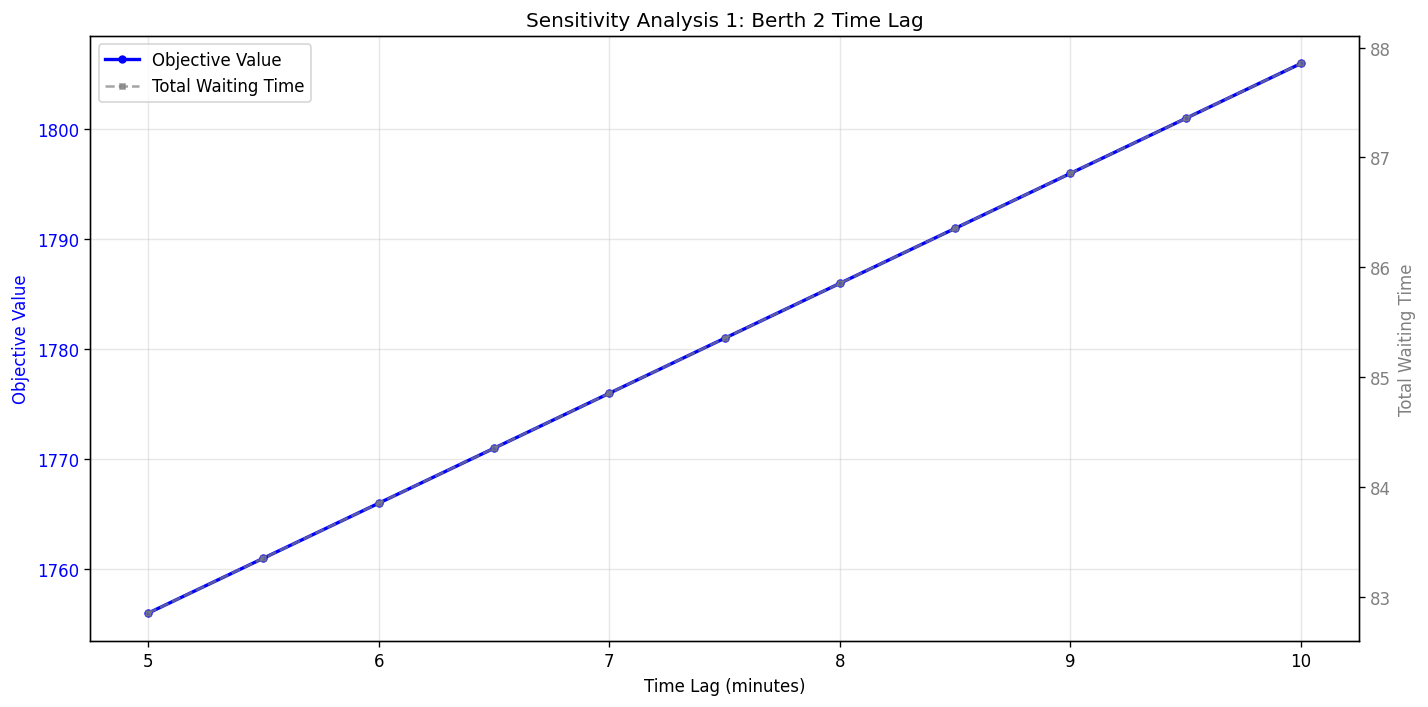


Assignment Matrix for Sensitivity Analysis 1: Berth 2 Time Lag:


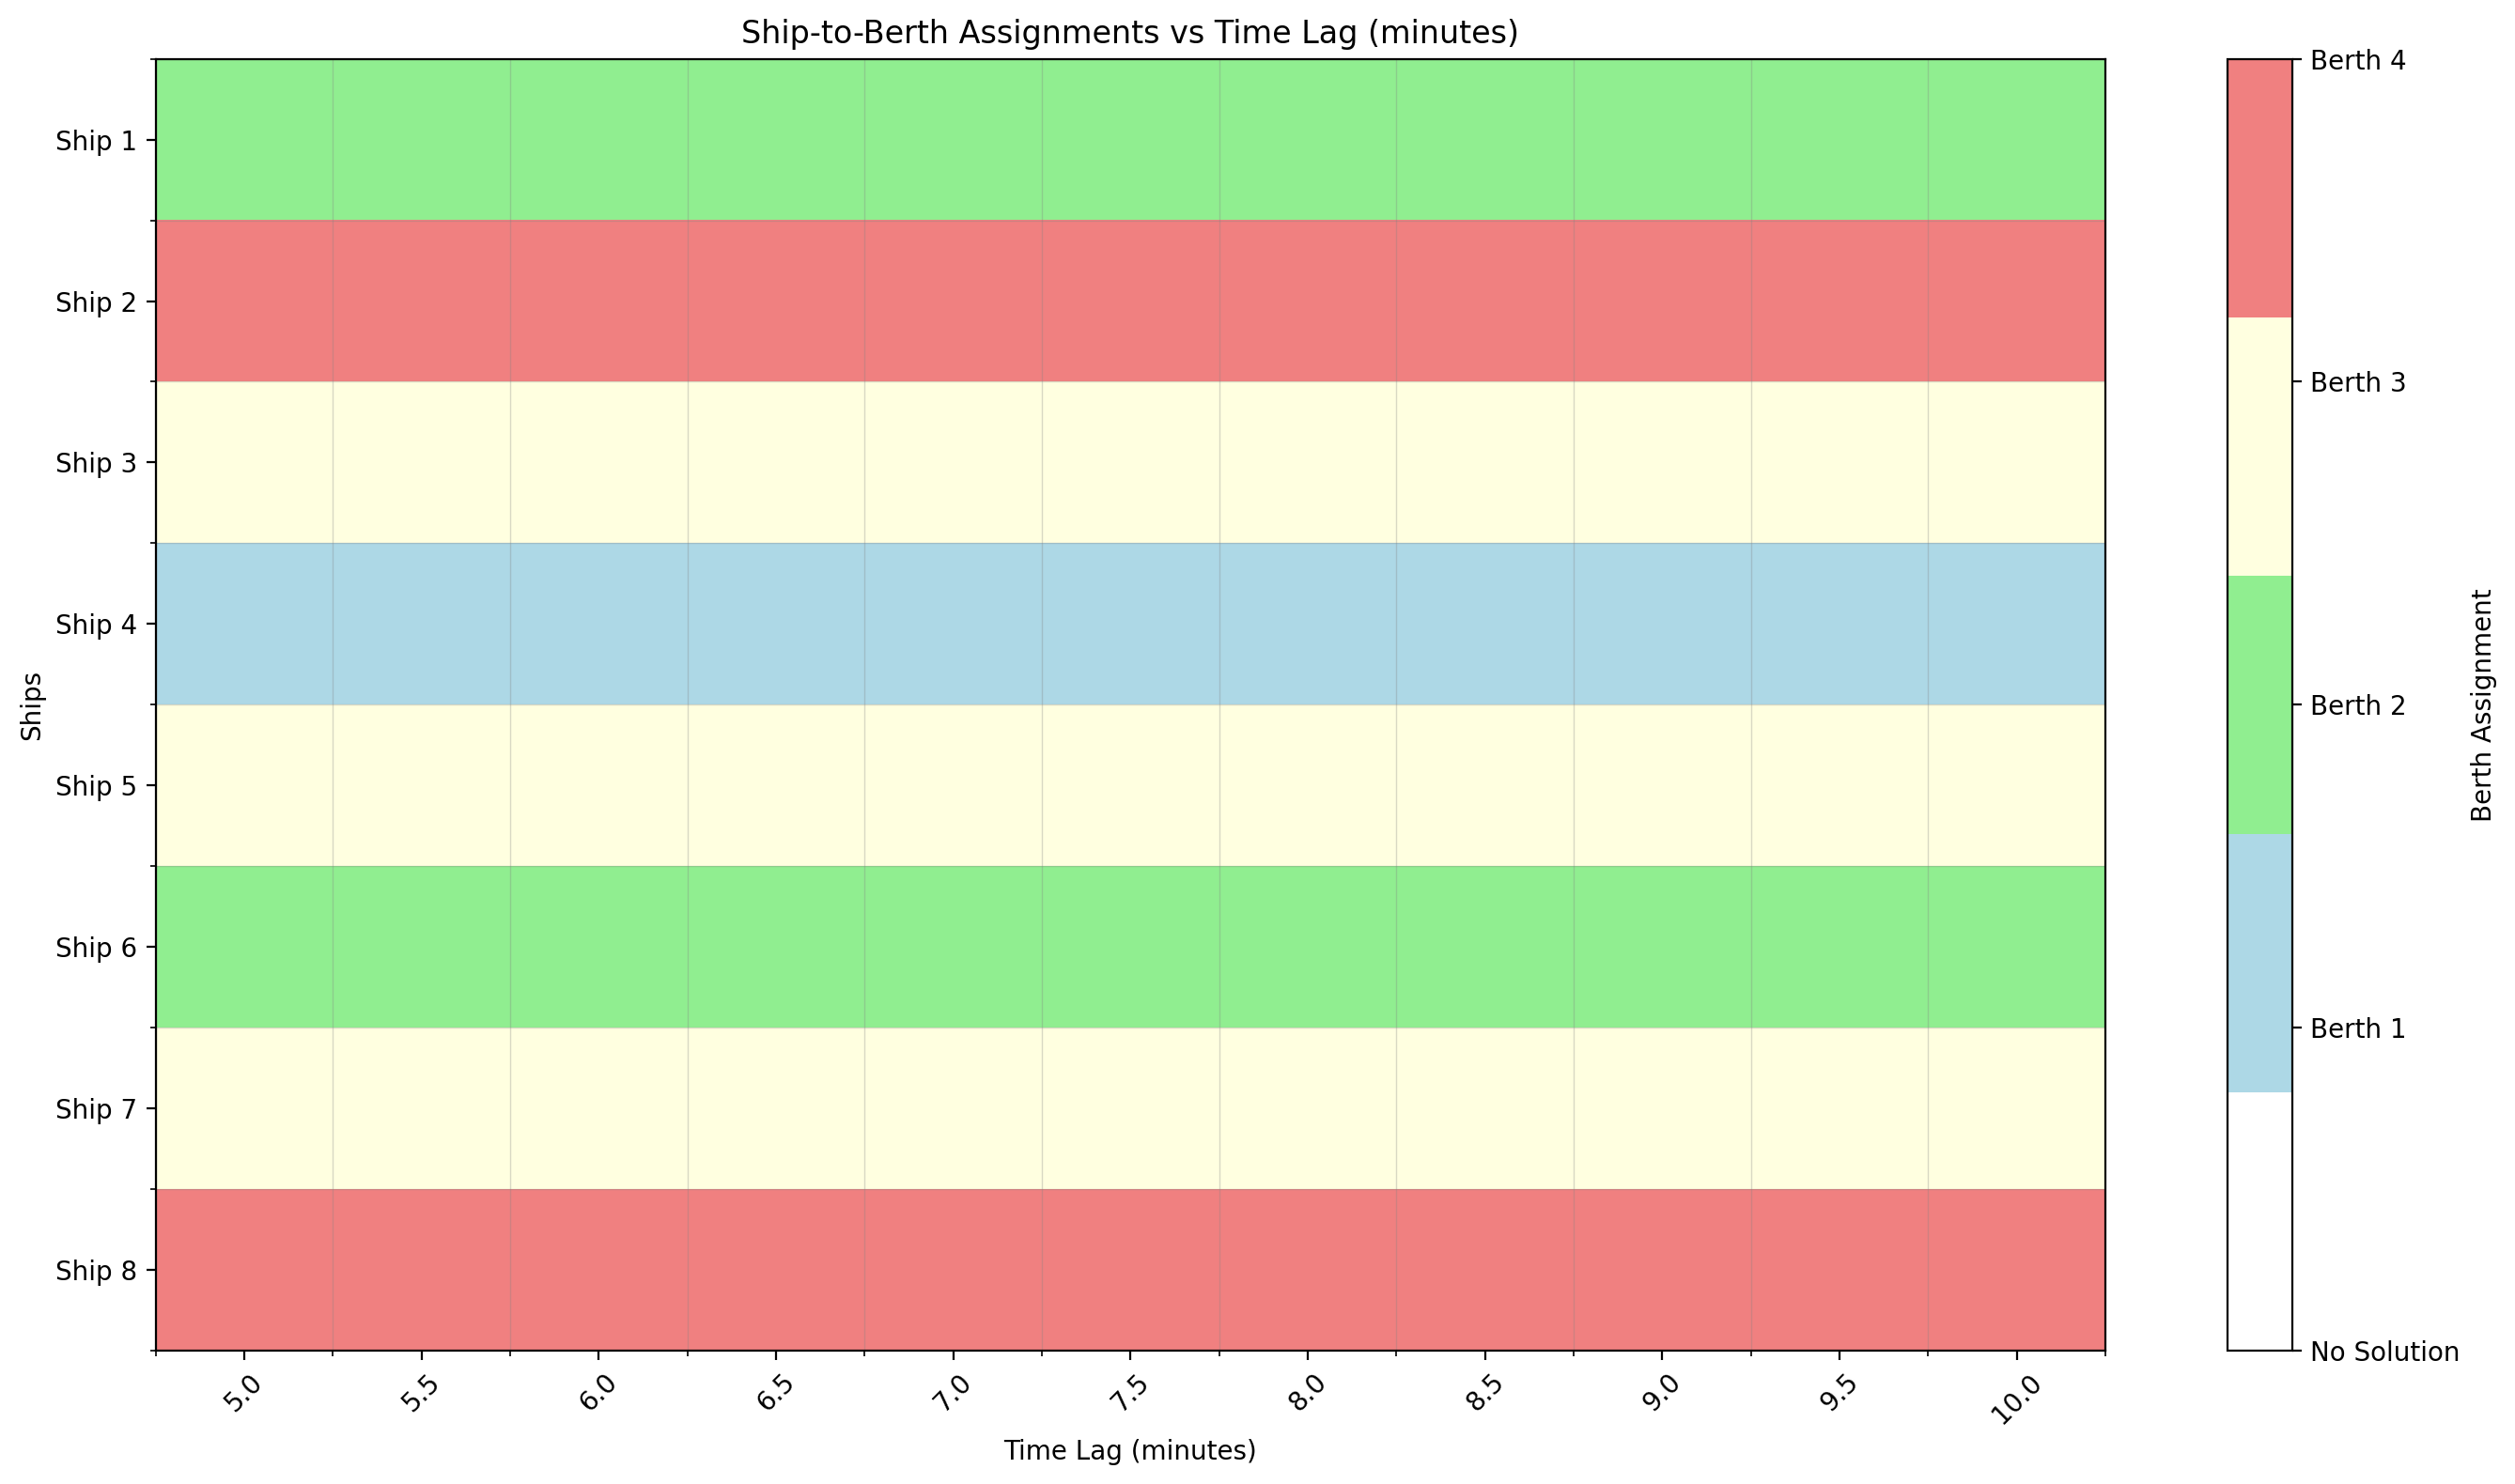

,Parameter_Value,Objective_Value,Total_Waiting_Time,Assignment_Changed,Status
0,5.0,1755.992348,82.85478,False,optimal
1,5.5,1760.992348,83.35478,False,optimal
2,6.0,1765.992348,83.85478,False,optimal
3,6.5,1770.992348,84.35478,False,optimal
4,7.0,1775.992348,84.85478,False,optimal


In [32]:
results_1 = []
assignments_1 = []
lag_values = np.arange(5.0, 10.5, 0.5)

for lag_val in lag_values:
    model = build_model()
    model.delta[2] = lag_val

    result = solve_model(model)
    assignment_changed, changes = compare_assignments(BASE_ASSIGNMENTS, result['assignments'])

    results_1.append({
        'Parameter_Value': lag_val,
        'Objective_Value': result['objective'],
        'Total_Waiting_Time': result['total_waiting_time'],
        'Assignment_Changed': assignment_changed,
        'Status': result['status']
    })
    assignments_1.append(result['assignments'])

df_1 = pd.DataFrame(results_1)
create_sensitivity_plot(df_1, 'Sensitivity Analysis 1: Berth 2 Time Lag',
                       'Time Lag (minutes)', 1, 'blue', assignments_1, lag_values, 'Time Lag (minutes)')
df_1.head()

### Part 2 - Unload time of Ship 7 at Berth 3:

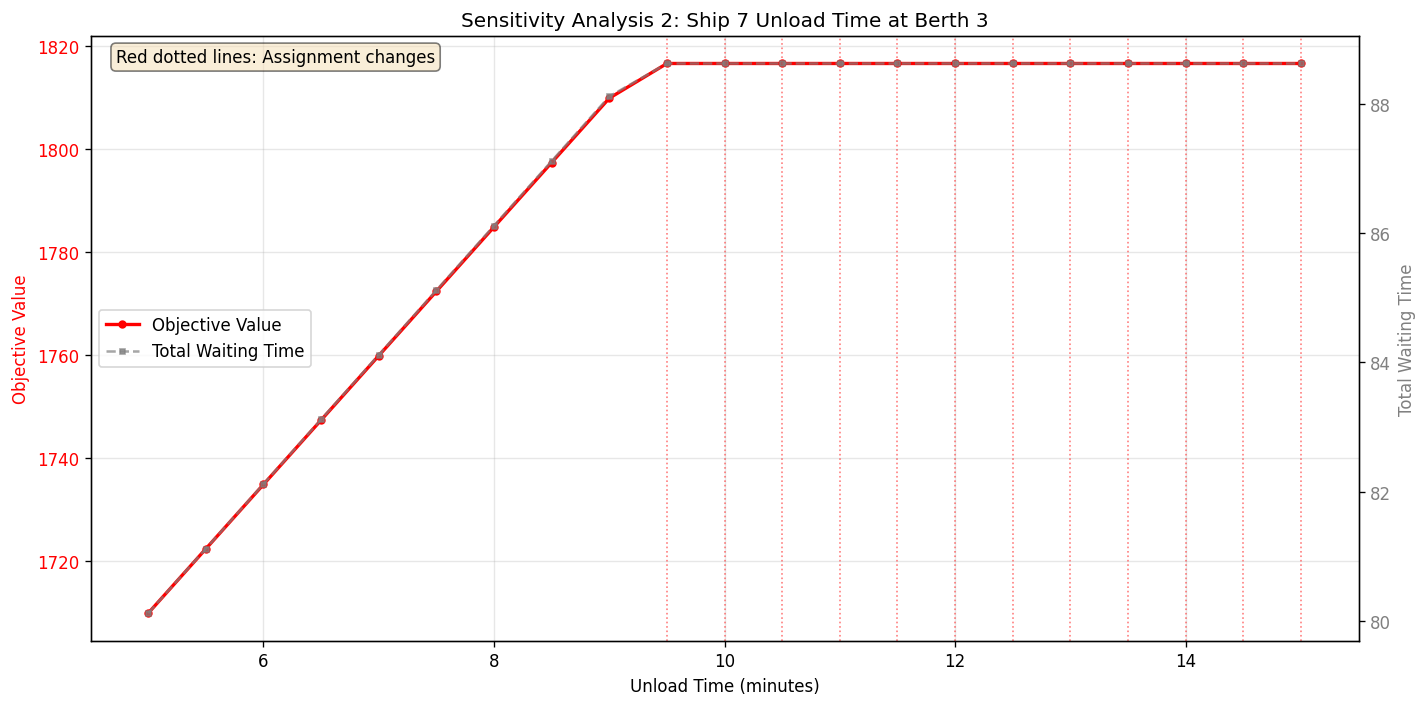


Assignment Matrix for Sensitivity Analysis 2: Ship 7 Unload Time at Berth 3:


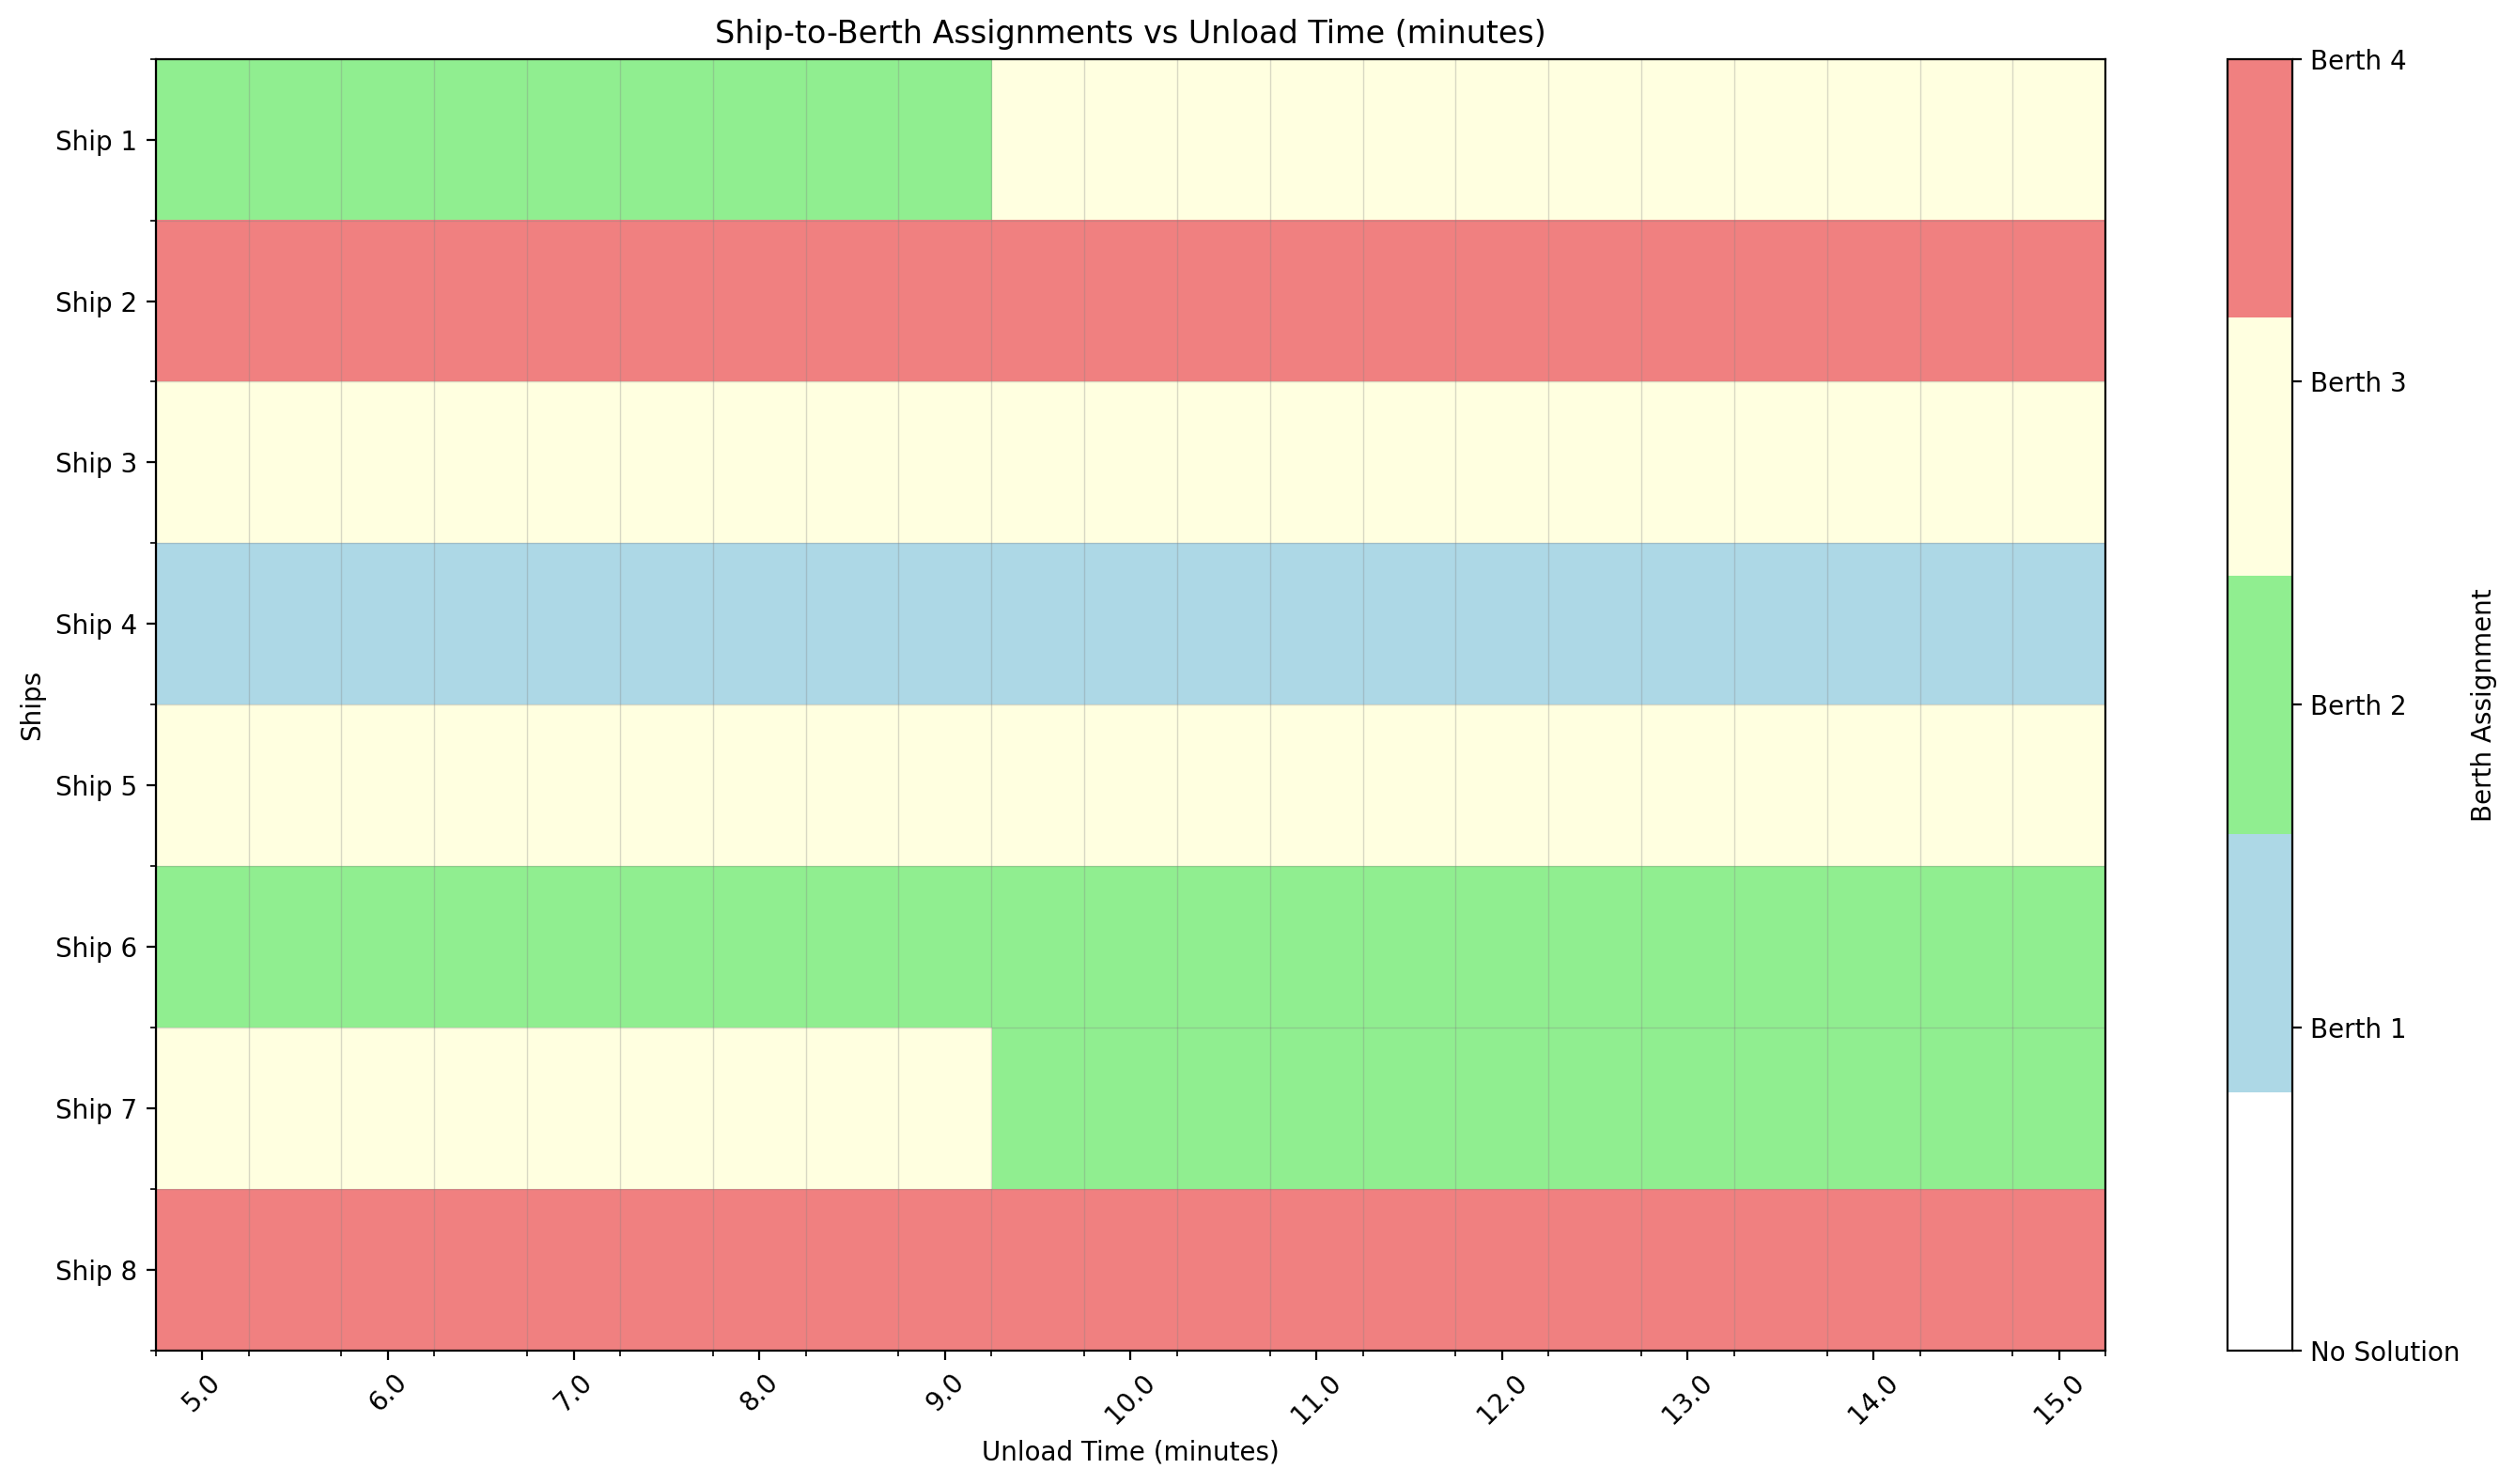


Detailed Assignment Changes for Sensitivity Analysis 2: Ship 7 Unload Time at Berth 3:


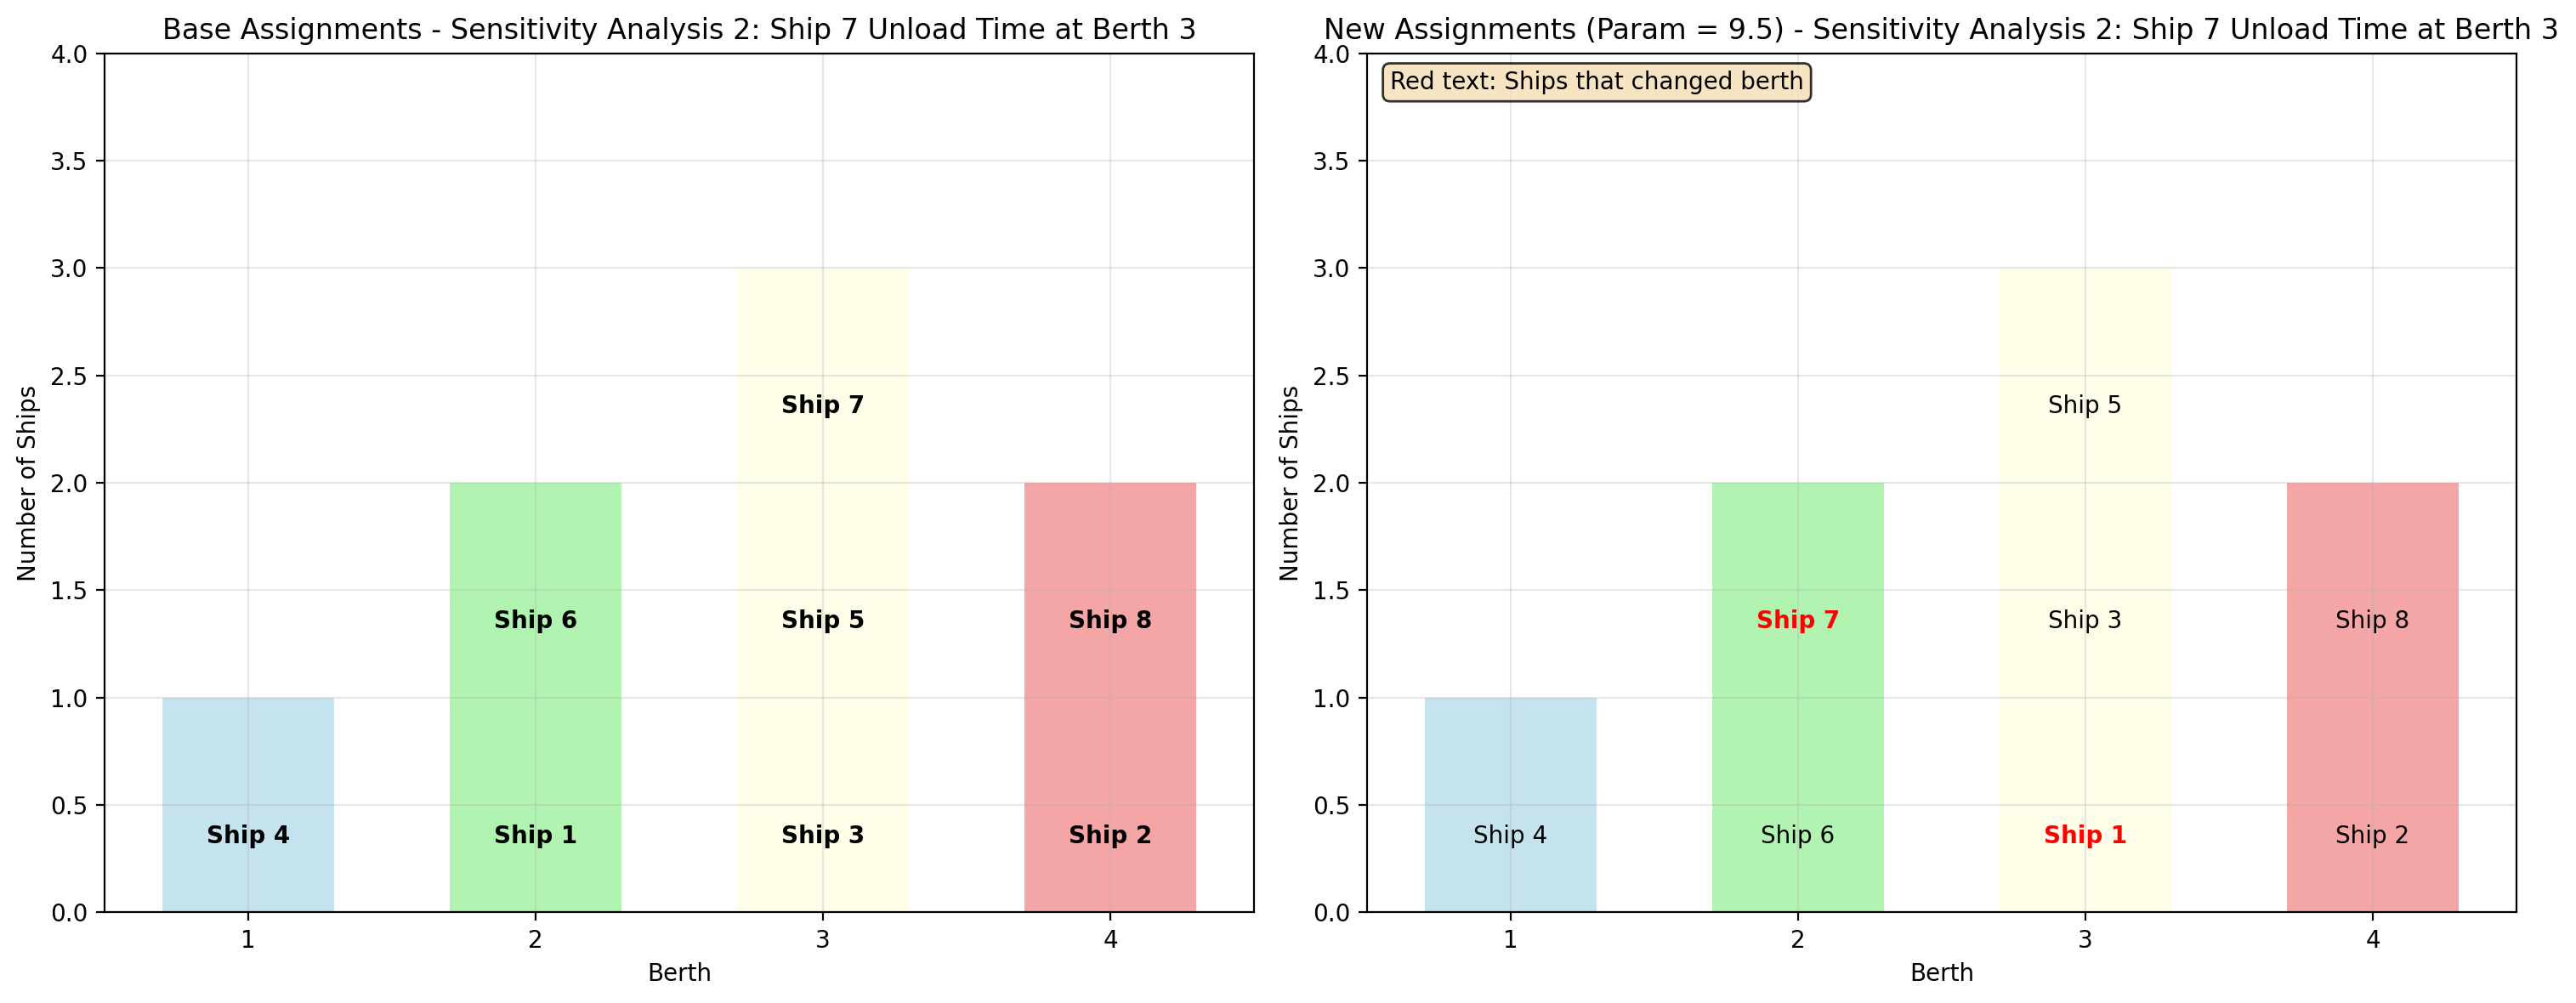

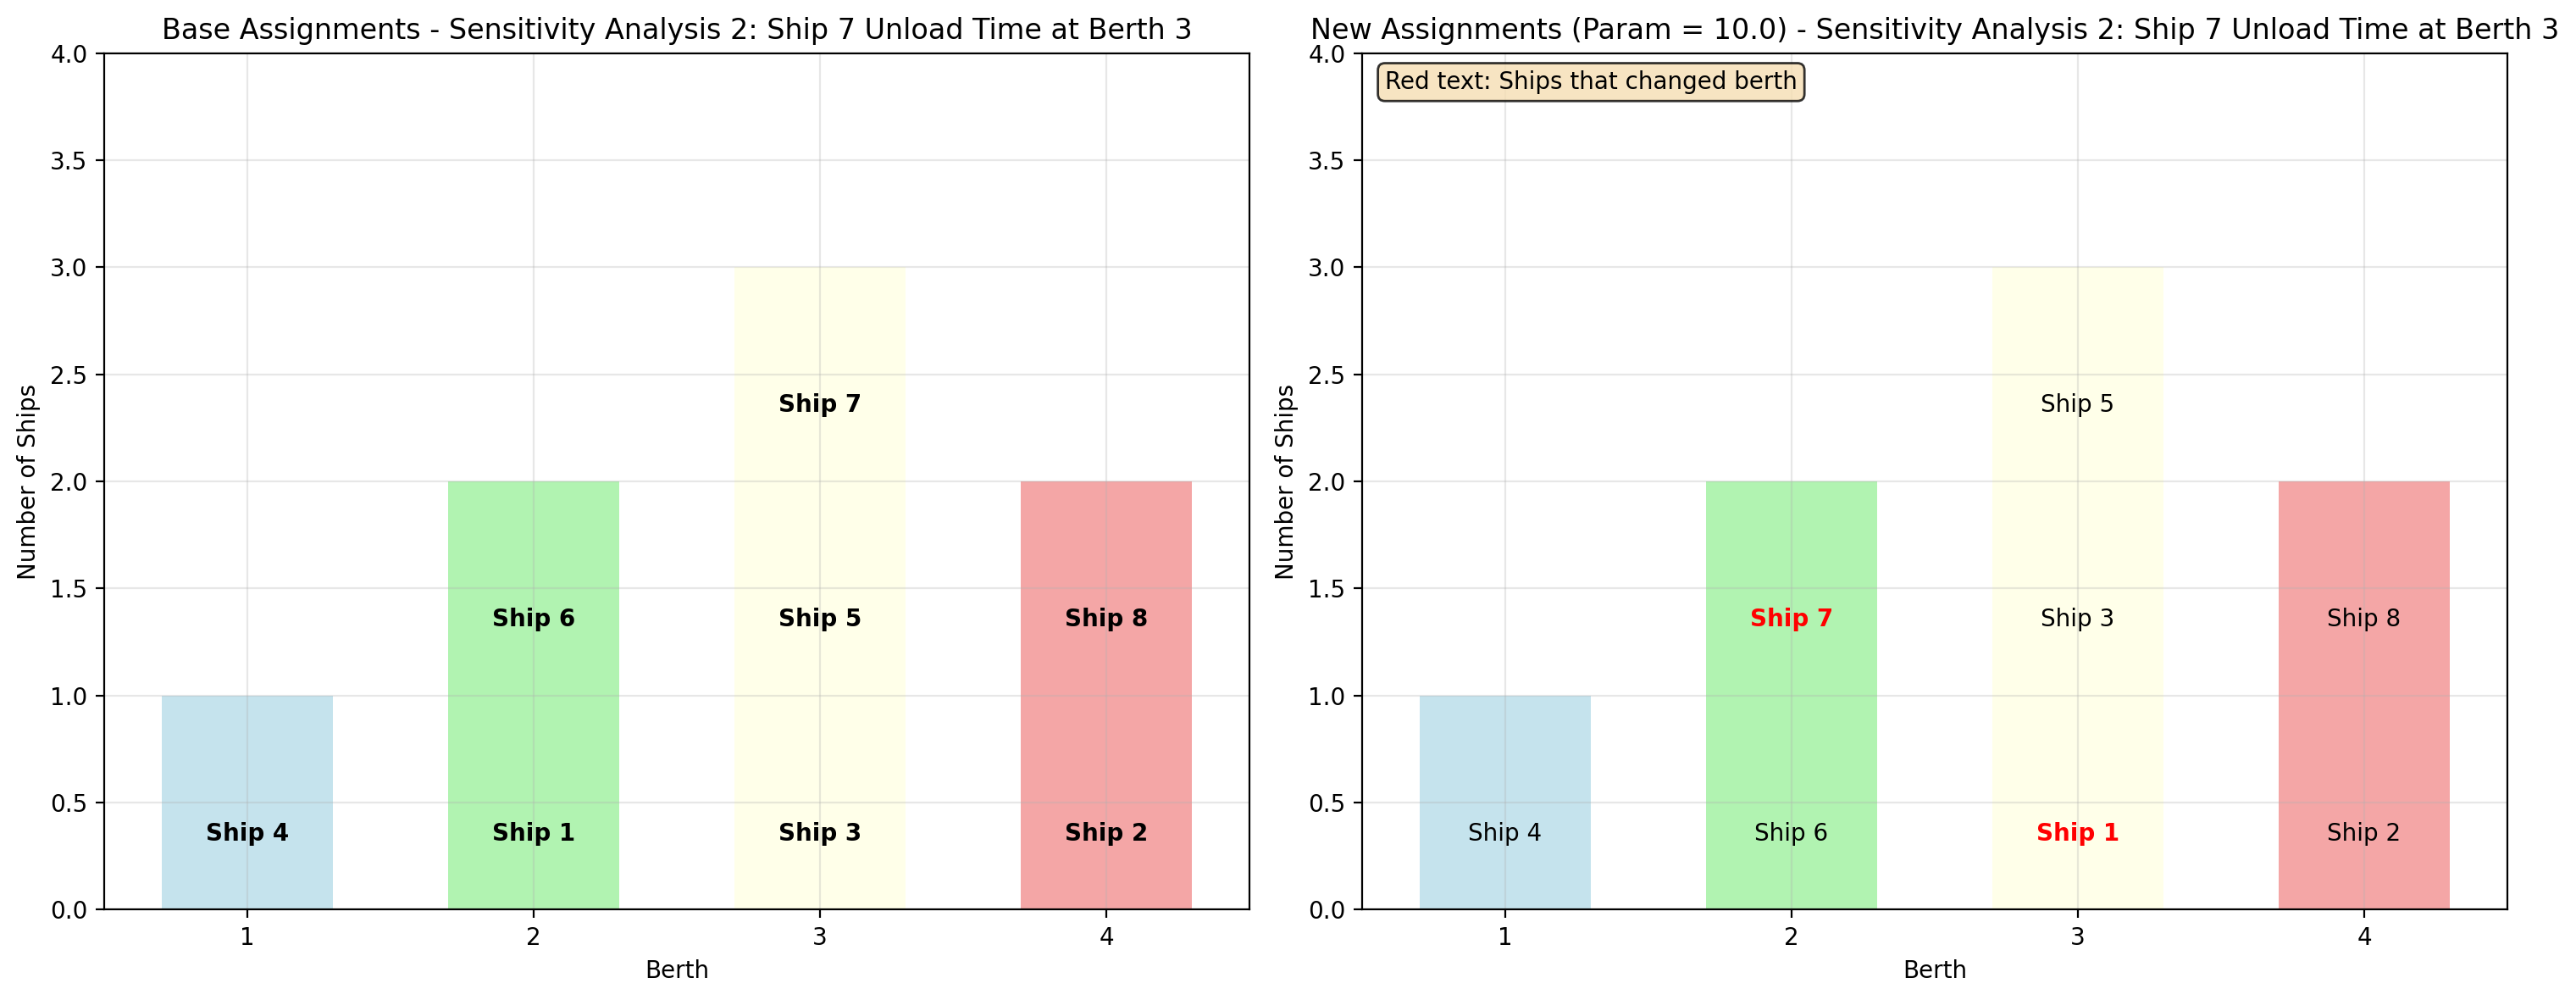

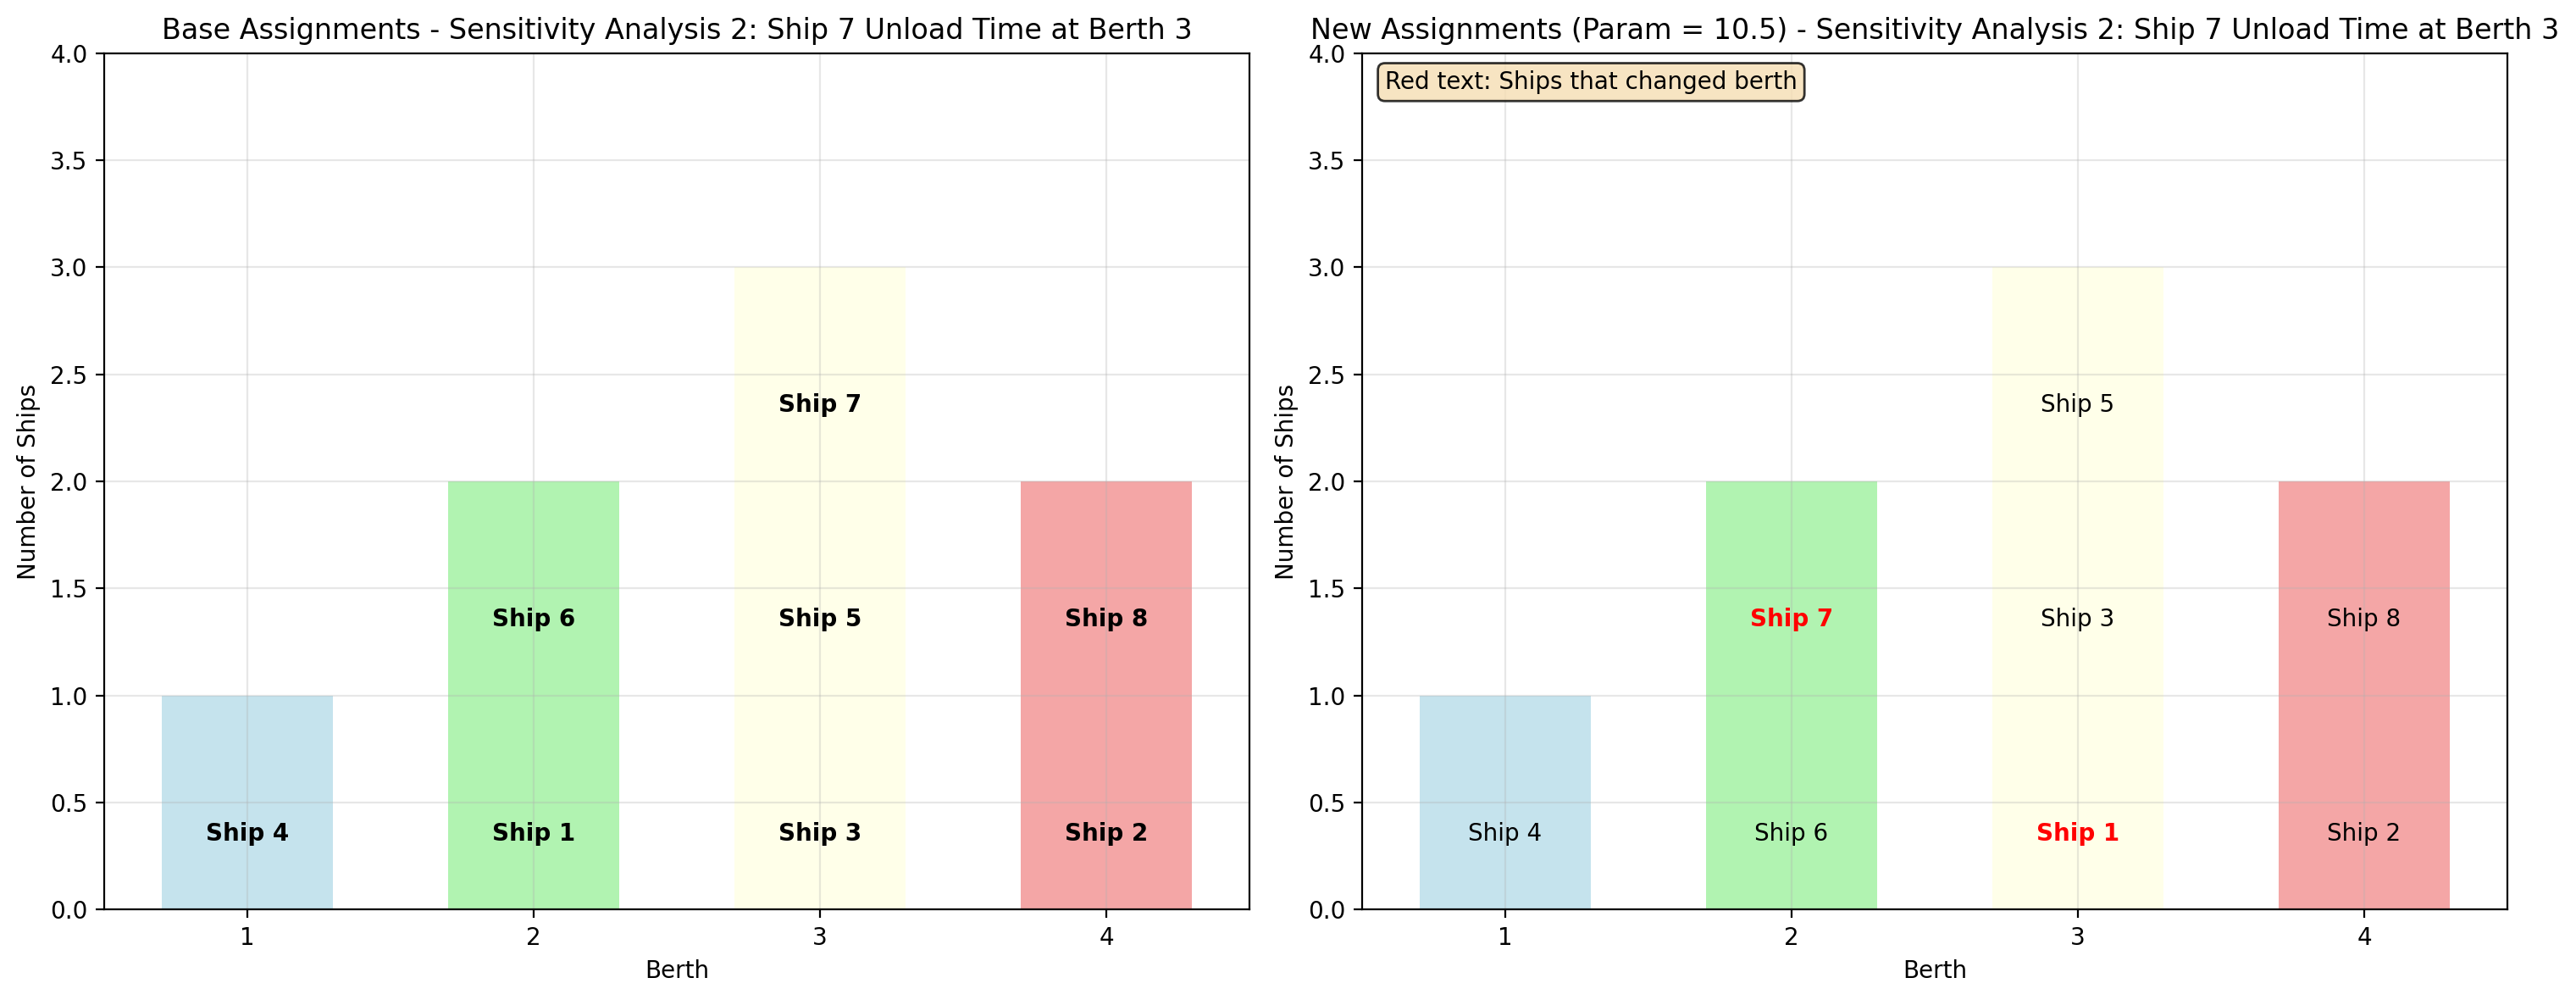

,Parameter_Value,Objective_Value,Total_Waiting_Time,Assignment_Changed,Status
0,5.0,1709.963321,80.118023,False,optimal
1,5.5,1722.463321,81.118023,False,optimal
2,6.0,1734.963321,82.118023,False,optimal
3,6.5,1747.463321,83.118023,False,optimal
4,7.0,1759.963321,84.118023,False,optimal


In [33]:
results_2 = []
assignments_2 = []
unload_values = np.arange(5.0, 15.5, 0.5)

for unload_val in unload_values:
    model = build_model()
    model.T[7, 3] = unload_val

    result = solve_model(model)
    assignment_changed, changes = compare_assignments(BASE_ASSIGNMENTS, result['assignments'])

    results_2.append({
        'Parameter_Value': unload_val,
        'Objective_Value': result['objective'],
        'Total_Waiting_Time': result['total_waiting_time'],
        'Assignment_Changed': assignment_changed,
        'Status': result['status']
    })
    assignments_2.append(result['assignments'])

df_2 = pd.DataFrame(results_2)
create_sensitivity_plot(df_2, 'Sensitivity Analysis 2: Ship 7 Unload Time at Berth 3',
                       'Unload Time (minutes)', 2, 'red', assignments_2, unload_values, 'Unload Time (minutes)')
df_2.head()

### Part 3 - Capacity of Berth 2:

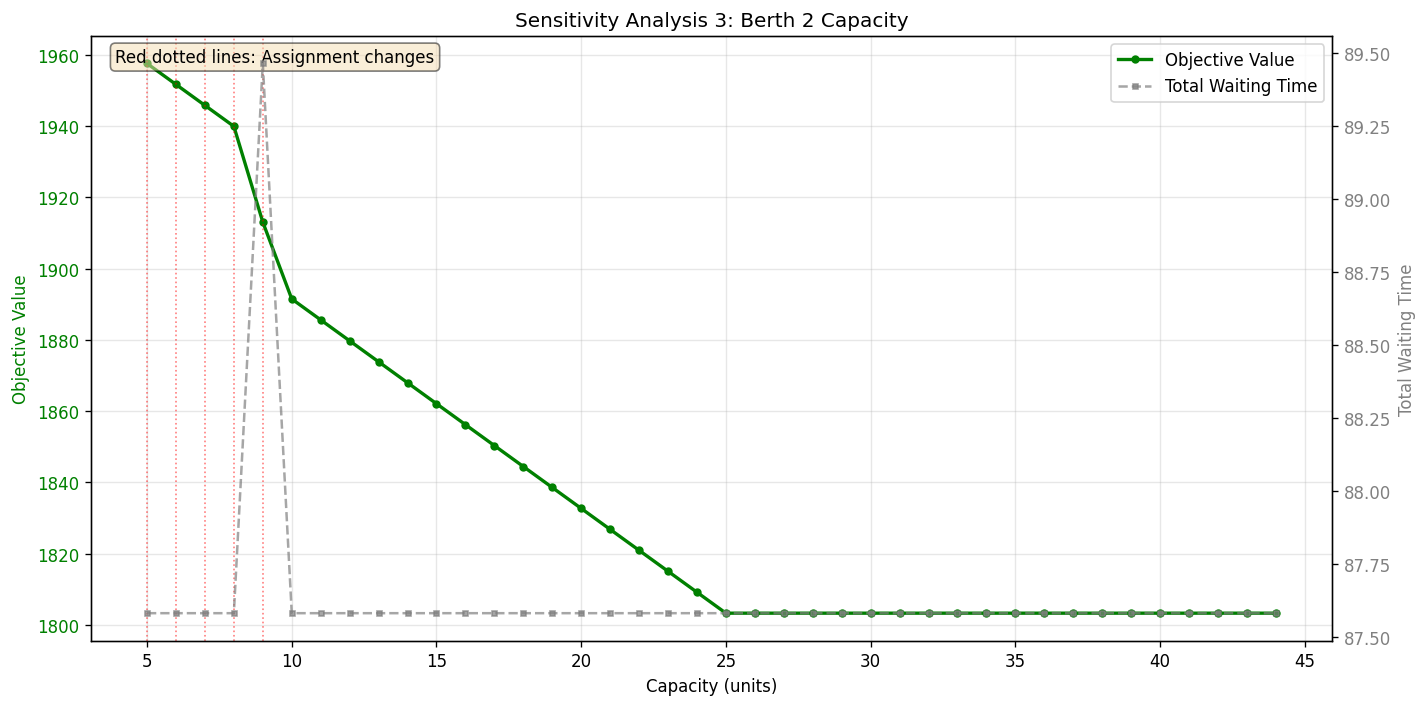


Assignment Matrix for Sensitivity Analysis 3: Berth 2 Capacity:


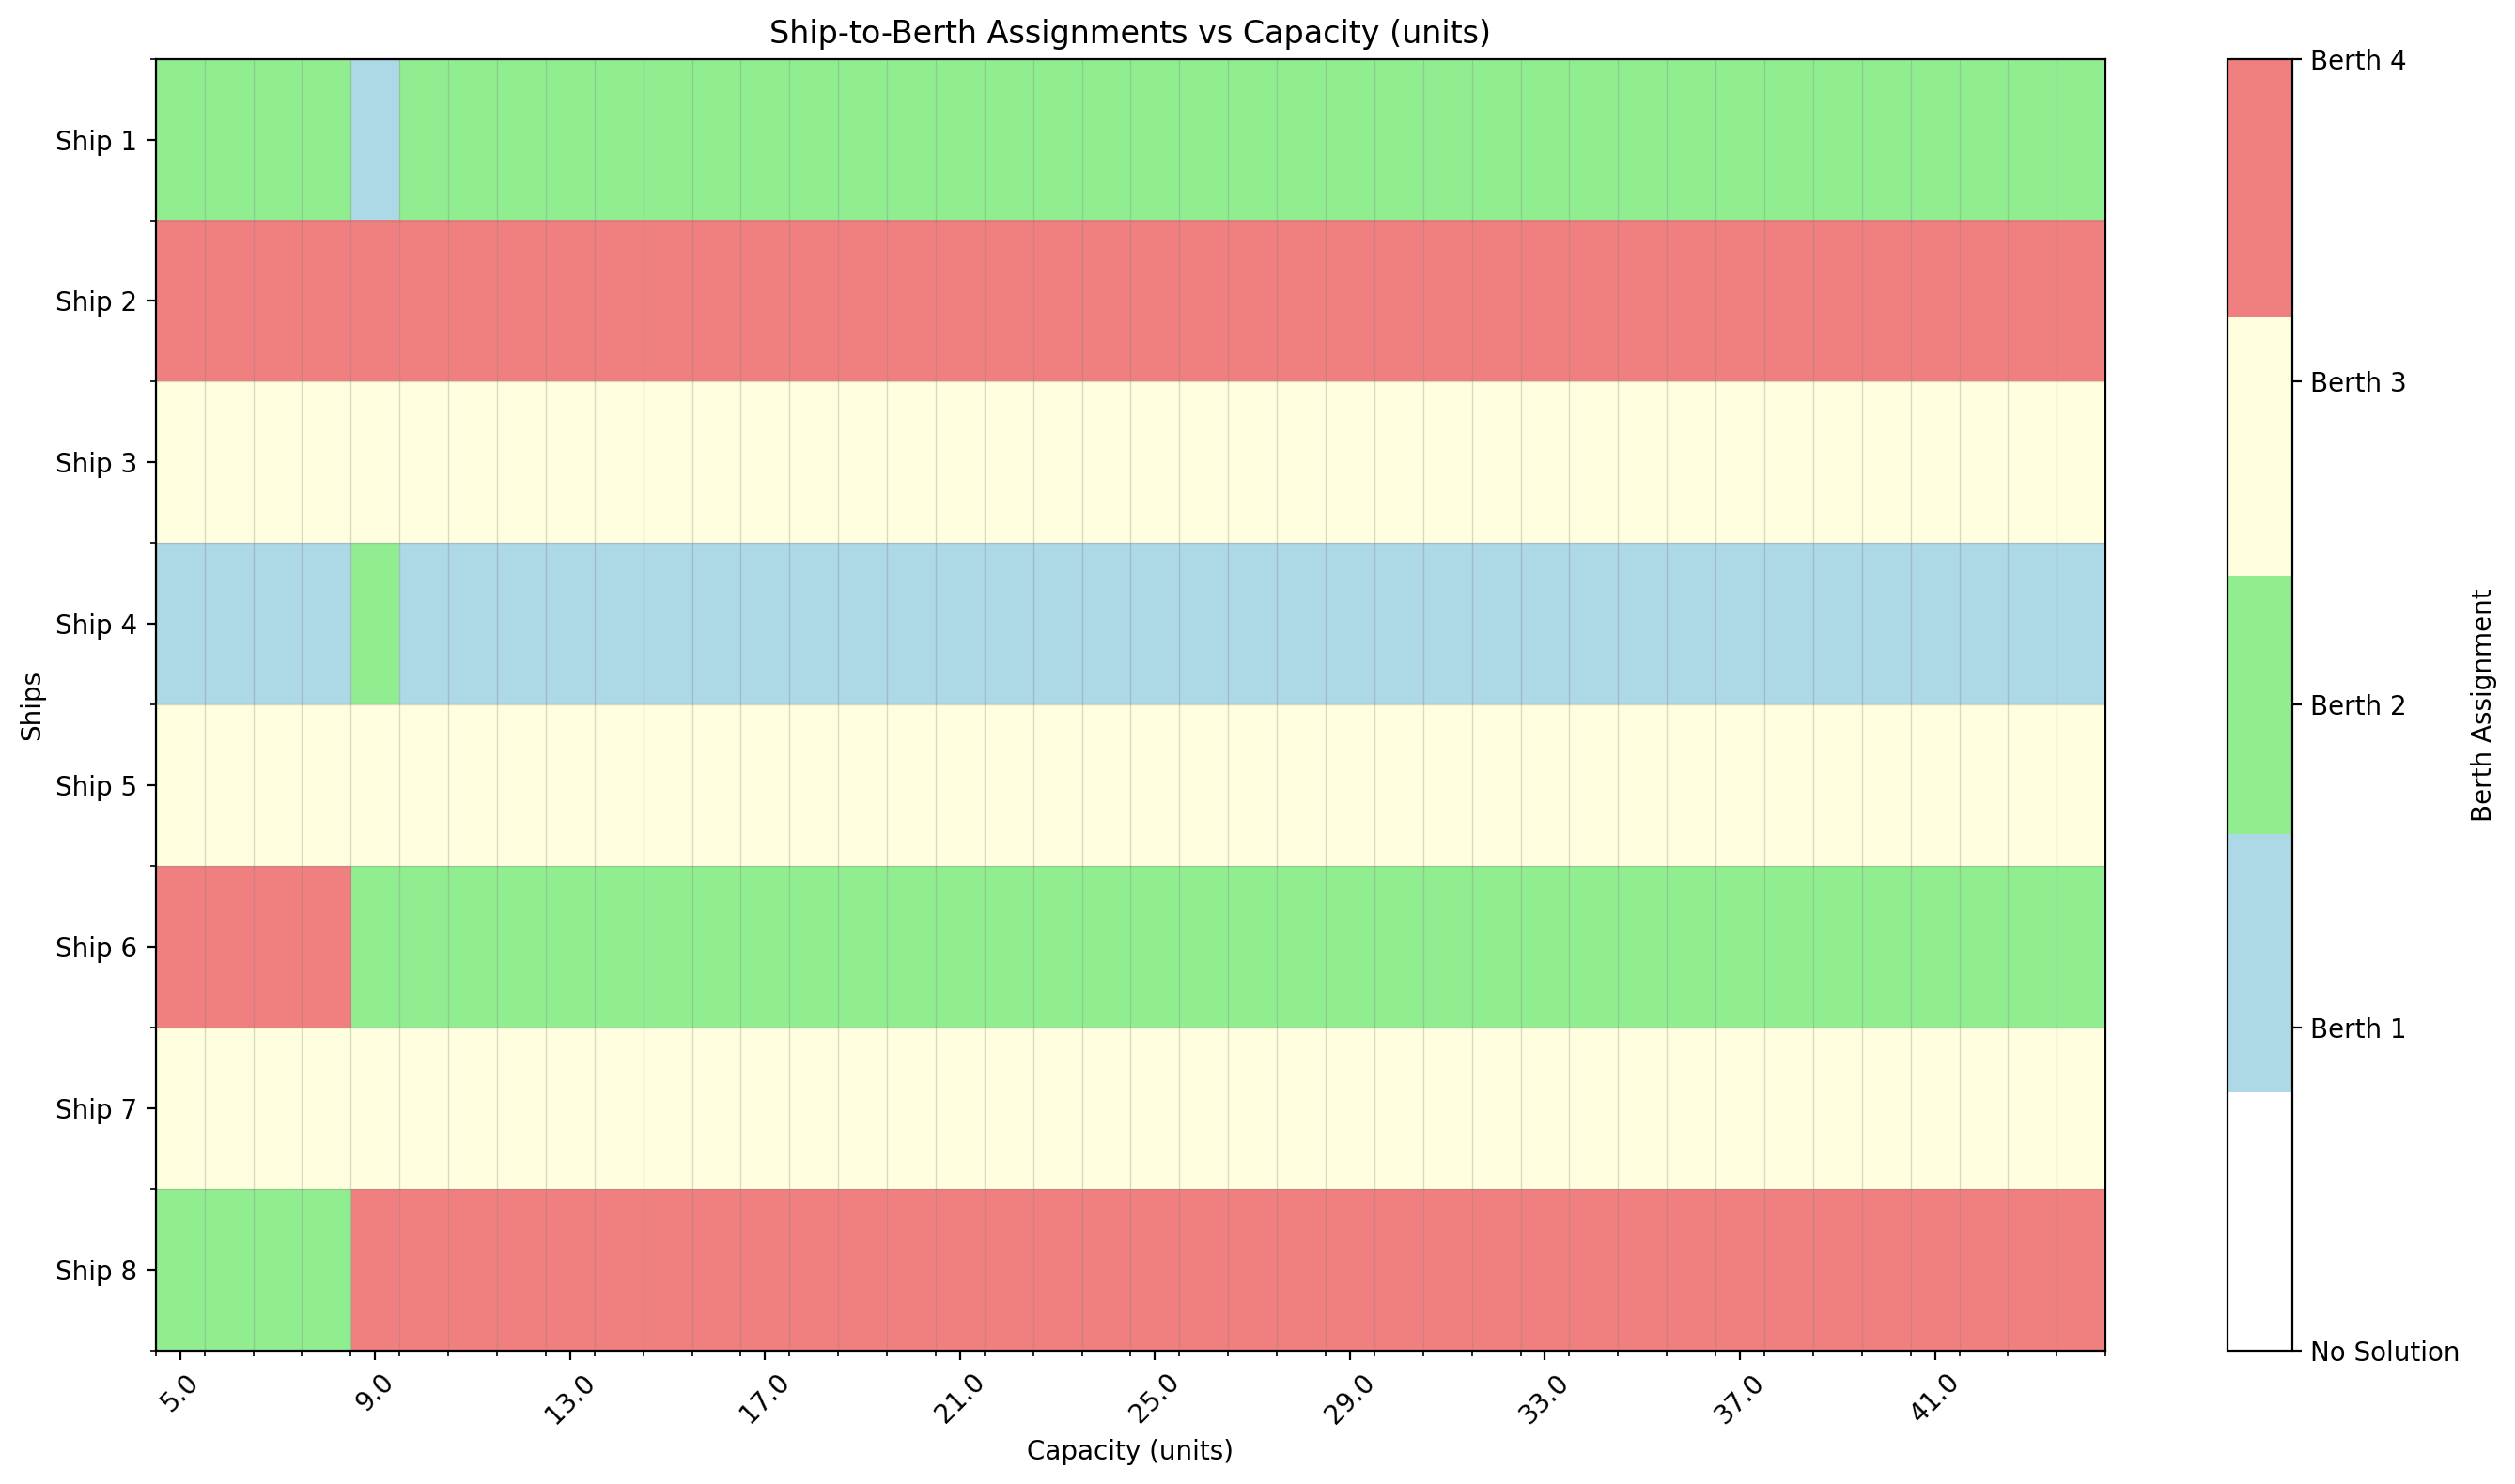


Detailed Assignment Changes for Sensitivity Analysis 3: Berth 2 Capacity:


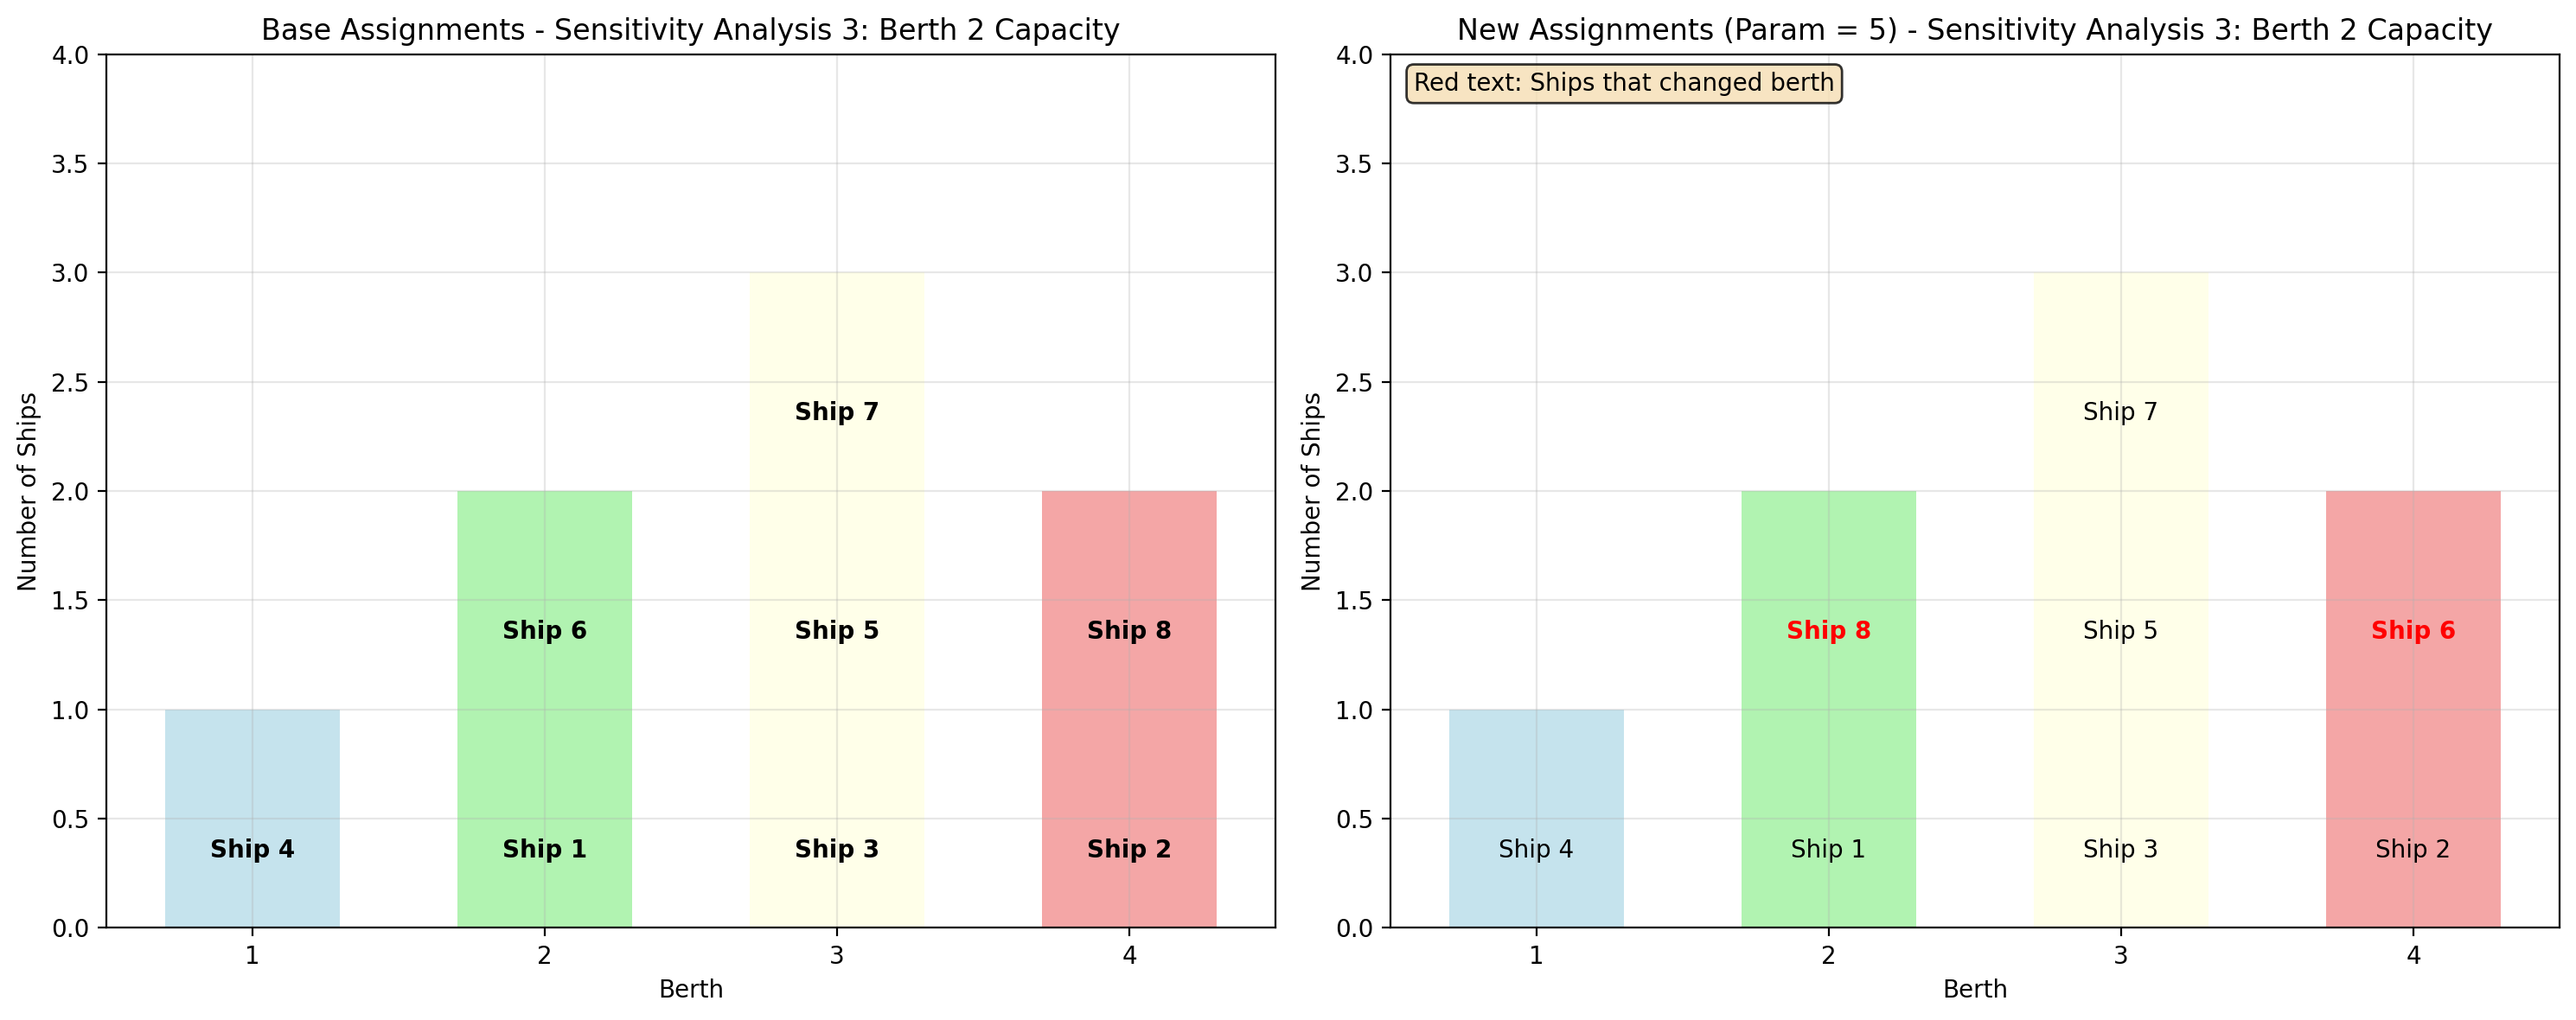

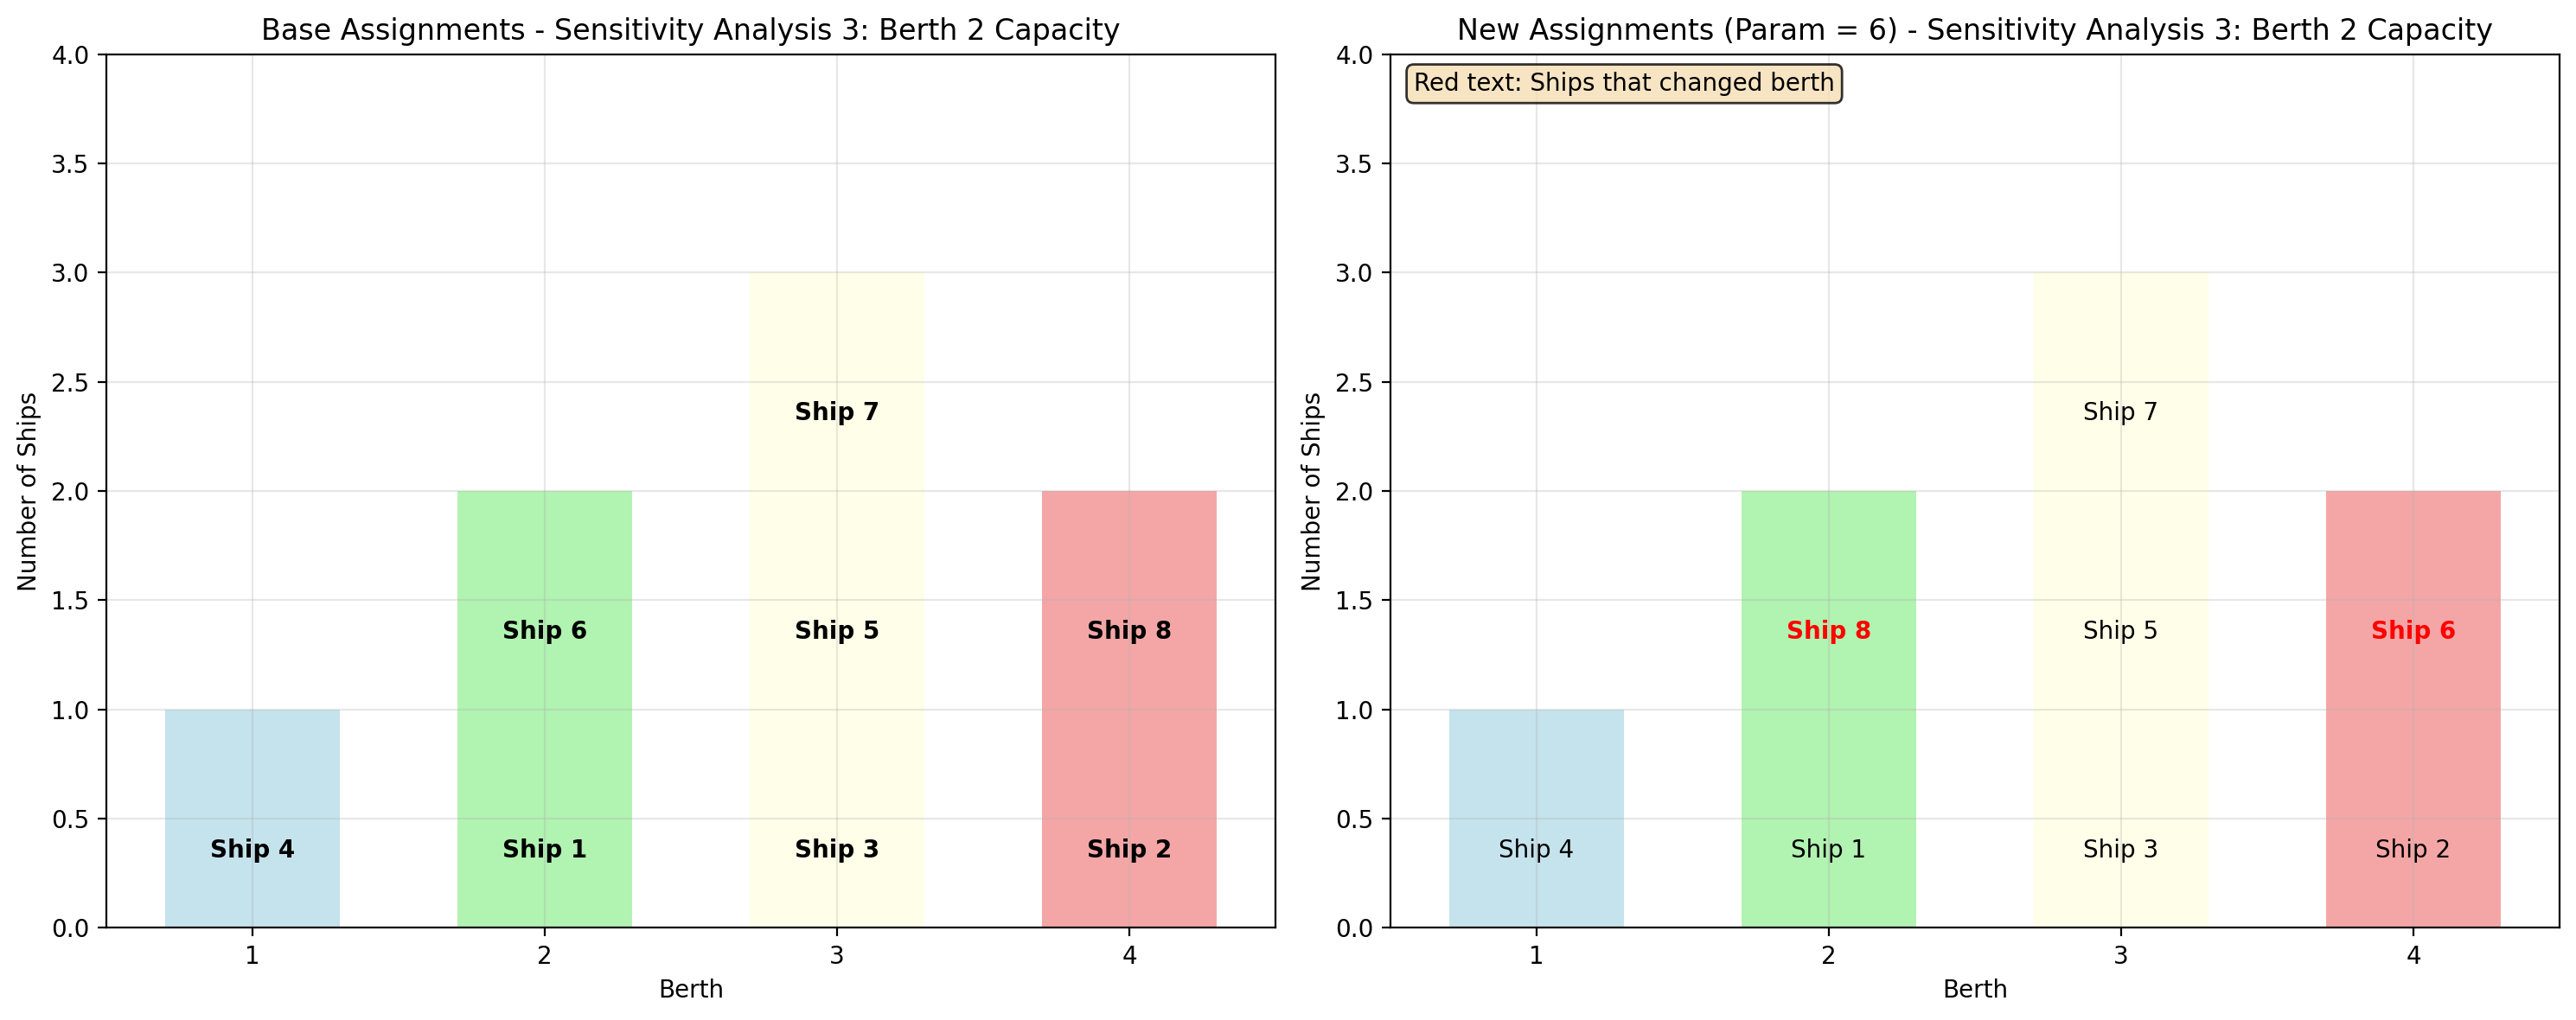

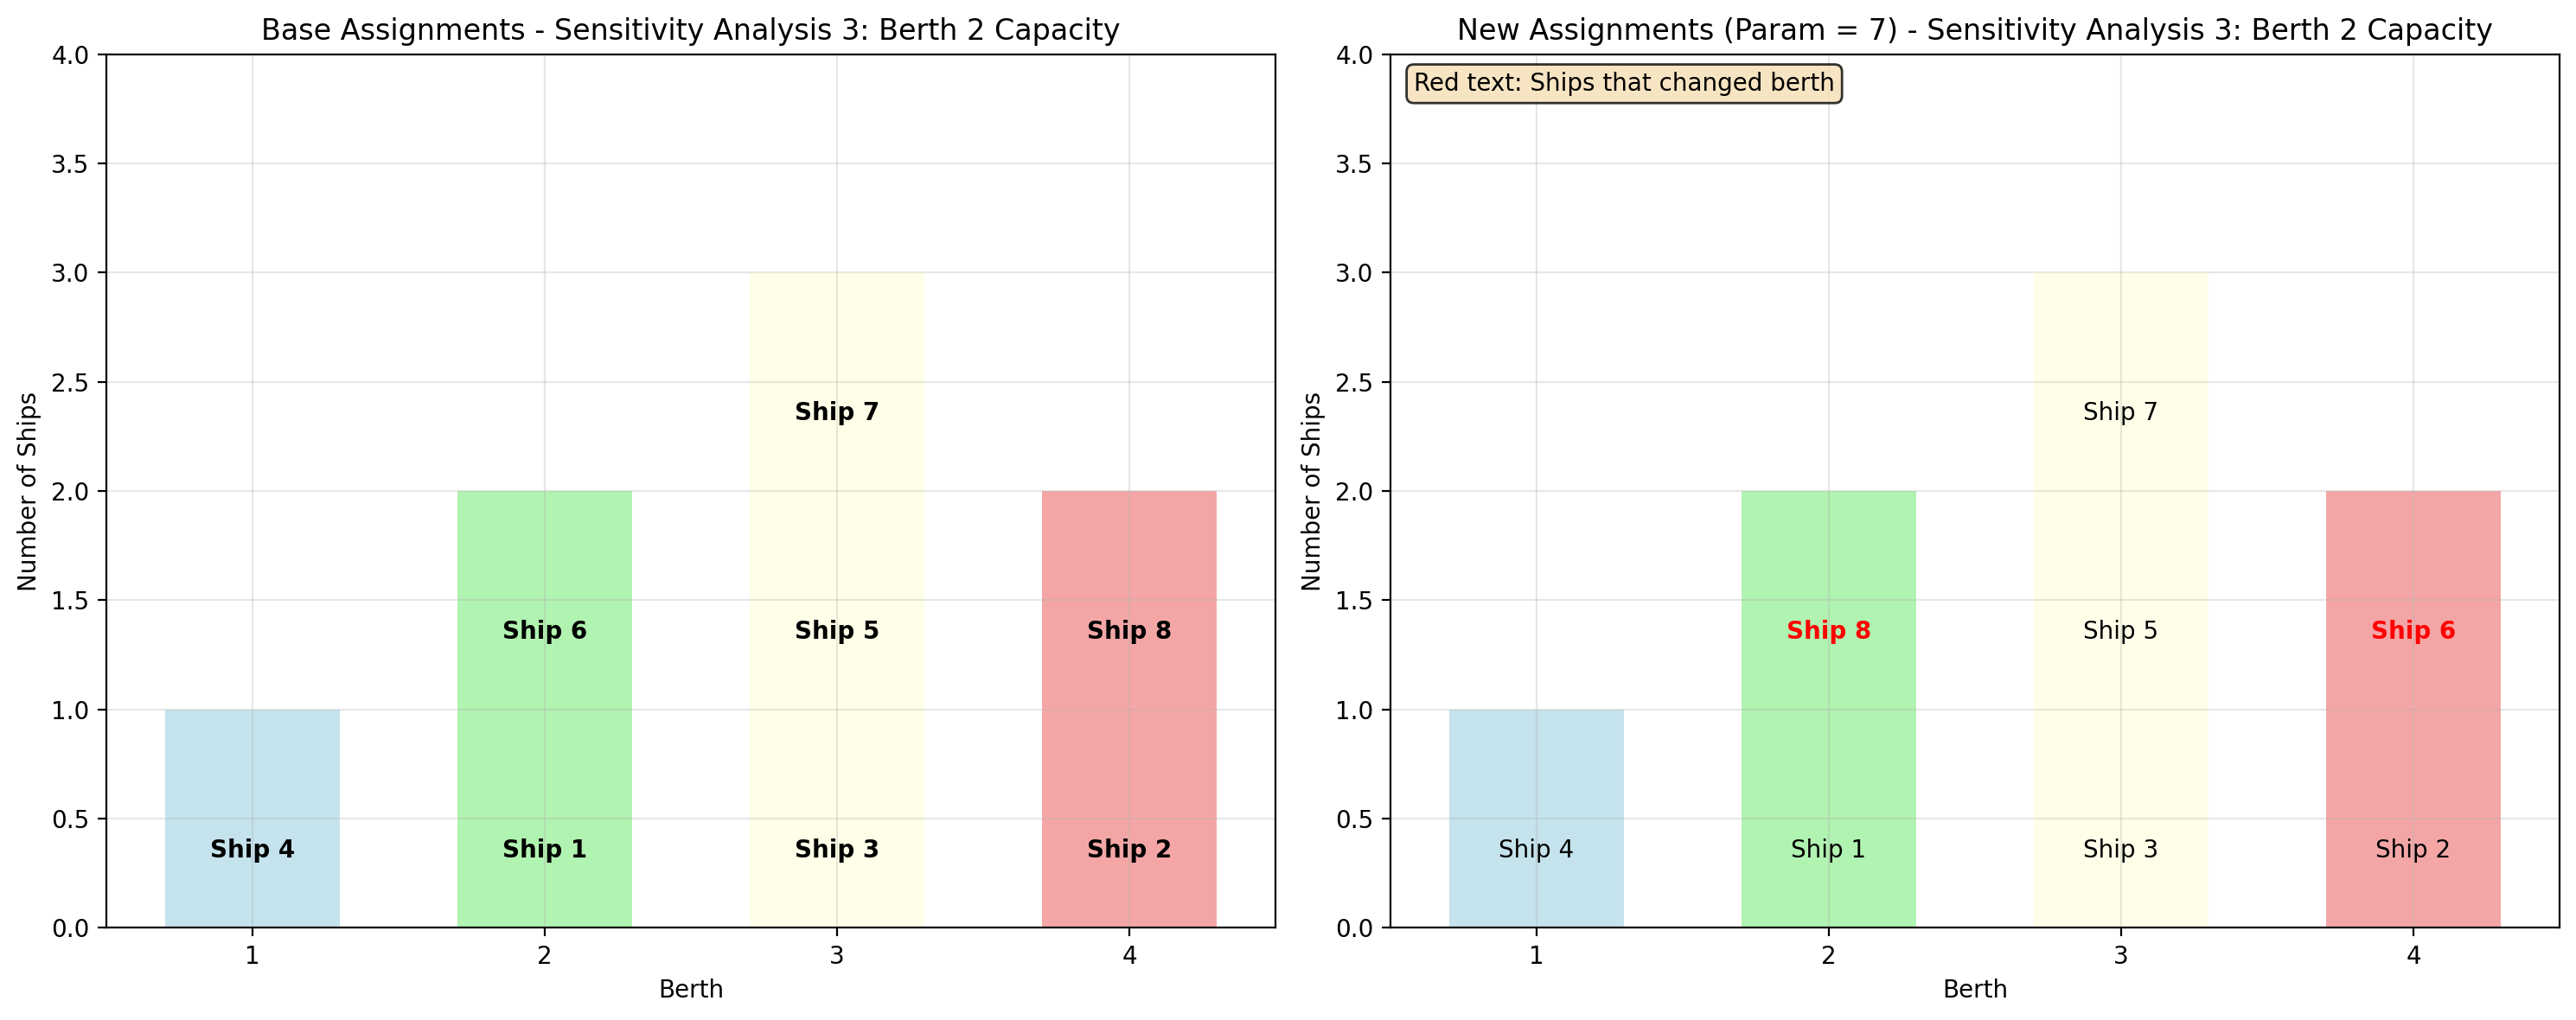

,Parameter_Value,Objective_Value,Total_Waiting_Time,Assignment_Changed,Status
0,5,1957.563252,87.582605,True,optimal
1,6,1951.682805,87.582605,True,optimal
2,7,1945.802358,87.582605,True,optimal
3,8,1939.921910,87.582605,True,optimal
4,9,1913.046946,89.464459,True,optimal


In [34]:
results_3 = []
assignments_3 = []
capacity_values = np.arange(5, 45, 1)

for cap_val in capacity_values:
    model = build_model()
    model.D[2] = cap_val

    result = solve_model(model)
    assignment_changed, changes = compare_assignments(BASE_ASSIGNMENTS, result['assignments'])

    results_3.append({
        'Parameter_Value': cap_val,
        'Objective_Value': result['objective'],
        'Total_Waiting_Time': result['total_waiting_time'],
        'Assignment_Changed': assignment_changed,
        'Status': result['status']
    })
    assignments_3.append(result['assignments'])

df_3 = pd.DataFrame(results_3)
create_sensitivity_plot(df_3, 'Sensitivity Analysis 3: Berth 2 Capacity',
                       'Capacity (units)', 3, 'green', assignments_3, capacity_values, 'Capacity (units)')
df_3.head()

### Part 4 - Capacity of Berth 3:

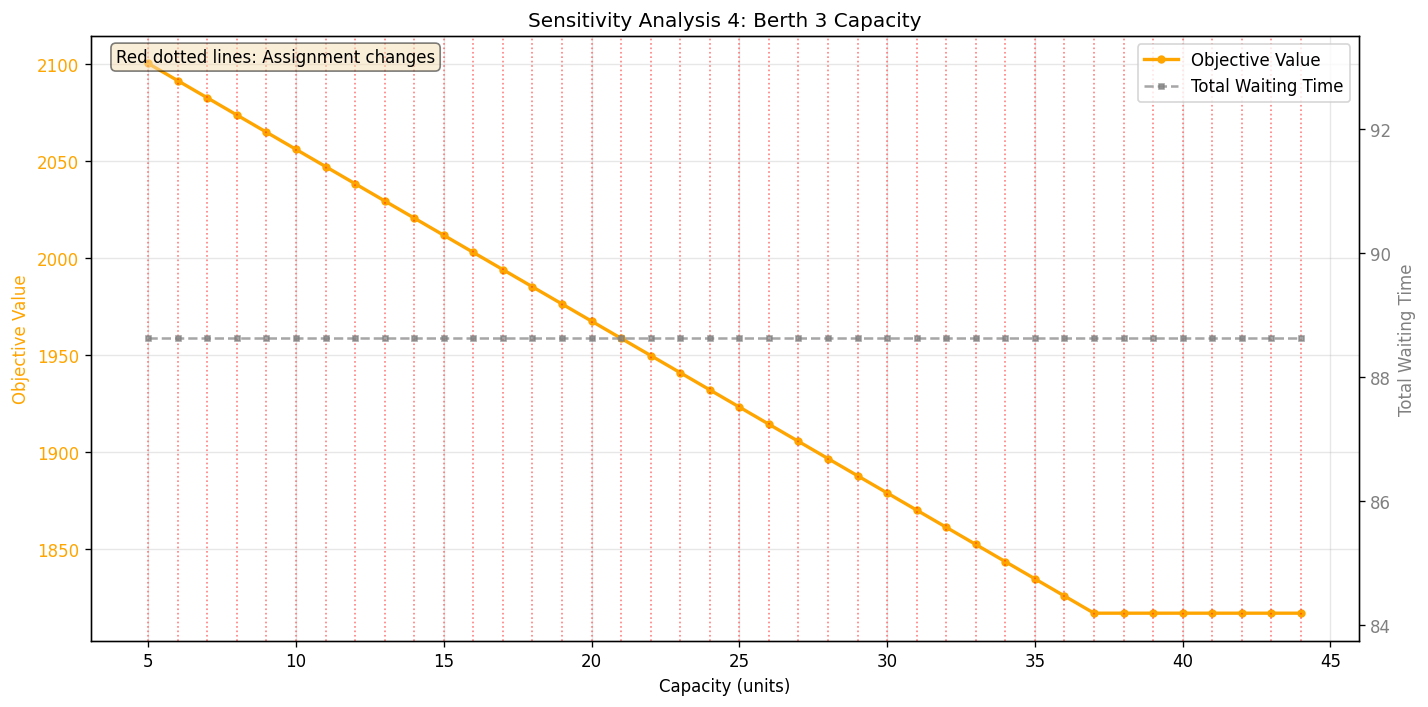


Assignment Matrix for Sensitivity Analysis 4: Berth 3 Capacity:


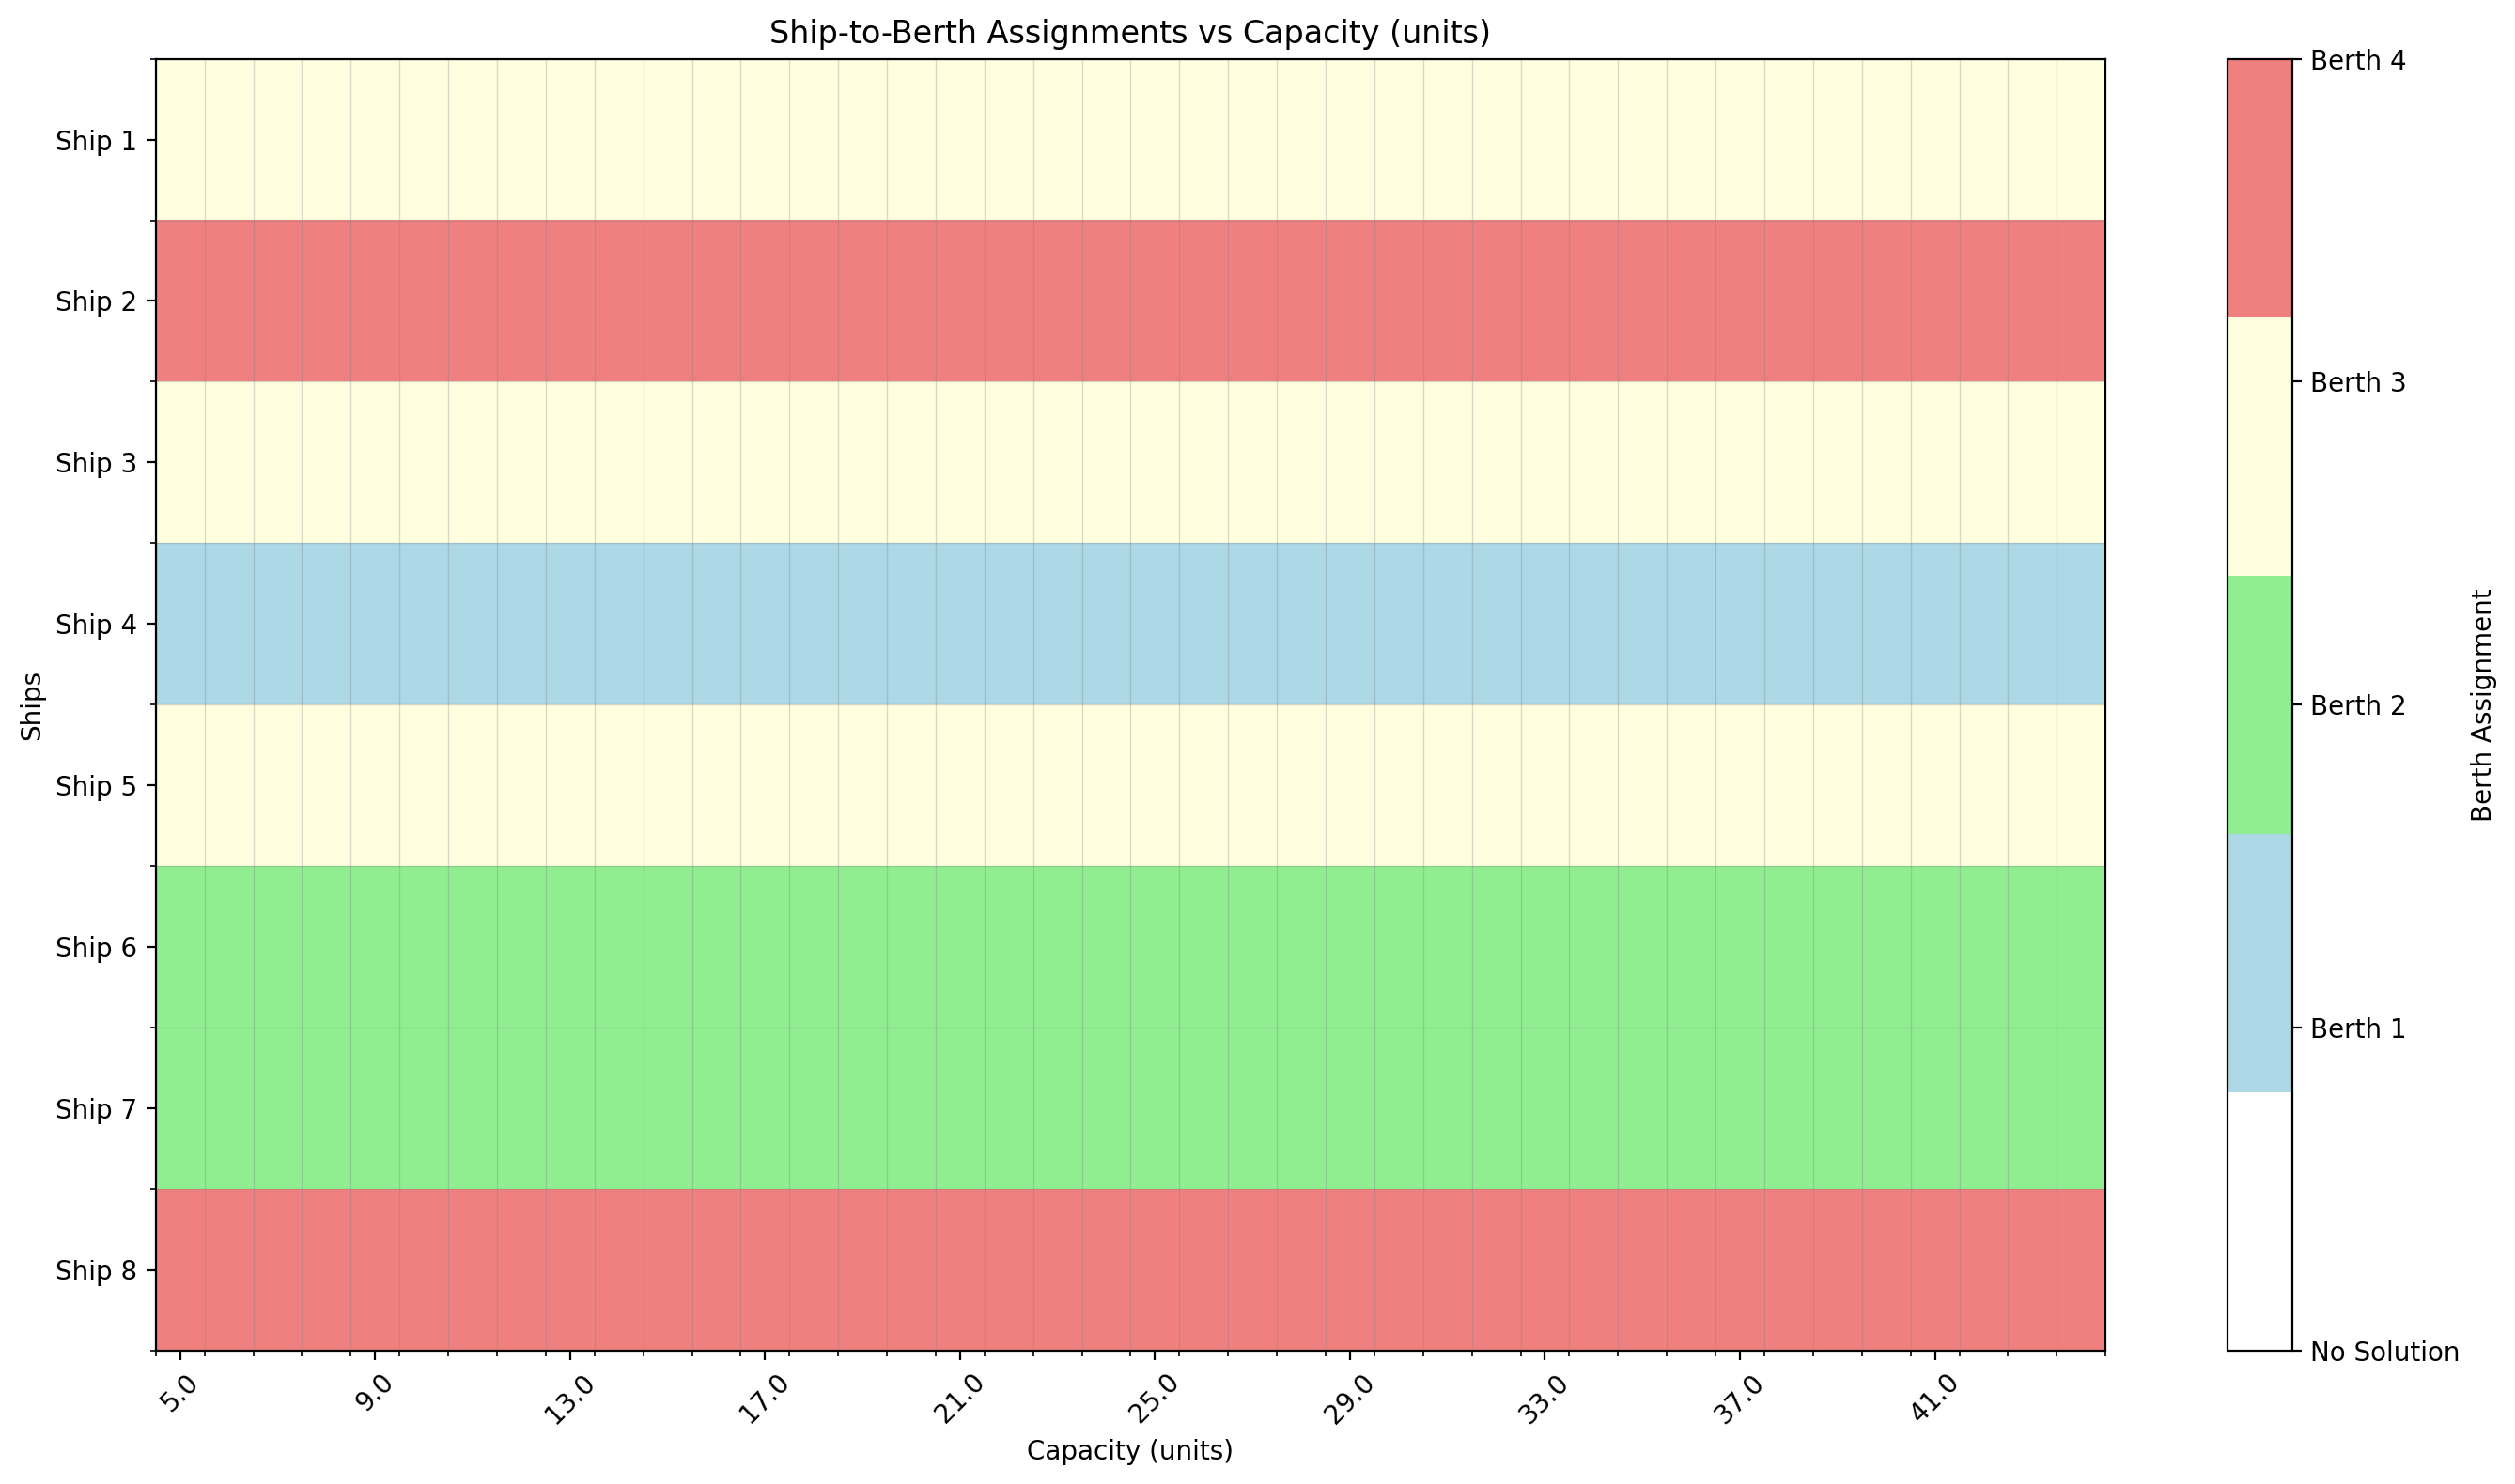


Detailed Assignment Changes for Sensitivity Analysis 4: Berth 3 Capacity:


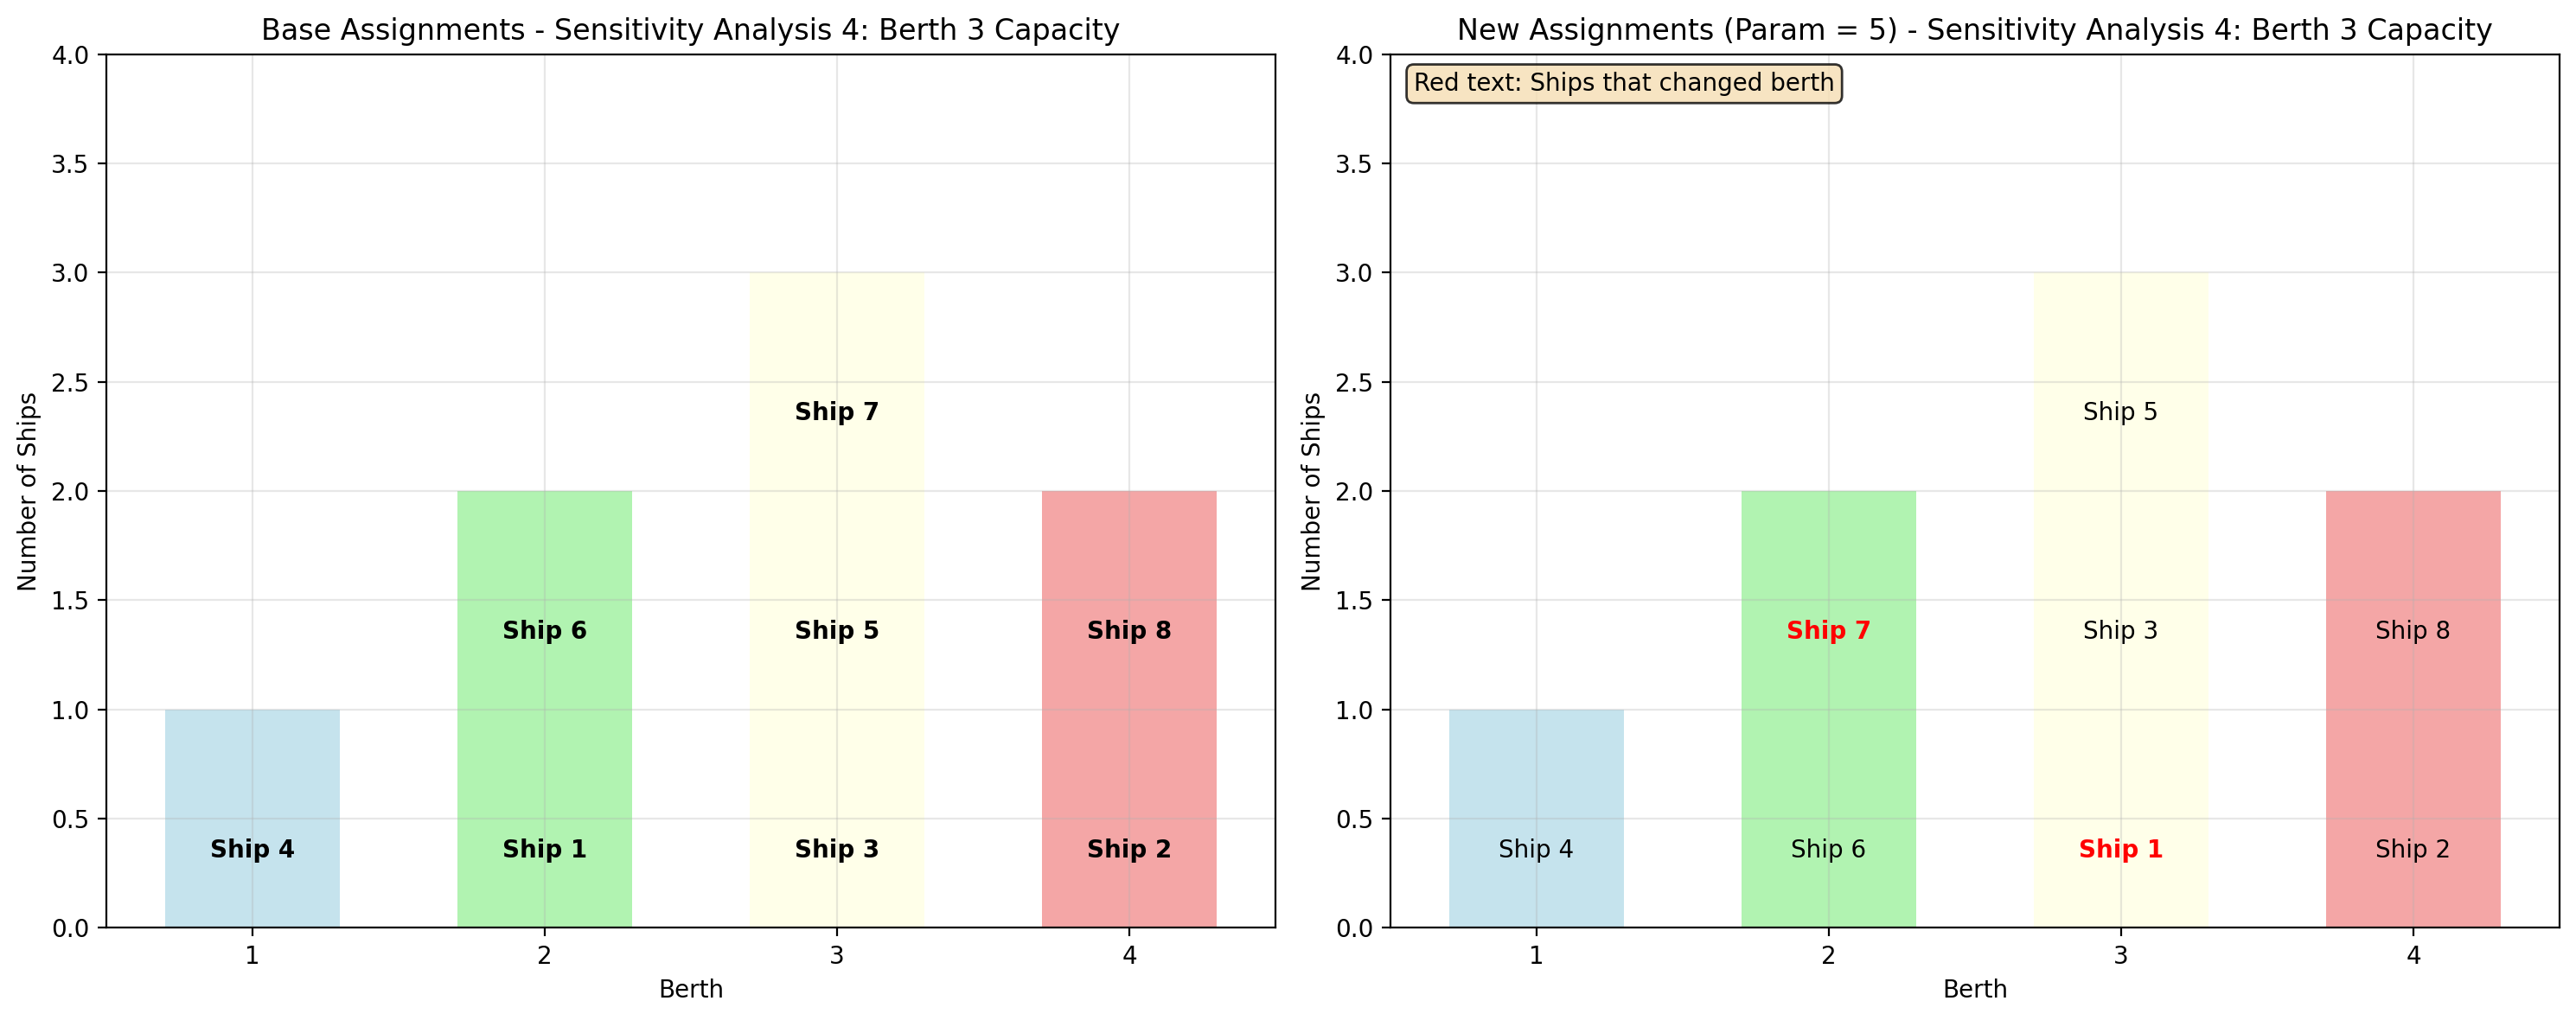

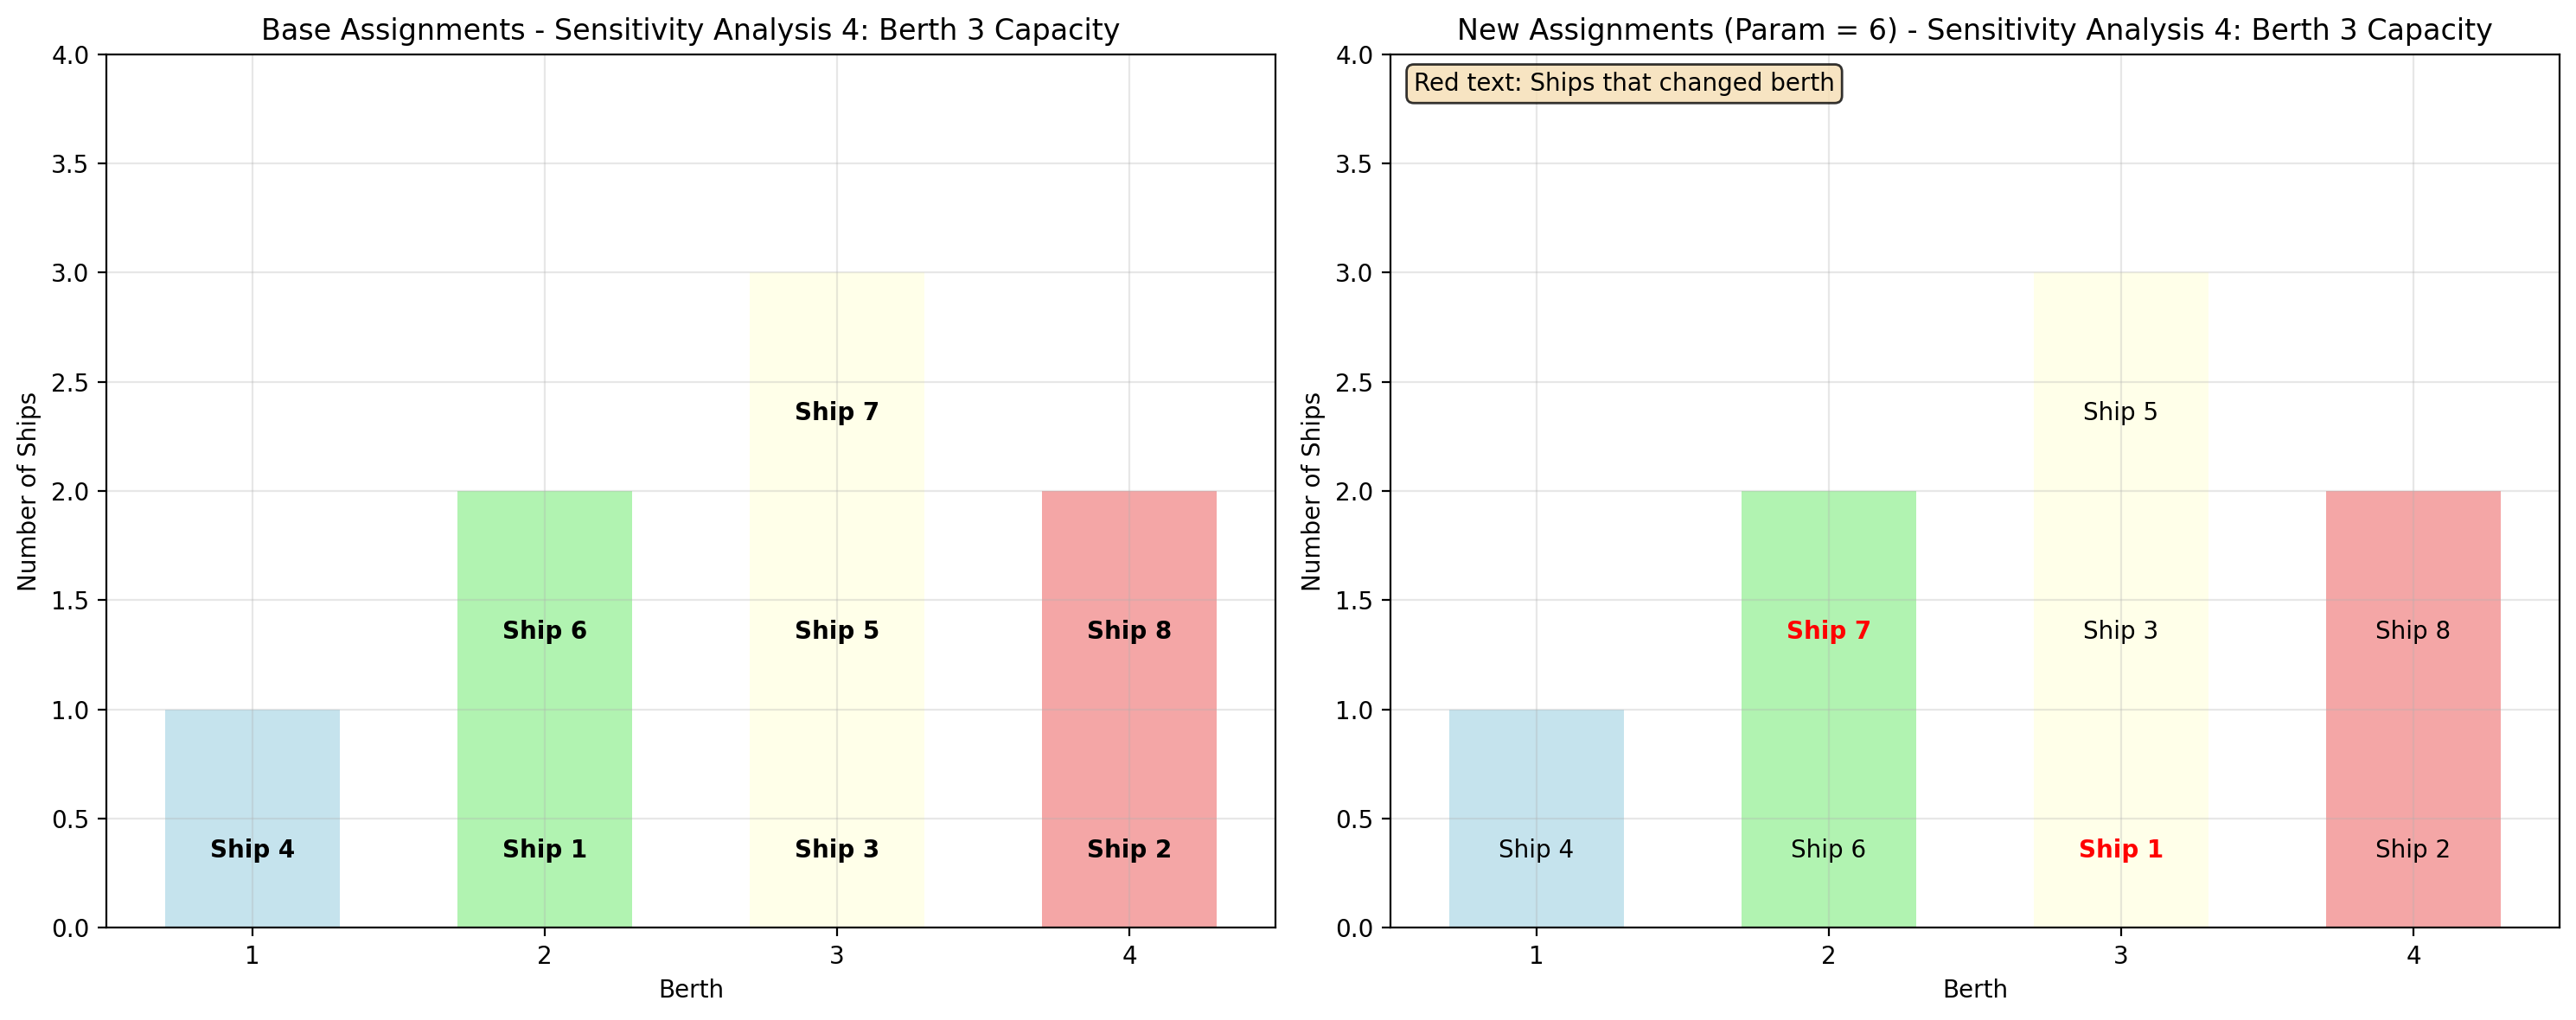

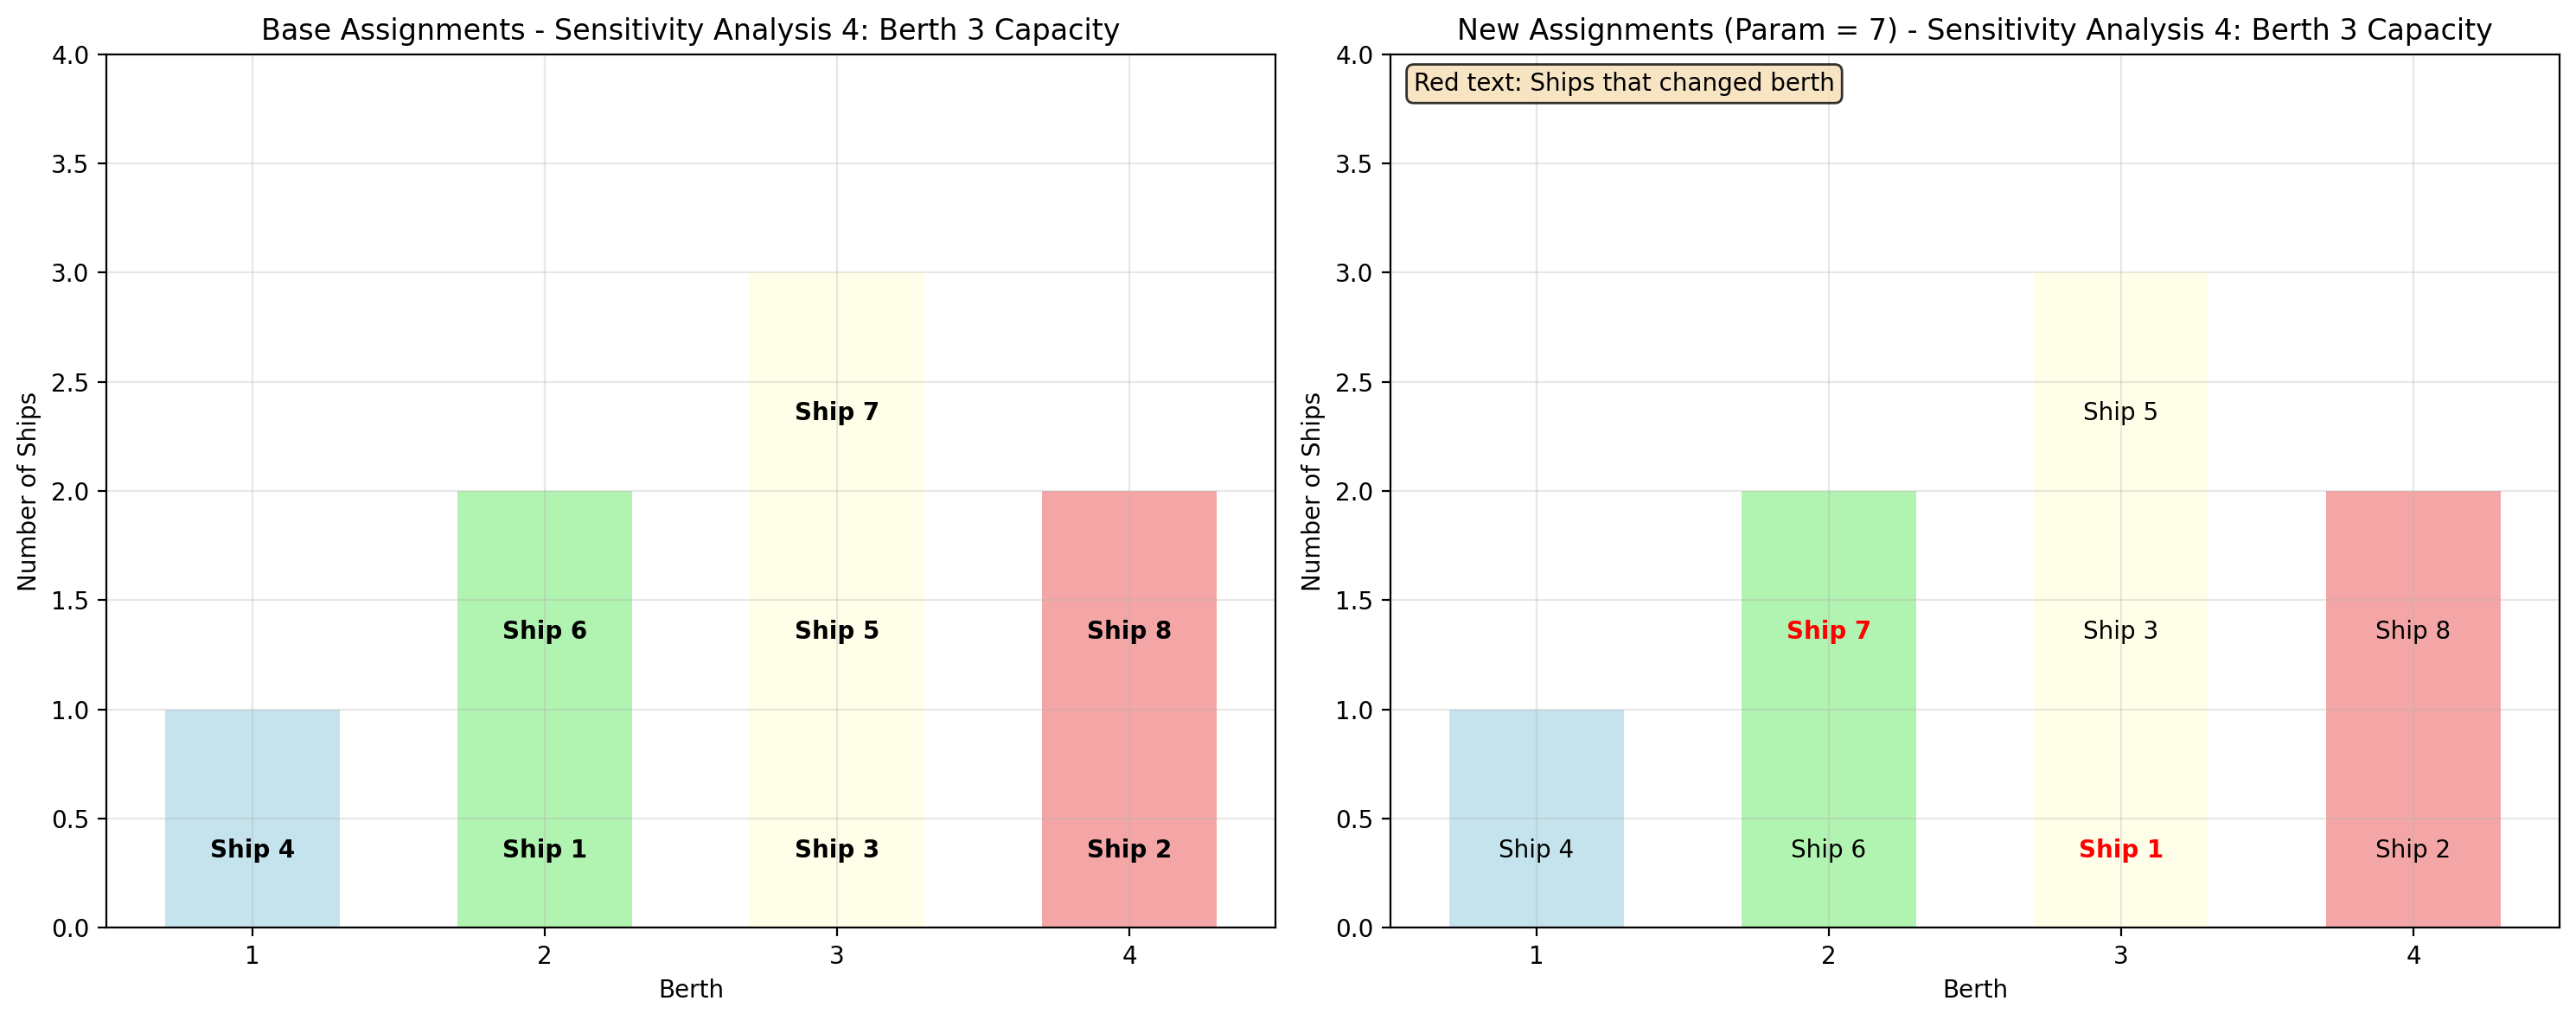

,Parameter_Value,Objective_Value,Total_Waiting_Time,Assignment_Changed,Status
0,5,2100.357367,88.628537,True,optimal
1,6,2091.493120,88.628537,True,optimal
2,7,2082.628873,88.628537,True,optimal
3,8,2073.764626,88.628537,True,optimal
4,9,2064.900380,88.628537,True,optimal


In [35]:
results_4 = []
assignments_4 = []
capacity_values = np.arange(5, 45, 1)

for cap_val in capacity_values:
    model = build_model()
    model.D[3] = cap_val

    result = solve_model(model)
    assignment_changed, changes = compare_assignments(BASE_ASSIGNMENTS, result['assignments'])

    results_4.append({
        'Parameter_Value': cap_val,
        'Objective_Value': result['objective'],
        'Total_Waiting_Time': result['total_waiting_time'],
        'Assignment_Changed': assignment_changed,
        'Status': result['status']
    })
    assignments_4.append(result['assignments'])

df_4 = pd.DataFrame(results_4)
create_sensitivity_plot(df_4, 'Sensitivity Analysis 4: Berth 3 Capacity',
                       'Capacity (units)', 4, 'orange', assignments_4, capacity_values, 'Capacity (units)')
df_4.head()

### Part 5 - Arrival Time of Ship 6:

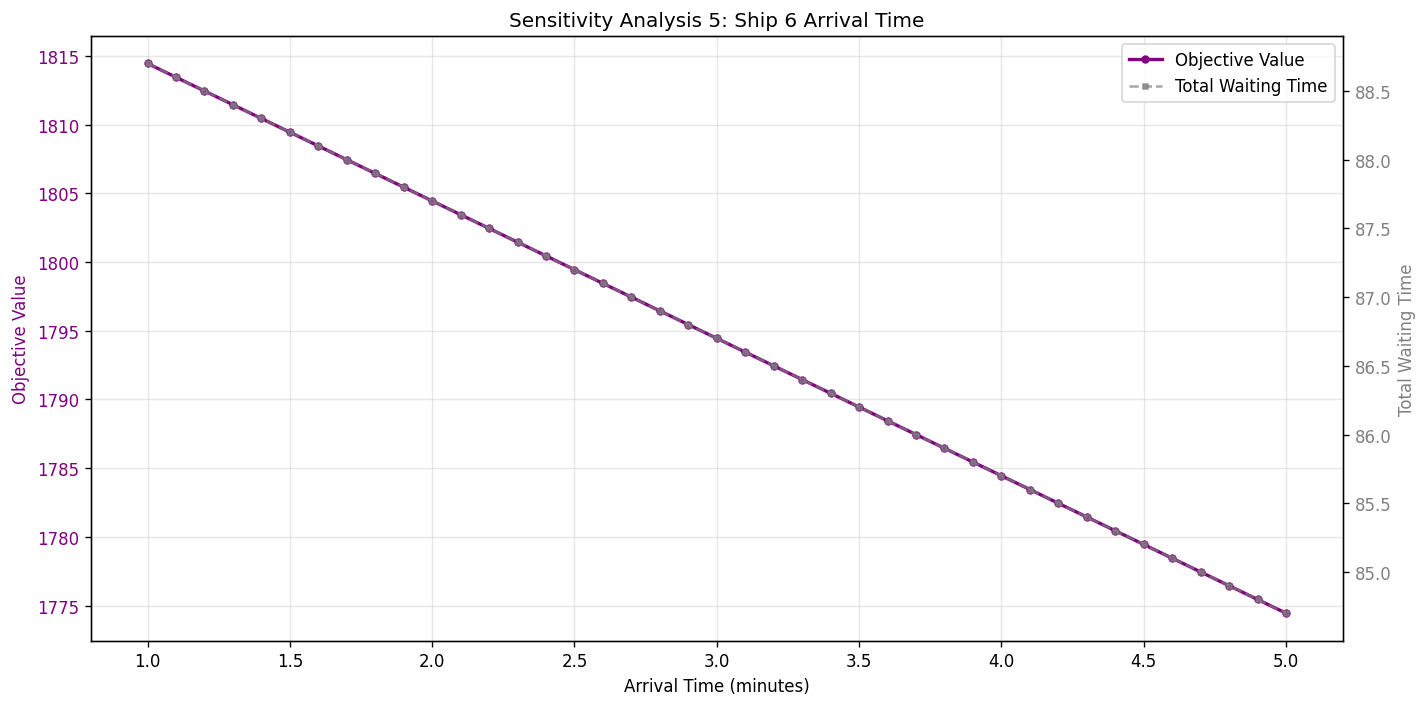


Assignment Matrix for Sensitivity Analysis 5: Ship 6 Arrival Time:


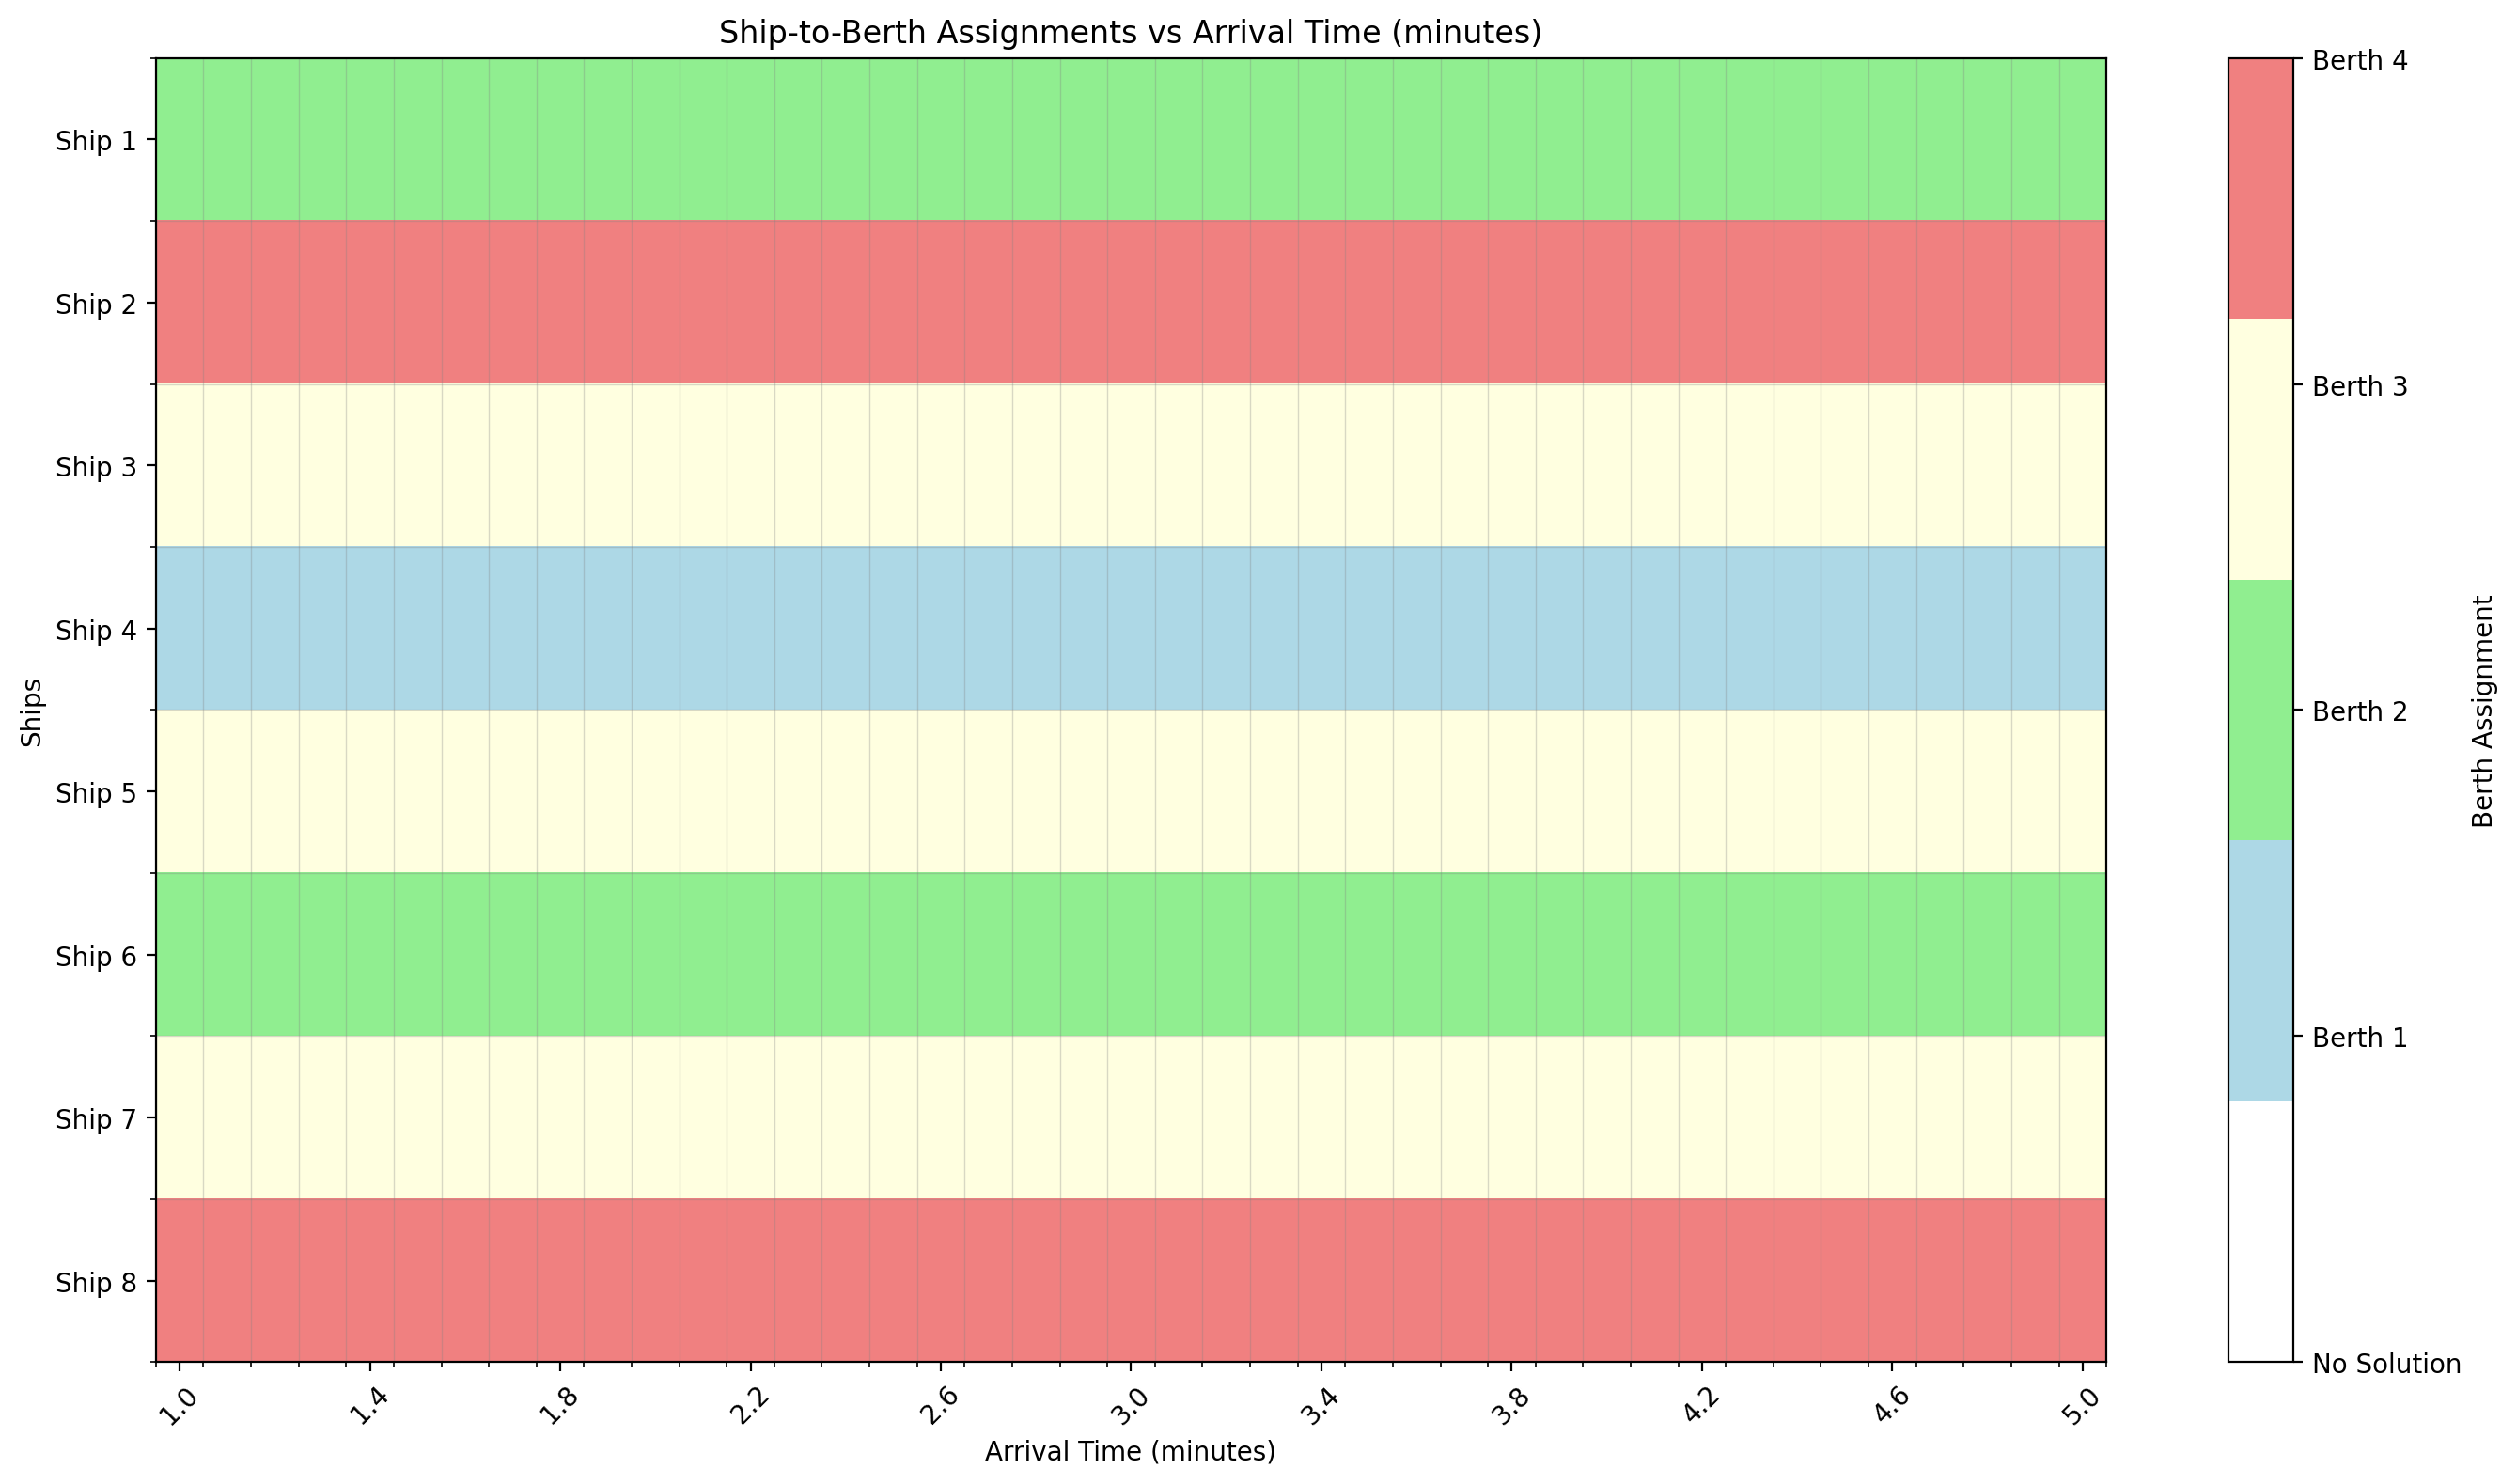

,Parameter_Value,Objective_Value,Total_Waiting_Time,Assignment_Changed,Status
0,1.0,1814.450504,88.700595,False,optimal
1,1.1,1813.450504,88.600595,False,optimal
2,1.2,1812.450504,88.500595,False,optimal
3,1.3,1811.450504,88.400595,False,optimal
4,1.4,1810.450504,88.300595,False,optimal


In [36]:
results_5 = []
assignments_5 = []
arrival_values = np.arange(1.0, 5.1, 0.1)

for arrival_val in arrival_values:
    model = build_model()
    model.A[6] = arrival_val

    result = solve_model(model)
    assignment_changed, changes = compare_assignments(BASE_ASSIGNMENTS, result['assignments'])

    results_5.append({
        'Parameter_Value': round(arrival_val, 1),
        'Objective_Value': result['objective'],
        'Total_Waiting_Time': result['total_waiting_time'],
        'Assignment_Changed': assignment_changed,
        'Status': result['status']
    })
    assignments_5.append(result['assignments'])

df_5 = pd.DataFrame(results_5)
create_sensitivity_plot(df_5, 'Sensitivity Analysis 5: Ship 6 Arrival Time',
                       'Arrival Time (minutes)', 5, 'purple', assignments_5, arrival_values, 'Arrival Time (minutes)')
df_5.head()

<h3 style="color:red;">Use of AI with Human Guidance</h3>

<p>This project incorporates the use of Artificial Intelligence (AI) tools, specifically language models, to assist in code generation, debugging, and visualization design. The AI was employed under close human supervision to ensure correctness, context relevance, and alignment with the overall project goals.</p>

<p>All AI-generated outputs were carefully reviewed, validated, and adapted by a human expert to meet the project's requirements and maintain high standards of quality and accuracy.</p>

<p>This human-AI collaboration helped accelerate development while preserving the integrity and originality of the work.</p>
